# Writeup - Vehicle Detection Project

Welcome to my writeup on vehicle detection project. This notebook contains both discussion and source code for each step.

The steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


## Rubric Points
Here I will consider the [rubric points](https://review.udacity.com/#!/rubrics/513/view) individually and describe how I addressed each point in my implementation.  

---
### Writeup / README

#### 1. Provide a Writeup / README that includes all the rubric points and how you addressed each one.  You can submit your writeup as markdown or pdf.  [Here](https://github.com/udacity/CarND-Vehicle-Detection/blob/master/writeup_template.md) is a template writeup for this project you can use as a guide and a starting point.  

You're reading it!

### Histogram of Oriented Gradients (HOG)

#### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.

The code for this step is contained in the cell below. I used the function `skimage.feature.hog` from the [scikit-image](http://scikit-image.org) library. In the function `get_hog_feaures` I can choose the number of pixels per cell, cells per block, orientation bins and the format of the feature vector.

In [1]:
from skimage.feature import hog

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

I started by reading in all the `vehicle` and `non-vehicle` images.

In [2]:
import glob
import cv2

def data_files(vehicle):
    if vehicle:
        pattern = 'data/vehicles/*/*.png'
    else:
        pattern = 'data/non-vehicles/*/*.png'
        
    files = glob.glob(pattern)
    return files

def images(vehicle):
    img_files = data_files(vehicle)
    imgs = [cv2.imread(f) for f in img_files]
    return imgs

vehicles = data_files(vehicle=True)
non_vehicles = data_files(vehicle=False)

Here is an example of one of each of the `vehicle` and `non-vehicle` classes:

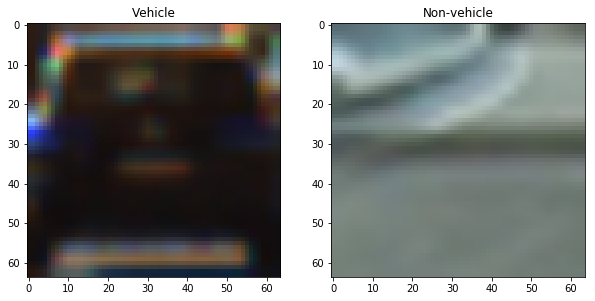

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title("Vehicle")
choice = np.random.choice(range(len(vehicles)))
plt.imshow(cv2.imread(vehicles[choice]))
plt.subplot(122)
plt.title("Non-vehicle")
choice = np.random.choice(range(len(vehicles)))
plt.imshow(cv2.imread(non_vehicles[choice]))

I then explored different color spaces and different `skimage.hog()` parameters (`orientations`, `pixels_per_cell`, and `cells_per_block`).  I grabbed random images from each of the two classes and displayed them to get a feel for what the `skimage.hog()` output looks like.

Here is an example using the `YCrCb` color space and HOG parameters of `orientations=8`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)`:

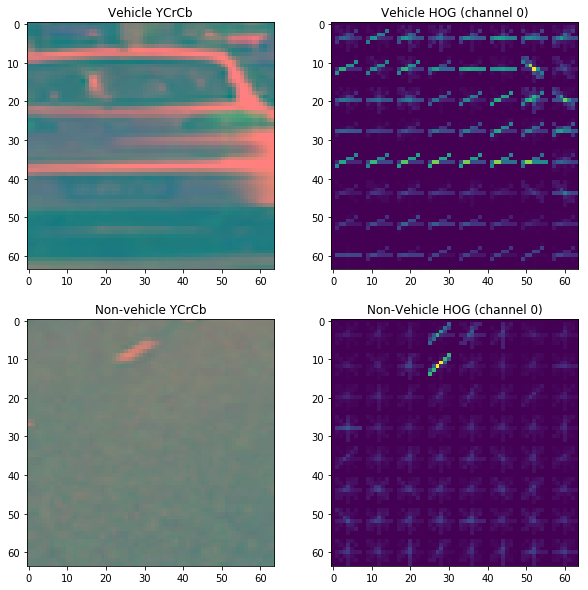

In [8]:
fig = plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title("Vehicle YCrCb")
choice = np.random.choice(range(len(vehicles)))
choice_img = cv2.imread(vehicles[choice])
converted = cv2.cvtColor(choice_img, cv2.COLOR_BGR2YCrCb) 
plt.imshow(converted)

plt.subplot(222)
plt.title("Vehicle HOG (channel 0)")
# HOG features
_, hog_image = get_hog_features(converted[:,:,0], 
                    orient=8, pix_per_cell=8, cell_per_block=2, 
                    vis=True, feature_vec=False)
plt.imshow(hog_image)

plt.subplot(223)
plt.title("Non-vehicle YCrCb")
choice = np.random.choice(range(len(non_vehicles)))
choice_img = cv2.imread(non_vehicles[choice])
converted = cv2.cvtColor(choice_img, cv2.COLOR_BGR2YCrCb) 
plt.imshow(converted)

plt.subplot(224)
plt.title("Non-Vehicle HOG (channel 0)")
# HOG features
_, hog_image  = get_hog_features(converted[:,:,0], 
                    orient=8, pix_per_cell=8, cell_per_block=2, 
                    vis=True, feature_vec=False)
plt.imshow(hog_image)

#### 2. Explain how you settled on your final choice of HOG parameters.

I tried various combinations of parameters and conclude that using the `YCrCb` color space and HOG parameters of `orientations=9`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)` is a good set of parameters (refer to section 3 for classification results).

#### 3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

First, we define the functions to extract HOG and color/spatial features to be used to train the classifier:

In [4]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract color features from a list of images
def extract_features_color(feature_image, spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    
    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    # Apply color_hist() also with a color space option now
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    
    # Return list of feature vectors
    return np.concatenate((spatial_features, hist_features))

# Define a function to extract HOG features from a list of images
def extract_features_hog(feature_image, orient=9, 
                     pix_per_cell=8, cell_per_block=2, 
                     hog_channel=0, feature_vec=True):
    
    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=feature_vec))
        if feature_vec:
            hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=feature_vec)
        
    # Return list of feature vectors
    return hog_features

def extract_features(imgs, cspace='BGR', orient=9, 
                     pix_per_cell=8, cell_per_block=2, 
                     hog_channel=0, feature_vec=True,
                     spatial_size=(32, 32), hist_bins=32,
                     hist_range=(0, 256)):
    
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = cv2.imread(file)
        image = image.astype(np.float32)/255
        
        # apply color conversion if other than 'BGR'
        if cspace != 'BGR':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        else: feature_image = np.copy(image)
        
        spatial_hist_features = extract_features_color(feature_image, spatial_size, 
                                                       hist_bins, hist_range)
        hog_features = extract_features_hog(feature_image, orient, 
                                            pix_per_cell, cell_per_block, 
                                            hog_channel, feature_vec)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_hist_features, hog_features)))
        
    return features

Now we need to extract all features from vehicles and non-vehicles images, using the function `extract_features`:

In [5]:
import time

colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32,32)
hist_bins = 32

t=time.time()
vehicle_features = extract_features(vehicles, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size=spatial_size, hist_bins=hist_bins)

non_vehicle_features = extract_features(non_vehicles, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size=spatial_size, hist_bins=hist_bins)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)

# Define a labels vector based on features lists
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

print(X.shape, y.shape)

77.59 Seconds to extract HOG features...
(17760, 8460) (17760,)


The next step is to standardize the data (remove the mean and scaling to unit variance) using [`StandardScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) from scikit-learn library:

In [6]:
from sklearn.preprocessing import StandardScaler

# Create an array stack of feature vectors
X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

Split the data in training and test data. This is useful to check if the model is over/underfitting:

In [7]:
from sklearn.model_selection import train_test_split

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.1, random_state=rand_state)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(15984, 8460) (15984,)
(1776, 8460) (1776,)


Finally, we are ready to train the classifier. We choose the [`LinearSVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) classifier as suggested in the project rubric:

In [8]:
from sklearn.svm import LinearSVC
from sklearn import metrics
import time

print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these', n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()

print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

print("Classification report:\n%s\n" % metrics.classification_report(y_test, svc.predict(X_test)))

Feature vector length: 8460
16.05 Seconds to train SVC...
Test Accuracy of SVC =  0.9887
My SVC predicts:  [ 0.  0.  1.  0.  0.  1.  0.  1.  1.  0.]
For these 10 labels:  [ 0.  0.  1.  0.  0.  0.  0.  1.  1.  0.]
0.00127 Seconds to predict 10 labels with SVC
Classification report:
             precision    recall  f1-score   support

        0.0       0.99      0.99      0.99       878
        1.0       0.99      0.99      0.99       898

avg / total       0.99      0.99      0.99      1776




### Sliding Window Search

#### 1. Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?

I used the HOG sub-sampling strategy suggested in the lesson `Hog Sub-sampling Window Search`. This method (see function `find_cars` in the cell below) uses 2 cells step (75% overlap) and results in better performance because the HOG features are extracted only once per frame. I chose not to use multi-scale windows because we can derive larger windows from smaller windows using heatmaps (see section 3).

In [202]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, 
              orient, pix_per_cell, cell_per_block, 
              spatial_size, hist_bins):
    
    #print(np.min(img), np.max(img))
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2YCrCb)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bboxes = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, 
                                                          hist_features, 
                                                          hog_features)).reshape(1, -1))
            #test_features = X_scaler.transform(hog_features.reshape(1, -1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
                bboxes.append(((xbox_left, ytop_draw+ystart), 
                               (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                                
    return bboxes

def draw_boxes(img, boxes):
    
    for box in boxes:
        cv2.rectangle(img, box[0], box[1], (0,0,255),6) 
    return img

#### 2. Show some examples of test images to demonstrate how your pipeline is working.  What did you do to optimize the performance of your classifier?

Ultimately I searched on two scales using YCrCb 3-channel HOG features plus spatially binned color and histograms of color in the feature vector, which provided a nice result.  Here are some example images:

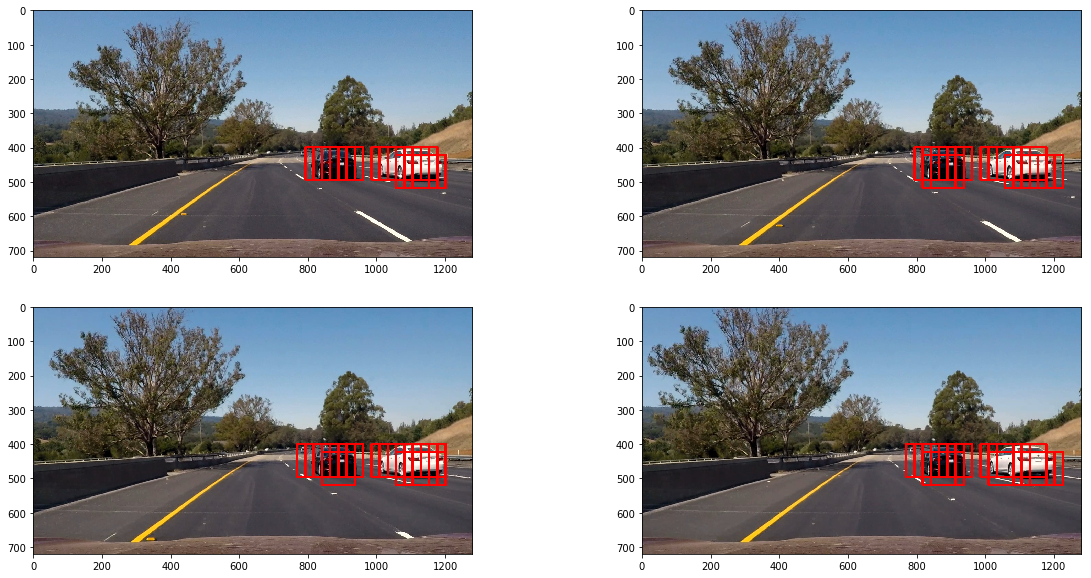

In [12]:
ystart = 400
ystop = 656
scale = 1.5

fig = plt.figure(figsize=(20,10))
files = glob.glob('test_images/*.jpg')[:4]

for i, f in enumerate(files):
    
    plt.subplot(len(files)/2,2, i+1)
    img = cv2.imread(f)
    boxes = find_cars(img, ystart, ystop, scale, 
                      svc, X_scaler, orient, 
                      pix_per_cell, cell_per_block, 
                      spatial_size, hist_bins)
    
    out_img = draw_boxes(img, boxes)
    plt.imshow(cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))

#### 3. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

I recorded the positions of positive detections in each frame of the video. From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions. I then used `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap. I then assumed each blob corresponded to a vehicle. I constructed bounding boxes to cover the area of each blob detected.

In [290]:
def add_heat(heatmap, bbox_list):
    
    before = heatmap.copy()
    
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    #heatmap[heatmap == before] -= 1    
    #heatmap = np.clip(heatmap, 0, 255)
    
    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

Here's an example result showing the heatmap from a series of frames of video, the result of `scipy.ndimage.measurements.label()` and the bounding boxes then overlaid on the last frame of video:

#### Here are six frames and their corresponding heatmaps:

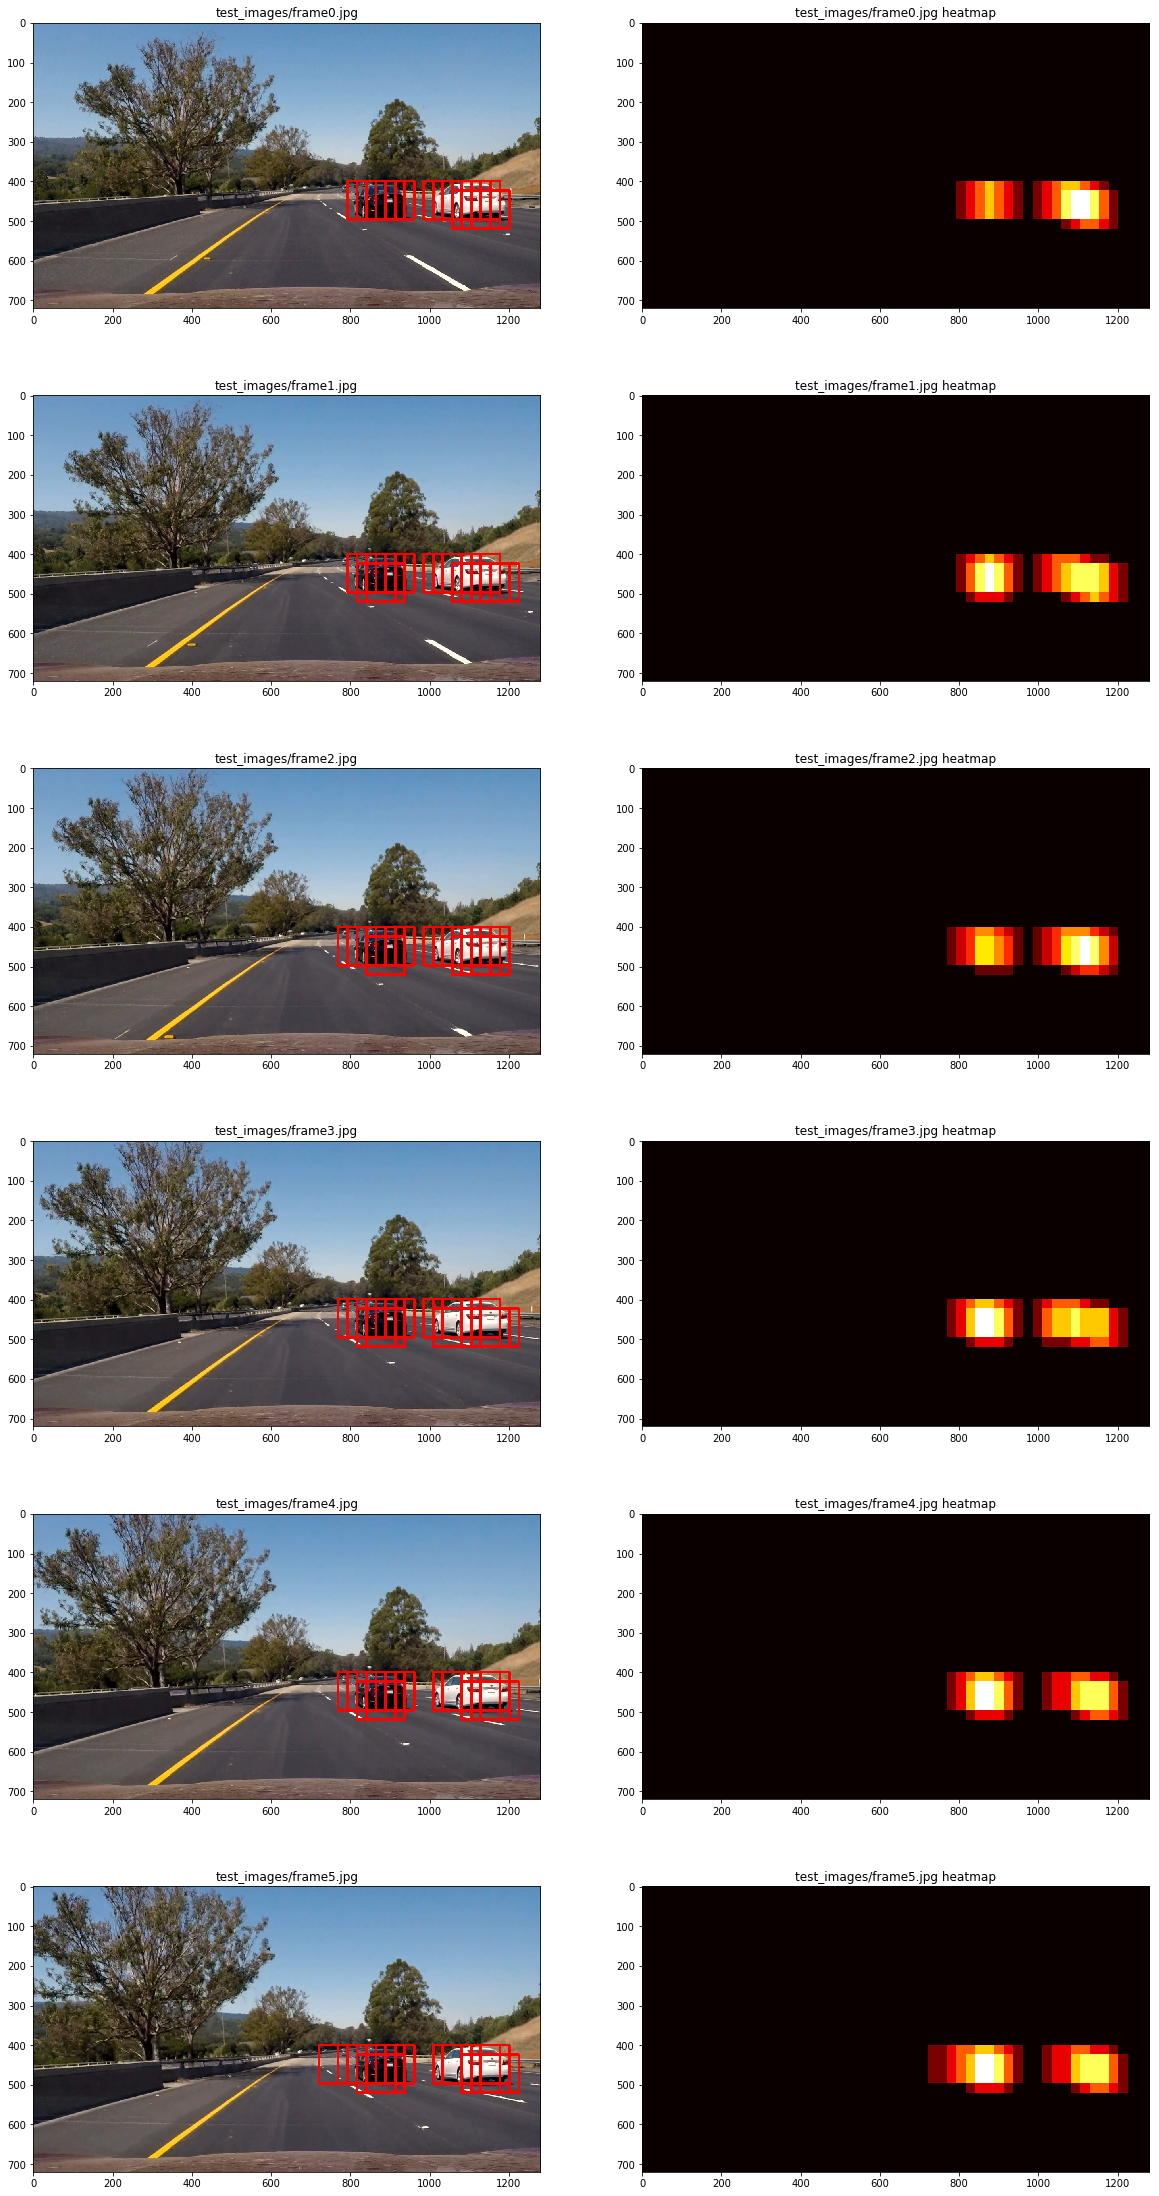

In [68]:
fig = plt.figure(figsize=(20,40))
files = glob.glob('test_images/frame*.jpg')[:6]

for i, f in enumerate(files):
    
    img = cv2.imread(f)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    boxes = find_cars(img, ystart, ystop, scale, 
                      svc, X_scaler, orient, 
                      pix_per_cell, cell_per_block, 
                      spatial_size, hist_bins)
    frame = draw_boxes(img, boxes)
    
    plt.subplot(len(files), 2, 2*i+1)
    plt.title(f)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    
    # Add heat to each box in box list
    heat = add_heat(heat, boxes)
    
    # Visualize the heatmap when displaying    
    heat = np.clip(heat, 0, 255)

    plt.subplot(len(files), 2, 2*i+2)
    plt.title(f + ' heatmap')
    plt.imshow(heat, cmap='hot')

#### Here is the output of `scipy.ndimage.measurements.label()` on the integrated heatmap from all six frames:

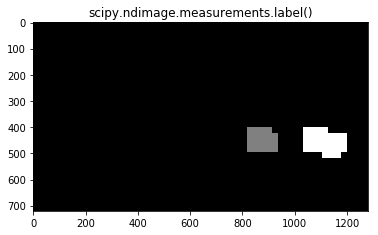

In [478]:
from scipy.ndimage.measurements import label
from collections import deque

heats = deque()

def get_heat(img, history_size=20, scale=1.5, threshold=20):
    '''
    Get labels using `history_size` frames after
    applying a specified heatmap `threshold`.
    '''
    
    '''
    Get labels using `history_size` frames after
    applying a specified heatmap `threshold`.
    '''
    
    # remove oldest heatmap from list
    if len(heats) == history_size:
        old_heat = heats.popleft()
        for i, h in enumerate(heats):
            heats[i] = heats[i] - old_heat
    
    if len(heats) == 0:
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
    else:
        heat = heats[-1]
    
    boxes = find_cars(img, ystart, ystop, scale, 
                      svc, X_scaler, orient, 
                      pix_per_cell, cell_per_block, 
                      spatial_size, hist_bins)
    
    # Add heat to each box in box list
    heat = add_heat(heat, boxes)
    
    heats.append(heat)
    
    # Visualize the heatmap when displaying    
    heat = np.clip(heat.copy(), 0, 255)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, threshold)
    
    # Find final boxes from heatmap using label function
    return heat


files = glob.glob('test_images/frame*.jpg')

for i, f in enumerate(files):
    img = cv2.imread(f)
    heat = get_heat(img)
   
plt.title('scipy.ndimage.measurements.label()')
plt.imshow(label(heat)[0], cmap='gray')

#### Here the resulting bounding boxes are drawn onto the last frame in the series:

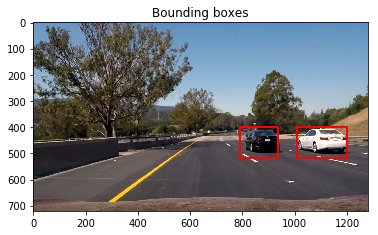

In [294]:
file = glob.glob('test_images/frame*.jpg')[5]
img = cv2.imread(file)
img = draw_labeled_bboxes(img, label(heat))
plt.title("Bounding boxes")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

### Video Implementation

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)
Here's a [link to my video result](./vehicle_detection.mp4)

Even with a good performance in individual frame images, the algorithm results in many false positives when applied to the videos. To address this issue, we have to keep track of the vehicles currently in the scene apply some extra detection thresholds, box averaging and box merging. We use a class `Vehicle` to keep detection metadata for each vehicle. 

In [494]:
from math import sqrt

def get_box_center(box):
    x1 = box[0][1]
    x2 = box[1][1]
    y1 = box[0][0]
    y2 = box[1][0]

    xm = (x2 + x1) / 2
    ym = (y2 + y1) / 2
    return (ym, xm)

def box_contains(box, point):
    x1 = box[0][1]
    x2 = box[1][1]
    y1 = box[0][0]
    y2 = box[1][0]

    contains_x = x1 <= point[1] and x2 >= point[1]
    contains_y = y1 <= point[0] and y2 >= point[0]
    return contains_x and contains_y

def get_box_width(box):
    x1 = box[0][1]
    x2 = box[1][1]
    return x2 - x1
    
def get_box_height(box):
    y1 = box[0][0]
    y2 = box[1][0]
    return y2 - y1

class Vehicle:
    
    def __init__(self, max_match_distance=70, detection_threshold=10):
        self.detection_count = 0
        self.box = None
        self.boxes = []
        self.in_scene = False
        self.max_match_distance = max_match_distance
        self.detection_threshold = detection_threshold
        
    def get_center(self):
        if self.box is None:
            return None
        return get_box_center(self.box)
    
    def get_width(self):
        if self.box is None:
            return None
        return get_box_width(self.box)
    
    def get_height(self):
        if self.box is None:
            return None
        return get_box_height(self.box)
    
    def check_dimensions(self):
        
        if self.box is None:
            return False
        
        width = self.get_width()
        height = self.get_height()
        return (width > 80) and (height > 60)
    
    def safe_detection(self):
        return (self.check_dimensions() and 
                self.detection_count >= self.detection_threshold)
    
    def box_match(self, box):
        if box is None or len(self.boxes) == 0:
            return False
        
        c1 = get_box_center(box)
        c2 = self.get_center()
        distance = sqrt((c1[0] - c2[0]) ** 2 + (c1[1] - c2[1]) ** 2)
        
        return (distance < self.max_match_distance) and box_contains(self.box, c1)
        
    def match_detection(self, box):
        
        #if get_box_width(box) < 40 and get_box_height(box) < 40:
        #    return False
        
        if self.box_match(box):
            x1 = self.box[0][1]
            x2 = self.box[1][1]
            y1 = self.box[0][0]
            y2 = self.box[1][0]
            
            weight = 5
            x1 = int((x1 * len(self.boxes) + weight * box[0][1]) / (len(self.boxes) + weight))
            x2 = int((x2 * len(self.boxes) + weight * box[1][1]) / (len(self.boxes) + weight))
            y1 = int((y1 * len(self.boxes) + weight * box[0][0]) / (len(self.boxes) + weight))
            y2 = int((y2 * len(self.boxes) + weight * box[1][0]) / (len(self.boxes) + weight))
            
            new_box = ((y1, x1), (y2, x2))
            self.box = new_box
            self.boxes.append(new_box)
            
            if self.detection_count < 50:
                self.detection_count += 1
                
            self.in_scene = True
            return True
        
        elif len(self.boxes) == 0:
            x1 = box[0][1]
            x2 = box[1][1]
            y1 = box[0][0]
            y2 = box[1][0]
            new_box = ((y1, x1), (y2, x2))
            self.box = new_box
            self.boxes.append(new_box)
            
            if self.detection_count < 50:
                self.detection_count += 1
                
            self.in_scene = True
            return True
        
        #if self.detection_count > 0:
        #    self.detection_count -= 1
            
        return False
    
    #def __unicode__(self):
    #    return u"representation"
    
    def __str__(self):
        return 'Center: {}; Size: {}x{}; Detections: {}; Safe: {}'.format(self.get_center(), 
                                                          self.get_height(),
                                                          self.get_width(),
                                                          self.detection_count,
                                                          self.safe_detection())

And then we implement an algorithm to keep a consistent list of the current vehicles, while trying to eliminate the false positives.

In [479]:
def boxes_from_labels(labels):
    boxes = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), 
                (np.max(nonzerox), np.max(nonzeroy)))
        boxes.append(bbox)
    return boxes


def detect(img, vehicles, detection_threshold=30):
    heat = get_heat(img)
    labels = label(heat)
    boxes = boxes_from_labels(labels)
    
    for v in vehicles:
        v.in_scene = False
    
    for box in boxes:
        
        already_detected = False
        
        for v in vehicles:
            if v.match_detection(box):
                already_detected = True
                #break
        
        # create a new vehicle if box does not match existing vehicles
        if not already_detected:
            v = Vehicle(detection_threshold=detection_threshold)
            v.match_detection(box)
            vehicles.append(v)
    
    # penalizing vehicles not found in frame
    for v in vehicles:
        if not v.in_scene and v.detection_count > 0:
            v.detection_count -= 1
    
    # merging overlapping detections
    merged_vehicles = []
    to_exclude = []
    
    for i, v in enumerate(vehicles):
        
        if i in to_exclude:
            continue
        
        for j in range(i+1, len(vehicles)):
            
            if v.box_match(vehicles[j].box):
                to_exclude.append(j)
                v.detection_count += vehicles[j].detection_count
        
        merged_vehicles.append(v)
    
    # self-adjusting detection threshold
    '''mean_detections = 0
    count = 0

    for v in merged_vehicles:
        if v.safe_detection():
            mean_detections += v.detection_count
            count += 1

    if count > 0:        
        mean_detections = mean_detections / count
        print(mean_detections)
        for v in vehicles:
            if mean_detections > v.detection_threshold:
                v.detection_threshold = mean_detections'''
        
    return merged_vehicles

def draw_vehicles(img, vehicles):
    for v in vehicles:
        if v.safe_detection():
            cv2.rectangle(img, v.box[0], v.box[1], (0,0,255), 6)

In [491]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip

heats = deque()
#heat = None
threshold = None
vehicles = list()

def process_image(frame):
    #heat = get_heat(frame, threshold=3)
    #labels = label(heat)
    #boxes = boxes_from_labels(labels)
    #draw_boxes(frame, boxes)
    
    global vehicles
    
    vehicles = detect(frame, vehicles)
    print(len(vehicles), sum([1 if v.safe_detection() else 0 for v in vehicles]))
    print([str(v) for v in vehicles])
    
    draw_vehicles(frame, vehicles)
    return frame
    
clip = VideoFileClip('project_video.mp4')
white_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile('vehicle_detection.mp4', audio=False)

0 0
[]
[MoviePy] >>>> Building video vehicle_detection.mp4
[MoviePy] Writing video vehicle_detection.mp4















  0%|          | 0/1261 [00:00<?, ?it/s]












  0%|          | 1/1261 [00:00<06:31,  3.22it/s]

0 0
[]















  0%|          | 2/1261 [00:00<06:31,  3.22it/s]

0 0
[]















  0%|          | 3/1261 [00:00<06:39,  3.15it/s]

0 0
[]















  0%|          | 4/1261 [00:01<06:35,  3.18it/s]

0 0
[]















  0%|          | 5/1261 [00:01<06:32,  3.20it/s]

0 0
[]















  0%|          | 6/1261 [00:01<06:28,  3.23it/s]

0 0
[]















  1%|          | 7/1261 [00:02<06:30,  3.21it/s]

0 0
[]















  1%|          | 8/1261 [00:02<06:41,  3.12it/s]

0 0
[]















  1%|          | 9/1261 [00:02<06:51,  3.04it/s]

0 0
[]















  1%|          | 10/1261 [00:03<06:54,  3.02it/s]

0 0
[]















  1%|          | 11/1261 [00:03<06:45,  3.08it/s]

0 0
[]















  1%|          | 12/1261 [00:03<06:41,  3.11it/s]

0 0
[]















  1%|          | 13/1261 [00:04<06:40,  3.12it/s]

0 0
[]















  1%|          | 14/1261 [00:04<06:41,  3.11it/s]

0 0
[]















  1%|          | 15/1261 [00:04<06:39,  3.12it/s]

0 0
[]















  1%|▏         | 16/1261 [00:05<06:43,  3.09it/s]

0 0
[]















  1%|▏         | 17/1261 [00:05<06:49,  3.04it/s]

0 0
[]















  1%|▏         | 18/1261 [00:05<06:52,  3.01it/s]

0 0
[]















  2%|▏         | 19/1261 [00:06<06:58,  2.97it/s]

0 0
[]















  2%|▏         | 20/1261 [00:06<07:33,  2.74it/s]

0 0
[]















  2%|▏         | 21/1261 [00:07<07:50,  2.63it/s]

0 0
[]















  2%|▏         | 22/1261 [00:07<08:05,  2.55it/s]

0 0
[]















  2%|▏         | 23/1261 [00:07<08:12,  2.51it/s]

0 0
[]















  2%|▏         | 24/1261 [00:08<08:21,  2.47it/s]

0 0
[]















  2%|▏         | 25/1261 [00:08<08:24,  2.45it/s]

0 0
[]















  2%|▏         | 26/1261 [00:09<08:25,  2.44it/s]

0 0
[]















  2%|▏         | 27/1261 [00:09<08:26,  2.44it/s]

0 0
[]















  2%|▏         | 28/1261 [00:09<08:26,  2.43it/s]

0 0
[]















  2%|▏         | 29/1261 [00:10<08:32,  2.40it/s]

0 0
[]















  2%|▏         | 30/1261 [00:10<08:36,  2.38it/s]

0 0
[]















  2%|▏         | 31/1261 [00:11<08:32,  2.40it/s]

0 0
[]















  3%|▎         | 32/1261 [00:11<08:29,  2.41it/s]

0 0
[]















  3%|▎         | 33/1261 [00:11<08:27,  2.42it/s]

0 0
[]















  3%|▎         | 34/1261 [00:12<08:26,  2.42it/s]

0 0
[]















  3%|▎         | 35/1261 [00:12<08:25,  2.43it/s]

0 0
[]















  3%|▎         | 36/1261 [00:13<08:26,  2.42it/s]

1 0
['Center: (1067.5, 459.5); Size: 23x71; Detections: 1; Safe: False']















  3%|▎         | 37/1261 [00:13<08:27,  2.41it/s]

1 0
['Center: (1067.5, 453.5); Size: 23x83; Detections: 2; Safe: False']















  3%|▎         | 38/1261 [00:14<08:32,  2.39it/s]

1 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 3; Safe: False']















  3%|▎         | 39/1261 [00:14<08:34,  2.37it/s]

2 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 2; Safe: False', 'Center: (1079.5, 447.5); Size: 47x95; Detections: 1; Safe: False']















  3%|▎         | 40/1261 [00:14<08:31,  2.39it/s]

2 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 1; Safe: False', 'Center: (1085.5, 447.5); Size: 59x95; Detections: 2; Safe: False']















  3%|▎         | 41/1261 [00:15<08:30,  2.39it/s]

2 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1091.5, 447.5); Size: 55x95; Detections: 3; Safe: False']















  3%|▎         | 42/1261 [00:15<08:26,  2.41it/s]

2 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1097.5, 447.5); Size: 59x95; Detections: 4; Safe: False']















  3%|▎         | 43/1261 [00:16<08:32,  2.38it/s]

2 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 5; Safe: False']















  3%|▎         | 44/1261 [00:16<08:30,  2.39it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 4; Safe: False', 'Center: (1139.5, 447.5); Size: 71x95; Detections: 1; Safe: False']















  4%|▎         | 45/1261 [00:17<08:43,  2.32it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 3; Safe: False', 'Center: (1139.5, 447.5); Size: 71x95; Detections: 2; Safe: False']















  4%|▎         | 46/1261 [00:17<08:44,  2.32it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 2; Safe: False', 'Center: (1139.5, 447.5); Size: 71x95; Detections: 3; Safe: False']















  4%|▎         | 47/1261 [00:17<08:45,  2.31it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 1; Safe: False', 'Center: (1139.5, 447.5); Size: 71x95; Detections: 4; Safe: False']















  4%|▍         | 48/1261 [00:18<08:48,  2.29it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1141.5, 447.5); Size: 67x95; Detections: 5; Safe: False']















  4%|▍         | 49/1261 [00:18<08:53,  2.27it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1145.0, 447.5); Size: 60x95; Detections: 6; Safe: False']















  4%|▍         | 50/1261 [00:19<08:55,  2.26it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1147.5, 447.5); Size: 55x95; Detections: 7; Safe: False']















  4%|▍         | 51/1261 [00:19<08:56,  2.26it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 8; Safe: False']















  4%|▍         | 52/1261 [00:20<08:52,  2.27it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 7; Safe: False']















  4%|▍         | 53/1261 [00:20<08:47,  2.29it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 6; Safe: False']















  4%|▍         | 54/1261 [00:20<08:41,  2.32it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 5; Safe: False']















  4%|▍         | 55/1261 [00:21<08:39,  2.32it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 4; Safe: False']















  4%|▍         | 56/1261 [00:21<08:36,  2.33it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 3; Safe: False']















  5%|▍         | 57/1261 [00:22<08:28,  2.37it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 2; Safe: False']















  5%|▍         | 58/1261 [00:22<08:23,  2.39it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 1; Safe: False']















  5%|▍         | 59/1261 [00:23<08:20,  2.40it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  5%|▍         | 60/1261 [00:23<08:18,  2.41it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  5%|▍         | 61/1261 [00:23<08:18,  2.41it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  5%|▍         | 62/1261 [00:24<08:16,  2.42it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  5%|▍         | 63/1261 [00:24<08:15,  2.42it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  5%|▌         | 64/1261 [00:25<08:22,  2.38it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  5%|▌         | 65/1261 [00:25<08:23,  2.38it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  5%|▌         | 66/1261 [00:26<08:22,  2.38it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  5%|▌         | 67/1261 [00:26<08:22,  2.38it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  5%|▌         | 68/1261 [00:26<08:24,  2.37it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  5%|▌         | 69/1261 [00:27<08:26,  2.35it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  6%|▌         | 70/1261 [00:27<08:31,  2.33it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  6%|▌         | 71/1261 [00:28<09:10,  2.16it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  6%|▌         | 72/1261 [00:28<09:24,  2.11it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  6%|▌         | 73/1261 [00:29<09:26,  2.10it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  6%|▌         | 74/1261 [00:29<09:26,  2.09it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  6%|▌         | 75/1261 [00:30<09:23,  2.10it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  6%|▌         | 76/1261 [00:30<09:21,  2.11it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  6%|▌         | 77/1261 [00:31<09:18,  2.12it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  6%|▌         | 78/1261 [00:31<09:06,  2.16it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  6%|▋         | 79/1261 [00:31<08:51,  2.22it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  6%|▋         | 80/1261 [00:32<08:51,  2.22it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  6%|▋         | 81/1261 [00:32<08:47,  2.24it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  7%|▋         | 82/1261 [00:33<08:48,  2.23it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  7%|▋         | 83/1261 [00:33<08:45,  2.24it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  7%|▋         | 84/1261 [00:34<08:47,  2.23it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  7%|▋         | 85/1261 [00:34<08:37,  2.27it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  7%|▋         | 86/1261 [00:35<08:35,  2.28it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  7%|▋         | 87/1261 [00:35<08:31,  2.30it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  7%|▋         | 88/1261 [00:35<08:30,  2.30it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  7%|▋         | 89/1261 [00:36<08:28,  2.30it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  7%|▋         | 90/1261 [00:36<08:28,  2.30it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  7%|▋         | 91/1261 [00:37<08:24,  2.32it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  7%|▋         | 92/1261 [00:37<08:22,  2.33it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  7%|▋         | 93/1261 [00:38<08:18,  2.34it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  7%|▋         | 94/1261 [00:38<08:19,  2.33it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  8%|▊         | 95/1261 [00:38<08:22,  2.32it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  8%|▊         | 96/1261 [00:39<08:26,  2.30it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  8%|▊         | 97/1261 [00:39<08:23,  2.31it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  8%|▊         | 98/1261 [00:40<08:21,  2.32it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  8%|▊         | 99/1261 [00:40<08:29,  2.28it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  8%|▊         | 100/1261 [00:41<08:32,  2.26it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  8%|▊         | 101/1261 [00:41<08:35,  2.25it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  8%|▊         | 102/1261 [00:42<08:30,  2.27it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  8%|▊         | 103/1261 [00:42<08:28,  2.28it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  8%|▊         | 104/1261 [00:42<08:28,  2.28it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  8%|▊         | 105/1261 [00:43<08:29,  2.27it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  8%|▊         | 106/1261 [00:43<08:25,  2.28it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  8%|▊         | 107/1261 [00:44<08:19,  2.31it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  9%|▊         | 108/1261 [00:44<08:16,  2.32it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  9%|▊         | 109/1261 [00:45<08:21,  2.30it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  9%|▊         | 110/1261 [00:45<08:19,  2.31it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  9%|▉         | 111/1261 [00:45<08:19,  2.30it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  9%|▉         | 112/1261 [00:46<08:16,  2.31it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  9%|▉         | 113/1261 [00:46<08:14,  2.32it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  9%|▉         | 114/1261 [00:47<08:13,  2.33it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  9%|▉         | 115/1261 [00:47<08:10,  2.34it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  9%|▉         | 116/1261 [00:48<08:10,  2.33it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  9%|▉         | 117/1261 [00:48<08:14,  2.32it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  9%|▉         | 118/1261 [00:48<08:12,  2.32it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















  9%|▉         | 119/1261 [00:49<08:12,  2.32it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















 10%|▉         | 120/1261 [00:49<08:14,  2.31it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















 10%|▉         | 121/1261 [00:50<08:20,  2.28it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















 10%|▉         | 122/1261 [00:50<08:20,  2.28it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















 10%|▉         | 123/1261 [00:51<08:23,  2.26it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















 10%|▉         | 124/1261 [00:51<08:20,  2.27it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















 10%|▉         | 125/1261 [00:52<08:15,  2.29it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















 10%|▉         | 126/1261 [00:52<08:10,  2.31it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















 10%|█         | 127/1261 [00:52<08:09,  2.32it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















 10%|█         | 128/1261 [00:53<08:09,  2.31it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















 10%|█         | 129/1261 [00:53<08:09,  2.31it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















 10%|█         | 130/1261 [00:54<08:06,  2.32it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















 10%|█         | 131/1261 [00:54<08:07,  2.32it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















 10%|█         | 132/1261 [00:55<08:10,  2.30it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















 11%|█         | 133/1261 [00:55<08:07,  2.32it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















 11%|█         | 134/1261 [00:55<08:02,  2.33it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















 11%|█         | 135/1261 [00:56<08:05,  2.32it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















 11%|█         | 136/1261 [00:56<08:11,  2.29it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















 11%|█         | 137/1261 [00:57<08:13,  2.28it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















 11%|█         | 138/1261 [00:57<08:15,  2.27it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















 11%|█         | 139/1261 [00:58<08:18,  2.25it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















 11%|█         | 140/1261 [00:58<08:13,  2.27it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















 11%|█         | 141/1261 [00:58<08:08,  2.29it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















 11%|█▏        | 142/1261 [00:59<08:11,  2.28it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















 11%|█▏        | 143/1261 [00:59<08:12,  2.27it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 447.5); Size: 51x95; Detections: 0; Safe: False']















 11%|█▏        | 144/1261 [01:00<08:10,  2.28it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1151.0, 450.0); Size: 48x90; Detections: 1; Safe: False']















 11%|█▏        | 145/1261 [01:00<08:12,  2.26it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1152.0, 450.5); Size: 50x89; Detections: 2; Safe: False']















 12%|█▏        | 146/1261 [01:01<08:10,  2.27it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1153.0, 451.0); Size: 52x88; Detections: 3; Safe: False']















 12%|█▏        | 147/1261 [01:01<08:08,  2.28it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1153.5, 451.5); Size: 53x87; Detections: 4; Safe: False']















 12%|█▏        | 148/1261 [01:02<08:07,  2.28it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1153.0, 452.0); Size: 56x86; Detections: 5; Safe: False']















 12%|█▏        | 149/1261 [01:02<08:07,  2.28it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1152.5, 452.5); Size: 59x85; Detections: 6; Safe: False']















 12%|█▏        | 150/1261 [01:02<08:15,  2.24it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1152.0, 452.5); Size: 62x85; Detections: 7; Safe: False']















 12%|█▏        | 151/1261 [01:03<08:16,  2.23it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1150.5, 452.5); Size: 63x85; Detections: 8; Safe: False']















 12%|█▏        | 152/1261 [01:03<08:19,  2.22it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1149.5, 452.5); Size: 63x85; Detections: 9; Safe: False']















 12%|█▏        | 153/1261 [01:04<08:17,  2.23it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 61x95; Detections: 0; Safe: False', 'Center: (1148.5, 452.5); Size: 63x85; Detections: 10; Safe: False']















 12%|█▏        | 154/1261 [01:04<08:20,  2.21it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1104.5, 451.5); Size: 67x95; Detections: 1; Safe: False', 'Center: (1147.0, 453.0); Size: 64x86; Detections: 11; Safe: False']















 12%|█▏        | 155/1261 [01:05<08:15,  2.23it/s]

3 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1107.5, 453.5); Size: 71x95; Detections: 2; Safe: False', 'Center: (1145.5, 453.5); Size: 65x87; Detections: 12; Safe: False']















 12%|█▏        | 156/1261 [01:05<08:11,  2.25it/s]

2 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1110.0, 455.5); Size: 74x95; Detections: 16; Safe: False']















 12%|█▏        | 157/1261 [01:06<08:07,  2.27it/s]

2 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1111.5, 456.5); Size: 77x95; Detections: 17; Safe: False']















 13%|█▎        | 158/1261 [01:06<08:01,  2.29it/s]

2 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1112.5, 457.5); Size: 79x95; Detections: 18; Safe: False']















 13%|█▎        | 159/1261 [01:06<08:00,  2.29it/s]

2 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1113.5, 458.5); Size: 81x95; Detections: 19; Safe: False']















 13%|█▎        | 160/1261 [01:07<08:00,  2.29it/s]

2 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1114.0, 459.5); Size: 82x95; Detections: 20; Safe: False']















 13%|█▎        | 161/1261 [01:07<07:57,  2.30it/s]

2 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1114.5, 459.5); Size: 83x95; Detections: 21; Safe: False']















 13%|█▎        | 162/1261 [01:08<08:01,  2.28it/s]

2 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1115.0, 459.5); Size: 84x95; Detections: 22; Safe: False']















 13%|█▎        | 163/1261 [01:08<08:05,  2.26it/s]

2 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1115.5, 459.5); Size: 85x95; Detections: 23; Safe: False']















 13%|█▎        | 164/1261 [01:09<08:08,  2.25it/s]

2 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1116.0, 459.5); Size: 86x95; Detections: 24; Safe: False']















 13%|█▎        | 165/1261 [01:09<08:11,  2.23it/s]

2 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1116.0, 459.5); Size: 86x95; Detections: 25; Safe: False']















 13%|█▎        | 166/1261 [01:10<08:13,  2.22it/s]

2 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1116.0, 459.5); Size: 86x95; Detections: 26; Safe: False']















 13%|█▎        | 167/1261 [01:10<08:11,  2.22it/s]

2 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1116.0, 459.0); Size: 86x94; Detections: 27; Safe: False']















 13%|█▎        | 168/1261 [01:10<08:06,  2.25it/s]

2 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1116.0, 458.5); Size: 86x93; Detections: 28; Safe: False']















 13%|█▎        | 169/1261 [01:11<08:01,  2.27it/s]

2 0
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1116.0, 458.0); Size: 86x92; Detections: 29; Safe: False']















 13%|█▎        | 170/1261 [01:11<07:59,  2.27it/s]

2 1
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1116.0, 457.5); Size: 86x91; Detections: 30; Safe: True']















 14%|█▎        | 171/1261 [01:12<07:57,  2.28it/s]

2 1
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1116.0, 457.0); Size: 86x90; Detections: 31; Safe: True']















 14%|█▎        | 172/1261 [01:12<07:56,  2.28it/s]

2 1
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1116.5, 457.0); Size: 87x90; Detections: 32; Safe: True']















 14%|█▎        | 173/1261 [01:13<07:56,  2.28it/s]

2 1
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1117.5, 457.0); Size: 89x90; Detections: 33; Safe: True']















 14%|█▍        | 174/1261 [01:13<07:56,  2.28it/s]

2 1
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1118.5, 457.0); Size: 91x90; Detections: 34; Safe: True']















 14%|█▍        | 175/1261 [01:14<08:03,  2.25it/s]

3 1
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1118.5, 457.0); Size: 91x90; Detections: 33; Safe: True', 'Center: (1175.5, 471.5); Size: 95x95; Detections: 1; Safe: False']















 14%|█▍        | 176/1261 [01:14<08:05,  2.23it/s]

3 1
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1118.5, 457.0); Size: 91x90; Detections: 32; Safe: True', 'Center: (1175.5, 471.5); Size: 95x95; Detections: 2; Safe: False']















 14%|█▍        | 177/1261 [01:14<08:03,  2.24it/s]

3 1
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1118.5, 457.0); Size: 91x90; Detections: 31; Safe: True', 'Center: (1175.5, 471.5); Size: 95x95; Detections: 3; Safe: False']















 14%|█▍        | 178/1261 [01:15<08:03,  2.24it/s]

3 1
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1118.5, 457.0); Size: 91x90; Detections: 30; Safe: True', 'Center: (1175.5, 471.5); Size: 95x95; Detections: 4; Safe: False']















 14%|█▍        | 179/1261 [01:15<08:07,  2.22it/s]

3 1
['Center: (1067.5, 451.5); Size: 23x87; Detections: 0; Safe: False', 'Center: (1116.5, 456.5); Size: 89x89; Detections: 31; Safe: True', 'Center: (1175.5, 471.5); Size: 95x95; Detections: 5; Safe: False']















 14%|█▍        | 180/1261 [01:16<08:03,  2.24it/s]

3 1
['Center: (1067.5, 453.5); Size: 35x83; Detections: 1; Safe: False', 'Center: (1116.5, 456.5); Size: 89x89; Detections: 30; Safe: True', 'Center: (1175.5, 471.5); Size: 95x95; Detections: 6; Safe: False']















 14%|█▍        | 181/1261 [01:16<07:57,  2.26it/s]

3 0
['Center: (1067.0, 454.5); Size: 42x81; Detections: 2; Safe: False', 'Center: (1116.5, 456.5); Size: 89x89; Detections: 29; Safe: False', 'Center: (1175.5, 471.5); Size: 95x95; Detections: 7; Safe: False']















 14%|█▍        | 182/1261 [01:17<07:54,  2.27it/s]

3 1
['Center: (1067.0, 454.5); Size: 42x81; Detections: 1; Safe: False', 'Center: (1116.5, 456.5); Size: 93x89; Detections: 30; Safe: True', 'Center: (1175.5, 471.5); Size: 95x95; Detections: 6; Safe: False']















 15%|█▍        | 183/1261 [01:17<07:56,  2.26it/s]

3 1
['Center: (1067.0, 454.5); Size: 42x81; Detections: 0; Safe: False', 'Center: (1116.5, 456.5); Size: 97x89; Detections: 31; Safe: True', 'Center: (1175.5, 471.5); Size: 95x95; Detections: 5; Safe: False']















 15%|█▍        | 184/1261 [01:18<07:52,  2.28it/s]

3 1
['Center: (1067.0, 454.5); Size: 42x81; Detections: 0; Safe: False', 'Center: (1116.0, 456.5); Size: 100x89; Detections: 32; Safe: True', 'Center: (1175.5, 471.5); Size: 95x95; Detections: 4; Safe: False']















 15%|█▍        | 185/1261 [01:18<07:52,  2.28it/s]

3 1
['Center: (1067.0, 454.5); Size: 42x81; Detections: 0; Safe: False', 'Center: (1115.5, 456.5); Size: 103x89; Detections: 33; Safe: True', 'Center: (1175.5, 471.5); Size: 95x95; Detections: 3; Safe: False']















 15%|█▍        | 186/1261 [01:18<07:53,  2.27it/s]

3 1
['Center: (1067.0, 454.5); Size: 42x81; Detections: 0; Safe: False', 'Center: (1115.5, 456.5); Size: 105x89; Detections: 34; Safe: True', 'Center: (1175.5, 471.5); Size: 95x95; Detections: 2; Safe: False']















 15%|█▍        | 187/1261 [01:19<07:56,  2.25it/s]

3 1
['Center: (1064.5, 455.0); Size: 43x80; Detections: 1; Safe: False', 'Center: (1116.5, 456.5); Size: 105x89; Detections: 35; Safe: True', 'Center: (1174.0, 471.5); Size: 98x95; Detections: 3; Safe: False']















 15%|█▍        | 188/1261 [01:19<07:59,  2.24it/s]

3 1
['Center: (1061.0, 455.5); Size: 40x79; Detections: 2; Safe: False', 'Center: (1117.5, 456.5); Size: 105x89; Detections: 36; Safe: True', 'Center: (1172.5, 471.5); Size: 101x95; Detections: 4; Safe: False']















 15%|█▍        | 189/1261 [01:20<08:00,  2.23it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 3; Safe: False', 'Center: (1118.5, 456.5); Size: 105x89; Detections: 37; Safe: True', 'Center: (1171.5, 471.5); Size: 103x95; Detections: 5; Safe: False']















 15%|█▌        | 190/1261 [01:20<08:02,  2.22it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 2; Safe: False', 'Center: (1118.5, 456.5); Size: 107x89; Detections: 44; Safe: True']















 15%|█▌        | 191/1261 [01:21<08:05,  2.21it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 1; Safe: False', 'Center: (1118.5, 456.5); Size: 109x89; Detections: 45; Safe: True']















 15%|█▌        | 192/1261 [01:21<08:07,  2.19it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1118.5, 456.5); Size: 111x89; Detections: 46; Safe: True']















 15%|█▌        | 193/1261 [01:22<08:05,  2.20it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1118.5, 456.5); Size: 113x89; Detections: 47; Safe: True']















 15%|█▌        | 194/1261 [01:22<07:49,  2.27it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1118.0, 456.5); Size: 114x89; Detections: 48; Safe: True']















 15%|█▌        | 195/1261 [01:22<07:46,  2.28it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1117.5, 456.5); Size: 115x89; Detections: 49; Safe: True']















 16%|█▌        | 196/1261 [01:23<07:46,  2.29it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1117.0, 456.5); Size: 116x89; Detections: 50; Safe: True']















 16%|█▌        | 197/1261 [01:23<07:42,  2.30it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1117.0, 456.5); Size: 116x89; Detections: 50; Safe: True']















 16%|█▌        | 198/1261 [01:24<07:41,  2.30it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1117.5, 456.5); Size: 115x89; Detections: 50; Safe: True']















 16%|█▌        | 199/1261 [01:24<07:52,  2.25it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1117.5, 456.5); Size: 115x89; Detections: 50; Safe: True']















 16%|█▌        | 200/1261 [01:25<07:54,  2.24it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1117.5, 456.5); Size: 115x89; Detections: 50; Safe: True']















 16%|█▌        | 201/1261 [01:25<07:54,  2.23it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1117.5, 456.5); Size: 115x89; Detections: 50; Safe: True']















 16%|█▌        | 202/1261 [01:26<07:57,  2.22it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1117.5, 456.5); Size: 115x89; Detections: 50; Safe: True']















 16%|█▌        | 203/1261 [01:26<07:58,  2.21it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1117.5, 456.5); Size: 115x89; Detections: 50; Safe: True']















 16%|█▌        | 204/1261 [01:26<07:59,  2.21it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1117.5, 456.5); Size: 115x89; Detections: 50; Safe: True']















 16%|█▋        | 205/1261 [01:27<07:57,  2.21it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1117.5, 456.0); Size: 115x90; Detections: 50; Safe: True']















 16%|█▋        | 206/1261 [01:27<07:55,  2.22it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1117.0, 455.5); Size: 116x91; Detections: 50; Safe: True']















 16%|█▋        | 207/1261 [01:28<07:57,  2.21it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1116.5, 455.0); Size: 117x92; Detections: 50; Safe: True']















 16%|█▋        | 208/1261 [01:28<07:52,  2.23it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1116.5, 454.5); Size: 117x93; Detections: 50; Safe: True']















 17%|█▋        | 209/1261 [01:29<07:41,  2.28it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1116.5, 454.0); Size: 117x94; Detections: 50; Safe: True']















 17%|█▋        | 210/1261 [01:29<07:40,  2.28it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1116.0, 453.5); Size: 118x95; Detections: 50; Safe: True']















 17%|█▋        | 211/1261 [01:30<07:43,  2.27it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1115.5, 453.0); Size: 119x96; Detections: 50; Safe: True']















 17%|█▋        | 212/1261 [01:30<07:38,  2.29it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1115.5, 452.5); Size: 119x97; Detections: 50; Safe: True']















 17%|█▋        | 213/1261 [01:30<07:45,  2.25it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1115.5, 452.0); Size: 119x98; Detections: 50; Safe: True']















 17%|█▋        | 214/1261 [01:31<07:46,  2.24it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1115.5, 451.5); Size: 119x99; Detections: 50; Safe: True']















 17%|█▋        | 215/1261 [01:31<07:48,  2.23it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1115.5, 451.0); Size: 119x100; Detections: 50; Safe: True']















 17%|█▋        | 216/1261 [01:32<07:49,  2.23it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1115.5, 450.5); Size: 119x101; Detections: 50; Safe: True']















 17%|█▋        | 217/1261 [01:32<07:50,  2.22it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1116.0, 450.5); Size: 120x101; Detections: 50; Safe: True']















 17%|█▋        | 218/1261 [01:33<07:50,  2.22it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1116.5, 450.5); Size: 121x101; Detections: 50; Safe: True']















 17%|█▋        | 219/1261 [01:33<07:55,  2.19it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1117.0, 450.5); Size: 122x101; Detections: 50; Safe: True']















 17%|█▋        | 220/1261 [01:34<07:51,  2.21it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1117.5, 450.5); Size: 123x101; Detections: 50; Safe: True']















 18%|█▊        | 221/1261 [01:34<07:39,  2.26it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1118.0, 450.5); Size: 124x101; Detections: 50; Safe: True']















 18%|█▊        | 222/1261 [01:34<07:39,  2.26it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1118.0, 450.5); Size: 124x101; Detections: 50; Safe: True']















 18%|█▊        | 223/1261 [01:35<07:41,  2.25it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1118.0, 450.5); Size: 124x101; Detections: 50; Safe: True']















 18%|█▊        | 224/1261 [01:35<07:30,  2.30it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1118.0, 450.5); Size: 124x101; Detections: 50; Safe: True']















 18%|█▊        | 225/1261 [01:36<07:33,  2.29it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1118.0, 450.5); Size: 124x101; Detections: 50; Safe: True']















 18%|█▊        | 226/1261 [01:36<07:37,  2.26it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1118.0, 450.5); Size: 124x101; Detections: 50; Safe: True']















 18%|█▊        | 227/1261 [01:37<07:43,  2.23it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1118.0, 450.5); Size: 124x101; Detections: 50; Safe: True']















 18%|█▊        | 228/1261 [01:37<07:48,  2.20it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1118.0, 450.5); Size: 124x101; Detections: 50; Safe: True']















 18%|█▊        | 229/1261 [01:38<07:54,  2.17it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1118.0, 450.5); Size: 124x101; Detections: 50; Safe: True']















 18%|█▊        | 230/1261 [01:38<07:55,  2.17it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1118.0, 450.5); Size: 124x101; Detections: 50; Safe: True']















 18%|█▊        | 231/1261 [01:39<08:29,  2.02it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1118.0, 450.5); Size: 124x101; Detections: 50; Safe: True']















 18%|█▊        | 232/1261 [01:39<08:42,  1.97it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1118.0, 450.5); Size: 124x101; Detections: 50; Safe: True']















 18%|█▊        | 233/1261 [01:40<08:43,  1.96it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1118.0, 450.5); Size: 124x101; Detections: 50; Safe: True']















 19%|█▊        | 234/1261 [01:40<08:30,  2.01it/s]

2 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1118.0, 450.5); Size: 124x101; Detections: 50; Safe: True']















 19%|█▊        | 235/1261 [01:41<08:43,  1.96it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1118.0, 450.5); Size: 124x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 23x95; Detections: 1; Safe: False']















 19%|█▊        | 236/1261 [01:41<08:50,  1.93it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1118.0, 450.5); Size: 124x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 23x95; Detections: 2; Safe: False']















 19%|█▉        | 237/1261 [01:42<09:21,  1.82it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1118.0, 450.5); Size: 124x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 3; Safe: False']















 19%|█▉        | 238/1261 [01:43<09:40,  1.76it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1117.0, 450.5); Size: 126x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 2; Safe: False']















 19%|█▉        | 239/1261 [01:43<10:00,  1.70it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1116.0, 450.5); Size: 128x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 1; Safe: False']















 19%|█▉        | 240/1261 [01:44<10:10,  1.67it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1115.0, 450.5); Size: 130x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 19%|█▉        | 241/1261 [01:44<10:17,  1.65it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1114.0, 450.5); Size: 132x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 19%|█▉        | 242/1261 [01:45<10:38,  1.60it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1113.5, 450.5); Size: 133x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 19%|█▉        | 243/1261 [01:46<10:29,  1.62it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1113.0, 450.5); Size: 134x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 19%|█▉        | 244/1261 [01:46<10:13,  1.66it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1112.5, 450.5); Size: 135x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 19%|█▉        | 245/1261 [01:47<10:00,  1.69it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1112.0, 450.5); Size: 136x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 20%|█▉        | 246/1261 [01:47<09:33,  1.77it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1111.5, 450.5); Size: 137x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 20%|█▉        | 247/1261 [01:48<09:17,  1.82it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1111.0, 450.5); Size: 138x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 20%|█▉        | 248/1261 [01:48<08:58,  1.88it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1110.5, 450.5); Size: 139x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 20%|█▉        | 249/1261 [01:49<08:45,  1.93it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1110.0, 450.5); Size: 140x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 20%|█▉        | 250/1261 [01:49<08:32,  1.97it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1109.5, 450.5); Size: 141x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 20%|█▉        | 251/1261 [01:50<08:17,  2.03it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1109.0, 450.5); Size: 142x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 20%|█▉        | 252/1261 [01:50<08:06,  2.07it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1108.5, 450.5); Size: 143x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 20%|██        | 253/1261 [01:51<08:02,  2.09it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1108.0, 450.5); Size: 144x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 20%|██        | 254/1261 [01:51<08:12,  2.04it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1107.5, 450.5); Size: 145x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 20%|██        | 255/1261 [01:52<08:11,  2.05it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1107.0, 450.5); Size: 146x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 20%|██        | 256/1261 [01:52<08:17,  2.02it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1106.5, 450.5); Size: 147x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 20%|██        | 257/1261 [01:53<08:14,  2.03it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1106.0, 450.5); Size: 148x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 20%|██        | 258/1261 [01:53<08:22,  2.00it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1105.5, 450.5); Size: 149x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 21%|██        | 259/1261 [01:54<08:35,  1.94it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1105.0, 450.5); Size: 150x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 21%|██        | 260/1261 [01:54<08:54,  1.87it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1104.5, 450.5); Size: 151x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 21%|██        | 261/1261 [01:55<08:59,  1.85it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1104.0, 450.5); Size: 152x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 21%|██        | 262/1261 [01:55<09:03,  1.84it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1103.5, 450.5); Size: 153x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 21%|██        | 263/1261 [01:56<09:17,  1.79it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1103.0, 450.5); Size: 154x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 21%|██        | 264/1261 [01:57<09:24,  1.77it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1102.5, 450.5); Size: 155x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 21%|██        | 265/1261 [01:57<09:32,  1.74it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1102.0, 450.5); Size: 156x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 21%|██        | 266/1261 [01:58<09:57,  1.67it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1101.5, 450.5); Size: 157x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 21%|██        | 267/1261 [01:58<10:10,  1.63it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1101.5, 450.5); Size: 157x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 21%|██▏       | 268/1261 [01:59<10:17,  1.61it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1101.5, 450.5); Size: 157x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 21%|██▏       | 269/1261 [02:00<10:19,  1.60it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1101.0, 450.5); Size: 158x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 21%|██▏       | 270/1261 [02:00<10:14,  1.61it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1100.5, 450.5); Size: 159x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 21%|██▏       | 271/1261 [02:01<09:59,  1.65it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1100.0, 450.5); Size: 160x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 22%|██▏       | 272/1261 [02:02<10:01,  1.64it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1099.5, 450.5); Size: 161x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 22%|██▏       | 273/1261 [02:02<10:00,  1.65it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1099.0, 450.5); Size: 162x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 22%|██▏       | 274/1261 [02:03<10:04,  1.63it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1098.5, 450.5); Size: 163x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 22%|██▏       | 275/1261 [02:03<10:15,  1.60it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1098.0, 450.5); Size: 164x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 22%|██▏       | 276/1261 [02:04<10:19,  1.59it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1097.5, 450.5); Size: 165x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 22%|██▏       | 277/1261 [02:05<10:13,  1.60it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1097.0, 450.5); Size: 166x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 22%|██▏       | 278/1261 [02:05<10:12,  1.61it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1096.5, 450.5); Size: 167x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 22%|██▏       | 279/1261 [02:06<10:04,  1.62it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1096.0, 450.5); Size: 168x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 22%|██▏       | 280/1261 [02:07<10:13,  1.60it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1095.5, 450.5); Size: 169x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 22%|██▏       | 281/1261 [02:07<09:44,  1.68it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1095.0, 450.5); Size: 170x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 22%|██▏       | 282/1261 [02:08<09:39,  1.69it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1094.5, 450.5); Size: 171x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 22%|██▏       | 283/1261 [02:08<09:52,  1.65it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1094.0, 450.5); Size: 172x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 23%|██▎       | 284/1261 [02:09<09:56,  1.64it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1093.5, 450.5); Size: 173x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 23%|██▎       | 285/1261 [02:10<09:45,  1.67it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1093.0, 450.5); Size: 174x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 23%|██▎       | 286/1261 [02:10<09:36,  1.69it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1092.5, 450.5); Size: 175x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 23%|██▎       | 287/1261 [02:11<09:26,  1.72it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1092.0, 450.5); Size: 176x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 23%|██▎       | 288/1261 [02:11<09:16,  1.75it/s]

3 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1091.5, 450.5); Size: 177x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False']















 23%|██▎       | 289/1261 [02:12<09:02,  1.79it/s]

4 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1091.5, 450.5); Size: 177x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False', 'Center: (959.5, 459.5); Size: 47x71; Detections: 1; Safe: False']















 23%|██▎       | 290/1261 [02:12<08:42,  1.86it/s]

4 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1091.0, 450.5); Size: 178x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False', 'Center: (959.5, 459.5); Size: 47x71; Detections: 0; Safe: False']















 23%|██▎       | 291/1261 [02:13<08:41,  1.86it/s]

4 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1090.5, 450.5); Size: 179x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False', 'Center: (959.5, 459.5); Size: 47x71; Detections: 0; Safe: False']















 23%|██▎       | 292/1261 [02:13<08:40,  1.86it/s]

4 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1090.0, 450.5); Size: 180x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False', 'Center: (959.5, 459.5); Size: 47x71; Detections: 0; Safe: False']















 23%|██▎       | 293/1261 [02:14<08:54,  1.81it/s]

4 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1089.5, 450.5); Size: 181x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False', 'Center: (959.5, 459.5); Size: 47x71; Detections: 0; Safe: False']















 23%|██▎       | 294/1261 [02:14<08:52,  1.81it/s]

4 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1089.0, 450.5); Size: 182x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False', 'Center: (959.5, 459.5); Size: 47x71; Detections: 0; Safe: False']















 23%|██▎       | 295/1261 [02:15<08:44,  1.84it/s]

4 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1088.5, 450.5); Size: 183x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False', 'Center: (959.5, 459.5); Size: 47x71; Detections: 0; Safe: False']















 23%|██▎       | 296/1261 [02:16<09:06,  1.77it/s]

4 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1088.0, 450.5); Size: 184x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False', 'Center: (959.5, 459.5); Size: 47x71; Detections: 0; Safe: False']















 24%|██▎       | 297/1261 [02:16<09:20,  1.72it/s]

4 1
['Center: (1059.5, 456.0); Size: 41x78; Detections: 0; Safe: False', 'Center: (1087.5, 450.5); Size: 185x101; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False', 'Center: (959.5, 459.5); Size: 47x71; Detections: 0; Safe: False']















 24%|██▎       | 298/1261 [02:17<09:09,  1.75it/s]

3 1
['Center: (1061.0, 456.0); Size: 68x82; Detections: 51; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False', 'Center: (959.5, 459.5); Size: 47x71; Detections: 0; Safe: False']















 24%|██▎       | 299/1261 [02:17<09:18,  1.72it/s]

4 1
['Center: (1061.0, 456.0); Size: 68x82; Detections: 50; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False', 'Center: (959.5, 459.5); Size: 47x71; Detections: 1; Safe: False', 'Center: (1115.5, 459.5); Size: 215x119; Detections: 1; Safe: False']















 24%|██▍       | 300/1261 [02:18<09:56,  1.61it/s]

4 1
['Center: (1061.0, 456.0); Size: 68x82; Detections: 49; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False', 'Center: (955.5, 459.5); Size: 39x71; Detections: 2; Safe: False', 'Center: (1115.5, 459.5); Size: 215x119; Detections: 2; Safe: False']















 24%|██▍       | 301/1261 [02:19<10:26,  1.53it/s]

4 1
['Center: (1061.0, 456.0); Size: 68x82; Detections: 48; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False', 'Center: (955.5, 459.5); Size: 39x71; Detections: 1; Safe: False', 'Center: (1115.5, 459.5); Size: 215x119; Detections: 3; Safe: False']















 24%|██▍       | 302/1261 [02:20<11:03,  1.45it/s]

4 1
['Center: (1061.0, 456.0); Size: 68x82; Detections: 47; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (1115.5, 459.5); Size: 215x119; Detections: 4; Safe: False']















 24%|██▍       | 303/1261 [02:20<11:19,  1.41it/s]

4 1
['Center: (1061.0, 456.0); Size: 68x82; Detections: 46; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (1115.5, 459.5); Size: 215x119; Detections: 5; Safe: False']















 24%|██▍       | 304/1261 [02:21<11:27,  1.39it/s]

4 1
['Center: (1061.0, 456.0); Size: 68x82; Detections: 45; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (1115.5, 459.5); Size: 215x119; Detections: 6; Safe: False']















 24%|██▍       | 305/1261 [02:22<11:10,  1.43it/s]

4 1
['Center: (1061.0, 456.0); Size: 68x82; Detections: 44; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (1113.5, 459.5); Size: 219x119; Detections: 7; Safe: False']















 24%|██▍       | 306/1261 [02:22<11:07,  1.43it/s]

4 1
['Center: (1061.0, 456.0); Size: 68x82; Detections: 43; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (1112.0, 459.5); Size: 222x119; Detections: 8; Safe: False']















 24%|██▍       | 307/1261 [02:23<10:43,  1.48it/s]

4 1
['Center: (1061.0, 456.0); Size: 68x82; Detections: 42; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (1111.0, 459.5); Size: 224x119; Detections: 9; Safe: False']















 24%|██▍       | 308/1261 [02:24<10:13,  1.55it/s]

4 1
['Center: (1061.0, 456.0); Size: 68x82; Detections: 41; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (1110.0, 459.5); Size: 226x119; Detections: 10; Safe: False']















 25%|██▍       | 309/1261 [02:24<09:49,  1.61it/s]

4 1
['Center: (1061.0, 456.0); Size: 68x82; Detections: 40; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (1109.0, 459.5); Size: 228x119; Detections: 11; Safe: False']















 25%|██▍       | 310/1261 [02:25<09:29,  1.67it/s]

4 1
['Center: (1061.0, 456.0); Size: 68x82; Detections: 39; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (1108.5, 459.5); Size: 229x119; Detections: 12; Safe: False']















 25%|██▍       | 311/1261 [02:25<09:23,  1.68it/s]

4 1
['Center: (1061.0, 456.0); Size: 68x82; Detections: 38; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (1109.0, 459.5); Size: 228x119; Detections: 13; Safe: False']















 25%|██▍       | 312/1261 [02:26<09:04,  1.74it/s]

4 1
['Center: (1061.0, 456.0); Size: 68x82; Detections: 37; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (1109.0, 459.5); Size: 228x119; Detections: 14; Safe: False']















 25%|██▍       | 313/1261 [02:26<08:55,  1.77it/s]

4 1
['Center: (1061.0, 456.0); Size: 68x82; Detections: 36; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (1109.0, 459.5); Size: 228x119; Detections: 15; Safe: False']















 25%|██▍       | 314/1261 [02:27<08:52,  1.78it/s]

4 1
['Center: (1061.0, 456.0); Size: 68x82; Detections: 35; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (1109.0, 459.5); Size: 228x119; Detections: 16; Safe: False']















 25%|██▍       | 315/1261 [02:27<08:39,  1.82it/s]

4 1
['Center: (1061.0, 456.0); Size: 68x82; Detections: 34; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (1109.0, 459.5); Size: 228x119; Detections: 17; Safe: False']















 25%|██▌       | 316/1261 [02:28<08:34,  1.84it/s]

4 1
['Center: (1061.0, 456.0); Size: 68x82; Detections: 33; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (1108.5, 459.5); Size: 229x119; Detections: 18; Safe: False']















 25%|██▌       | 317/1261 [02:29<08:41,  1.81it/s]

3 1
['Center: (1062.0, 456.0); Size: 90x86; Detections: 53; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 25%|██▌       | 318/1261 [02:29<08:59,  1.75it/s]

3 1
['Center: (1063.0, 455.5); Size: 108x89; Detections: 53; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 25%|██▌       | 319/1261 [02:30<09:05,  1.73it/s]

3 1
['Center: (1063.5, 455.5); Size: 123x91; Detections: 53; Safe: True', 'Center: (995.5, 447.5); Size: 39x95; Detections: 0; Safe: False', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 25%|██▌       | 320/1261 [02:30<08:38,  1.82it/s]

2 1
['Center: (1063.5, 455.5); Size: 137x93; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 25%|██▌       | 321/1261 [02:31<08:19,  1.88it/s]

2 1
['Center: (1063.5, 455.5); Size: 149x95; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 26%|██▌       | 322/1261 [02:31<08:06,  1.93it/s]

2 1
['Center: (1063.0, 455.5); Size: 160x97; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 26%|██▌       | 323/1261 [02:32<08:20,  1.88it/s]

2 1
['Center: (1063.0, 455.0); Size: 170x98; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 26%|██▌       | 324/1261 [02:32<08:15,  1.89it/s]

2 1
['Center: (1063.0, 454.5); Size: 178x99; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 26%|██▌       | 325/1261 [02:33<08:13,  1.90it/s]

2 1
['Center: (1062.5, 454.0); Size: 185x100; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 26%|██▌       | 326/1261 [02:33<08:02,  1.94it/s]

2 1
['Center: (1062.0, 453.5); Size: 192x101; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 26%|██▌       | 327/1261 [02:34<08:02,  1.94it/s]

2 1
['Center: (1062.0, 453.0); Size: 198x102; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 26%|██▌       | 328/1261 [02:34<08:02,  1.94it/s]

2 1
['Center: (1061.5, 452.5); Size: 203x103; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 26%|██▌       | 329/1261 [02:35<08:00,  1.94it/s]

2 1
['Center: (1061.0, 452.0); Size: 208x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 26%|██▌       | 330/1261 [02:35<08:04,  1.92it/s]

2 1
['Center: (1061.0, 452.0); Size: 212x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 26%|██▌       | 331/1261 [02:36<08:02,  1.93it/s]

2 1
['Center: (1061.0, 452.0); Size: 216x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 26%|██▋       | 332/1261 [02:36<08:05,  1.91it/s]

2 1
['Center: (1061.0, 452.0); Size: 220x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 26%|██▋       | 333/1261 [02:37<07:58,  1.94it/s]

2 1
['Center: (1061.0, 452.0); Size: 224x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 26%|██▋       | 334/1261 [02:37<08:07,  1.90it/s]

2 1
['Center: (1060.5, 452.0); Size: 227x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 27%|██▋       | 335/1261 [02:38<08:09,  1.89it/s]

2 1
['Center: (1060.0, 452.0); Size: 230x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 27%|██▋       | 336/1261 [02:39<08:07,  1.90it/s]

2 1
['Center: (1059.5, 452.0); Size: 233x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 27%|██▋       | 337/1261 [02:39<08:03,  1.91it/s]

2 1
['Center: (1059.0, 452.0); Size: 236x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 27%|██▋       | 338/1261 [02:40<07:58,  1.93it/s]

2 1
['Center: (1059.0, 452.0); Size: 238x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 27%|██▋       | 339/1261 [02:40<07:58,  1.92it/s]

2 1
['Center: (1059.0, 452.0); Size: 240x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 27%|██▋       | 340/1261 [02:41<07:55,  1.94it/s]

2 1
['Center: (1060.0, 452.0); Size: 240x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 27%|██▋       | 341/1261 [02:41<07:54,  1.94it/s]

2 1
['Center: (1061.0, 452.0); Size: 240x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 27%|██▋       | 342/1261 [02:42<08:05,  1.89it/s]

2 1
['Center: (1062.0, 452.0); Size: 240x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 27%|██▋       | 343/1261 [02:42<08:02,  1.90it/s]

2 1
['Center: (1063.0, 452.0); Size: 240x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 27%|██▋       | 344/1261 [02:43<08:00,  1.91it/s]

2 1
['Center: (1064.0, 452.0); Size: 240x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 27%|██▋       | 345/1261 [02:43<07:58,  1.91it/s]

2 1
['Center: (1065.0, 452.0); Size: 240x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 27%|██▋       | 346/1261 [02:44<07:55,  1.93it/s]

2 1
['Center: (1065.5, 452.0); Size: 239x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 28%|██▊       | 347/1261 [02:44<07:57,  1.91it/s]

2 1
['Center: (1065.5, 452.0); Size: 239x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 28%|██▊       | 348/1261 [02:45<07:50,  1.94it/s]

2 1
['Center: (1065.5, 452.0); Size: 239x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 28%|██▊       | 349/1261 [02:45<07:35,  2.00it/s]

2 1
['Center: (1065.5, 452.0); Size: 239x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 28%|██▊       | 350/1261 [02:46<07:39,  1.98it/s]

2 1
['Center: (1065.5, 452.0); Size: 239x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 28%|██▊       | 351/1261 [02:46<07:32,  2.01it/s]

2 1
['Center: (1066.0, 452.0); Size: 240x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 28%|██▊       | 352/1261 [02:47<07:19,  2.07it/s]

2 1
['Center: (1066.5, 452.0); Size: 241x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 28%|██▊       | 353/1261 [02:47<07:07,  2.12it/s]

2 1
['Center: (1067.0, 452.0); Size: 242x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 28%|██▊       | 354/1261 [02:48<07:14,  2.09it/s]

2 1
['Center: (1067.5, 452.0); Size: 243x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 28%|██▊       | 355/1261 [02:48<07:20,  2.06it/s]

2 1
['Center: (1068.0, 452.0); Size: 244x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 28%|██▊       | 356/1261 [02:49<07:29,  2.01it/s]

2 1
['Center: (1068.5, 452.0); Size: 245x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 28%|██▊       | 357/1261 [02:49<07:32,  2.00it/s]

2 1
['Center: (1069.0, 452.0); Size: 246x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 28%|██▊       | 358/1261 [02:50<07:36,  1.98it/s]

2 1
['Center: (1069.5, 452.0); Size: 247x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 28%|██▊       | 359/1261 [02:50<07:40,  1.96it/s]

2 1
['Center: (1070.0, 452.0); Size: 248x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 29%|██▊       | 360/1261 [02:51<07:43,  1.95it/s]

2 1
['Center: (1070.5, 452.0); Size: 249x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 29%|██▊       | 361/1261 [02:51<07:47,  1.93it/s]

2 1
['Center: (1070.5, 452.0); Size: 249x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 29%|██▊       | 362/1261 [02:52<07:53,  1.90it/s]

2 1
['Center: (1070.5, 452.0); Size: 249x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 29%|██▉       | 363/1261 [02:52<07:55,  1.89it/s]

2 1
['Center: (1070.5, 452.0); Size: 249x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False']















 29%|██▉       | 364/1261 [02:53<08:05,  1.85it/s]

3 1
['Center: (1070.5, 452.0); Size: 249x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.5, 459.5); Size: 23x71; Detections: 1; Safe: False']















 29%|██▉       | 365/1261 [02:53<08:13,  1.82it/s]

3 1
['Center: (1070.5, 452.0); Size: 249x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.5, 459.5); Size: 23x71; Detections: 2; Safe: False']















 29%|██▉       | 366/1261 [02:54<08:36,  1.73it/s]

3 1
['Center: (1070.5, 452.0); Size: 249x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.5, 459.5); Size: 23x71; Detections: 3; Safe: False']















 29%|██▉       | 367/1261 [02:55<08:31,  1.75it/s]

3 1
['Center: (1070.5, 452.0); Size: 249x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.5, 459.5); Size: 23x71; Detections: 4; Safe: False']















 29%|██▉       | 368/1261 [02:55<08:54,  1.67it/s]

3 1
['Center: (1070.5, 452.0); Size: 249x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.5, 457.0); Size: 23x76; Detections: 5; Safe: False']















 29%|██▉       | 369/1261 [02:56<08:59,  1.65it/s]

3 1
['Center: (1070.5, 452.0); Size: 249x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.5, 455.0); Size: 23x80; Detections: 6; Safe: False']















 29%|██▉       | 370/1261 [02:57<09:03,  1.64it/s]

3 1
['Center: (1070.5, 452.0); Size: 249x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.5, 453.5); Size: 23x83; Detections: 7; Safe: False']















 29%|██▉       | 371/1261 [02:57<08:55,  1.66it/s]

3 1
['Center: (1070.5, 452.0); Size: 249x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.5, 452.5); Size: 23x85; Detections: 8; Safe: False']















 30%|██▉       | 372/1261 [02:58<08:49,  1.68it/s]

4 1
['Center: (1070.5, 452.0); Size: 249x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.5, 452.5); Size: 23x85; Detections: 7; Safe: False', 'Center: (911.5, 447.5); Size: 47x95; Detections: 1; Safe: False']















 30%|██▉       | 373/1261 [02:58<08:48,  1.68it/s]

4 1
['Center: (1070.5, 452.0); Size: 249x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.5, 452.5); Size: 23x85; Detections: 6; Safe: False', 'Center: (911.5, 447.5); Size: 47x95; Detections: 2; Safe: False']















 30%|██▉       | 374/1261 [02:59<08:45,  1.69it/s]

4 1
['Center: (1070.5, 452.0); Size: 249x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.5, 452.5); Size: 23x85; Detections: 5; Safe: False', 'Center: (911.5, 447.5); Size: 47x95; Detections: 3; Safe: False']















 30%|██▉       | 375/1261 [02:59<08:40,  1.70it/s]

3 1
['Center: (1070.5, 452.0); Size: 249x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 10; Safe: False']















 30%|██▉       | 376/1261 [03:00<08:25,  1.75it/s]

3 1
['Center: (1069.5, 452.0); Size: 251x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 9; Safe: False']















 30%|██▉       | 377/1261 [03:01<08:19,  1.77it/s]

3 1
['Center: (1068.5, 452.0); Size: 253x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 8; Safe: False']















 30%|██▉       | 378/1261 [03:01<08:09,  1.80it/s]

3 1
['Center: (1067.5, 452.0); Size: 255x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 7; Safe: False']















 30%|███       | 379/1261 [03:02<08:03,  1.83it/s]

3 1
['Center: (1066.5, 452.0); Size: 257x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 6; Safe: False']















 30%|███       | 380/1261 [03:02<07:58,  1.84it/s]

3 1
['Center: (1065.5, 452.0); Size: 259x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 5; Safe: False']















 30%|███       | 381/1261 [03:03<07:58,  1.84it/s]

3 1
['Center: (1064.5, 452.0); Size: 261x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 4; Safe: False']















 30%|███       | 382/1261 [03:03<07:57,  1.84it/s]

3 1
['Center: (1063.5, 452.0); Size: 263x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 3; Safe: False']















 30%|███       | 383/1261 [03:04<07:52,  1.86it/s]

3 1
['Center: (1062.5, 452.0); Size: 265x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 2; Safe: False']















 30%|███       | 384/1261 [03:04<07:47,  1.88it/s]

3 1
['Center: (1061.5, 452.0); Size: 267x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 1; Safe: False']















 31%|███       | 385/1261 [03:05<07:49,  1.87it/s]

3 1
['Center: (1060.5, 452.0); Size: 269x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 31%|███       | 386/1261 [03:05<07:54,  1.85it/s]

3 1
['Center: (1059.5, 452.0); Size: 271x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 31%|███       | 387/1261 [03:06<07:48,  1.87it/s]

3 1
['Center: (1058.5, 452.0); Size: 273x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 31%|███       | 388/1261 [03:06<07:41,  1.89it/s]

3 1
['Center: (1057.5, 452.0); Size: 275x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 31%|███       | 389/1261 [03:07<07:42,  1.88it/s]

3 1
['Center: (1057.0, 452.0); Size: 276x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 31%|███       | 390/1261 [03:08<07:54,  1.84it/s]

3 1
['Center: (1056.5, 452.0); Size: 277x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 31%|███       | 391/1261 [03:08<07:51,  1.85it/s]

3 1
['Center: (1056.0, 452.0); Size: 278x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 31%|███       | 392/1261 [03:09<07:53,  1.84it/s]

3 1
['Center: (1055.5, 452.0); Size: 279x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 31%|███       | 393/1261 [03:09<08:02,  1.80it/s]

3 1
['Center: (1055.0, 452.0); Size: 280x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 31%|███       | 394/1261 [03:10<08:16,  1.75it/s]

3 1
['Center: (1054.5, 452.0); Size: 281x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 31%|███▏      | 395/1261 [03:10<08:24,  1.72it/s]

3 1
['Center: (1054.0, 452.0); Size: 282x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 31%|███▏      | 396/1261 [03:11<08:13,  1.75it/s]

3 1
['Center: (1053.5, 452.0); Size: 283x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 31%|███▏      | 397/1261 [03:11<07:58,  1.81it/s]

3 1
['Center: (1053.0, 452.0); Size: 284x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 32%|███▏      | 398/1261 [03:12<08:04,  1.78it/s]

3 1
['Center: (1052.5, 452.0); Size: 285x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 32%|███▏      | 399/1261 [03:13<08:06,  1.77it/s]

3 1
['Center: (1052.0, 452.0); Size: 286x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 32%|███▏      | 400/1261 [03:13<07:57,  1.80it/s]

3 1
['Center: (1051.5, 452.0); Size: 287x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 32%|███▏      | 401/1261 [03:14<07:54,  1.81it/s]

3 1
['Center: (1051.0, 452.0); Size: 288x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 32%|███▏      | 402/1261 [03:14<07:52,  1.82it/s]

3 1
['Center: (1051.0, 452.0); Size: 288x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 32%|███▏      | 403/1261 [03:15<07:49,  1.83it/s]

3 1
['Center: (1051.0, 452.0); Size: 288x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 32%|███▏      | 404/1261 [03:15<07:43,  1.85it/s]

3 1
['Center: (1051.0, 452.0); Size: 288x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 32%|███▏      | 405/1261 [03:16<07:41,  1.85it/s]

3 1
['Center: (1051.0, 452.0); Size: 288x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 32%|███▏      | 406/1261 [03:16<07:45,  1.84it/s]

3 1
['Center: (1051.0, 452.0); Size: 288x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 32%|███▏      | 407/1261 [03:17<07:49,  1.82it/s]

3 1
['Center: (1051.0, 452.0); Size: 288x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 32%|███▏      | 408/1261 [03:18<07:49,  1.82it/s]

3 1
['Center: (1051.0, 452.0); Size: 288x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 32%|███▏      | 409/1261 [03:18<07:52,  1.80it/s]

3 1
['Center: (1051.0, 452.0); Size: 288x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 33%|███▎      | 410/1261 [03:19<07:56,  1.79it/s]

3 1
['Center: (1051.0, 452.0); Size: 288x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 33%|███▎      | 411/1261 [03:19<07:53,  1.79it/s]

3 1
['Center: (1051.0, 452.0); Size: 288x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 33%|███▎      | 412/1261 [03:20<07:53,  1.79it/s]

3 1
['Center: (1051.0, 452.0); Size: 288x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 33%|███▎      | 413/1261 [03:20<07:50,  1.80it/s]

3 1
['Center: (1051.0, 452.0); Size: 288x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 33%|███▎      | 414/1261 [03:21<07:51,  1.80it/s]

3 1
['Center: (1051.0, 452.0); Size: 288x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 33%|███▎      | 415/1261 [03:21<07:50,  1.80it/s]

3 1
['Center: (1051.0, 452.0); Size: 288x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 33%|███▎      | 416/1261 [03:22<07:49,  1.80it/s]

3 1
['Center: (1051.0, 452.0); Size: 288x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 33%|███▎      | 417/1261 [03:23<07:53,  1.78it/s]

3 1
['Center: (1051.0, 452.0); Size: 288x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 33%|███▎      | 418/1261 [03:23<07:51,  1.79it/s]

3 1
['Center: (1051.0, 452.0); Size: 288x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 33%|███▎      | 419/1261 [03:24<07:49,  1.79it/s]

3 1
['Center: (1051.0, 452.0); Size: 288x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 33%|███▎      | 420/1261 [03:24<07:47,  1.80it/s]

3 1
['Center: (1050.5, 452.0); Size: 289x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 33%|███▎      | 421/1261 [03:25<07:45,  1.80it/s]

3 1
['Center: (1050.0, 452.0); Size: 290x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 33%|███▎      | 422/1261 [03:25<07:46,  1.80it/s]

3 1
['Center: (1049.5, 452.0); Size: 291x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 34%|███▎      | 423/1261 [03:26<07:45,  1.80it/s]

3 1
['Center: (1049.0, 452.0); Size: 292x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 34%|███▎      | 424/1261 [03:26<07:44,  1.80it/s]

3 1
['Center: (1048.5, 452.0); Size: 293x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 34%|███▎      | 425/1261 [03:27<07:43,  1.80it/s]

3 1
['Center: (1048.0, 452.0); Size: 294x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 34%|███▍      | 426/1261 [03:28<07:47,  1.79it/s]

3 1
['Center: (1047.5, 452.0); Size: 295x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 34%|███▍      | 427/1261 [03:28<07:45,  1.79it/s]

3 1
['Center: (1047.0, 452.0); Size: 296x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 34%|███▍      | 428/1261 [03:29<07:38,  1.82it/s]

3 1
['Center: (1046.5, 452.0); Size: 297x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 34%|███▍      | 429/1261 [03:29<07:38,  1.82it/s]

3 1
['Center: (1046.0, 452.0); Size: 298x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 34%|███▍      | 430/1261 [03:30<07:35,  1.83it/s]

3 1
['Center: (1045.5, 452.0); Size: 299x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 34%|███▍      | 431/1261 [03:30<07:30,  1.84it/s]

3 1
['Center: (1045.0, 452.0); Size: 300x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 34%|███▍      | 432/1261 [03:31<07:26,  1.86it/s]

3 1
['Center: (1044.5, 452.0); Size: 301x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 34%|███▍      | 433/1261 [03:31<07:22,  1.87it/s]

3 1
['Center: (1044.0, 452.0); Size: 302x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 34%|███▍      | 434/1261 [03:32<07:23,  1.86it/s]

3 1
['Center: (1043.5, 452.0); Size: 303x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 34%|███▍      | 435/1261 [03:32<07:20,  1.88it/s]

3 1
['Center: (1043.0, 452.0); Size: 304x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 35%|███▍      | 436/1261 [03:33<07:21,  1.87it/s]

3 1
['Center: (1042.5, 452.0); Size: 305x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 35%|███▍      | 437/1261 [03:33<07:24,  1.85it/s]

3 1
['Center: (1042.0, 452.0); Size: 306x104; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 35%|███▍      | 438/1261 [03:34<07:28,  1.84it/s]

3 1
['Center: (1041.5, 451.5); Size: 307x103; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 35%|███▍      | 439/1261 [03:35<07:27,  1.84it/s]

3 1
['Center: (1041.5, 451.0); Size: 307x102; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 35%|███▍      | 440/1261 [03:35<07:31,  1.82it/s]

3 1
['Center: (1041.5, 450.5); Size: 307x101; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False']















 35%|███▍      | 441/1261 [03:36<07:35,  1.80it/s]

4 1
['Center: (1041.5, 450.0); Size: 307x100; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 1; Safe: False']















 35%|███▌      | 442/1261 [03:36<07:36,  1.79it/s]

4 1
['Center: (1041.5, 449.5); Size: 307x99; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 2; Safe: False']















 35%|███▌      | 443/1261 [03:37<07:43,  1.76it/s]

4 1
['Center: (1041.5, 449.5); Size: 307x99; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 3; Safe: False']















 35%|███▌      | 444/1261 [03:37<07:42,  1.77it/s]

4 1
['Center: (1041.0, 449.5); Size: 308x99; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 2; Safe: False']















 35%|███▌      | 445/1261 [03:38<07:38,  1.78it/s]

4 1
['Center: (1040.5, 449.5); Size: 309x99; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 1; Safe: False']















 35%|███▌      | 446/1261 [03:39<07:39,  1.77it/s]

4 1
['Center: (1040.0, 449.0); Size: 310x98; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False']















 35%|███▌      | 447/1261 [03:39<07:36,  1.78it/s]

5 1
['Center: (1040.0, 449.0); Size: 310x98; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 1; Safe: False']















 36%|███▌      | 448/1261 [03:40<07:36,  1.78it/s]

5 1
['Center: (1039.5, 449.0); Size: 309x98; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 2; Safe: False']















 36%|███▌      | 449/1261 [03:40<07:36,  1.78it/s]

5 1
['Center: (1039.0, 449.0); Size: 308x98; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 3; Safe: False']















 36%|███▌      | 450/1261 [03:41<07:36,  1.78it/s]

5 1
['Center: (1038.5, 449.0); Size: 307x98; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 4; Safe: False']















 36%|███▌      | 451/1261 [03:41<07:34,  1.78it/s]

5 1
['Center: (1038.0, 448.5); Size: 306x97; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 5; Safe: False']















 36%|███▌      | 452/1261 [03:42<07:28,  1.80it/s]

5 1
['Center: (1037.5, 448.0); Size: 305x96; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 6; Safe: False']















 36%|███▌      | 453/1261 [03:42<07:32,  1.78it/s]

5 1
['Center: (1037.0, 447.5); Size: 304x95; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 7; Safe: False']















 36%|███▌      | 454/1261 [03:43<07:41,  1.75it/s]

5 1
['Center: (1036.5, 447.5); Size: 303x95; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 8; Safe: False']















 36%|███▌      | 455/1261 [03:44<07:44,  1.73it/s]

5 1
['Center: (1036.0, 447.5); Size: 302x95; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 9; Safe: False']















 36%|███▌      | 456/1261 [03:44<07:46,  1.73it/s]

5 1
['Center: (1035.5, 447.5); Size: 301x95; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 10; Safe: False']















 36%|███▌      | 457/1261 [03:45<07:39,  1.75it/s]

5 1
['Center: (1035.0, 447.5); Size: 300x95; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 11; Safe: False']















 36%|███▋      | 458/1261 [03:45<07:34,  1.77it/s]

5 1
['Center: (1034.5, 447.5); Size: 299x95; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 12; Safe: False']















 36%|███▋      | 459/1261 [03:46<07:32,  1.77it/s]

5 1
['Center: (1034.0, 447.5); Size: 298x95; Detections: 53; Safe: True', 'Center: (955.5, 459.5); Size: 39x71; Detections: 0; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 13; Safe: False']















 36%|███▋      | 460/1261 [03:46<07:30,  1.78it/s]

6 1
['Center: (1033.5, 447.5); Size: 297x95; Detections: 53; Safe: True', 'Center: (959.5, 456.5); Size: 59x77; Detections: 1; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 12; Safe: False', 'Center: (1115.5, 471.5); Size: 119x95; Detections: 1; Safe: False']















 37%|███▋      | 461/1261 [03:47<07:27,  1.79it/s]

6 1
['Center: (1033.0, 447.5); Size: 296x95; Detections: 53; Safe: True', 'Center: (961.5, 454.5); Size: 71x81; Detections: 2; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 11; Safe: False', 'Center: (1121.5, 471.5); Size: 107x95; Detections: 2; Safe: False']















 37%|███▋      | 462/1261 [03:48<07:24,  1.80it/s]

6 1
['Center: (1032.5, 447.5); Size: 295x95; Detections: 53; Safe: True', 'Center: (962.5, 453.0); Size: 79x84; Detections: 3; Safe: False', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 12; Safe: False', 'Center: (1123.5, 471.5); Size: 103x95; Detections: 3; Safe: False']















 37%|███▋      | 463/1261 [03:48<07:26,  1.79it/s]

5 1
['Center: (1032.0, 447.5); Size: 294x95; Detections: 57; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 13; Safe: False', 'Center: (1124.5, 471.5); Size: 101x95; Detections: 4; Safe: False']















 37%|███▋      | 464/1261 [03:49<07:27,  1.78it/s]

5 1
['Center: (1031.5, 447.5); Size: 293x95; Detections: 57; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 12; Safe: False', 'Center: (1125.0, 471.5); Size: 100x95; Detections: 5; Safe: False']















 37%|███▋      | 465/1261 [03:49<07:21,  1.80it/s]

5 1
['Center: (1031.0, 447.5); Size: 292x95; Detections: 57; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 13; Safe: False', 'Center: (1127.0, 471.5); Size: 104x95; Detections: 6; Safe: False']















 37%|███▋      | 466/1261 [03:50<07:30,  1.76it/s]

6 1
['Center: (1031.0, 447.5); Size: 292x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 12; Safe: False', 'Center: (1128.0, 471.5); Size: 106x95; Detections: 7; Safe: False', 'Center: (947.5, 447.5); Size: 167x95; Detections: 1; Safe: False']















 37%|███▋      | 467/1261 [03:50<07:29,  1.77it/s]

6 1
['Center: (1031.0, 447.5); Size: 292x95; Detections: 55; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 11; Safe: False', 'Center: (1129.0, 471.5); Size: 108x95; Detections: 8; Safe: False', 'Center: (947.5, 447.5); Size: 167x95; Detections: 2; Safe: False']















 37%|███▋      | 468/1261 [03:51<07:26,  1.78it/s]

6 1
['Center: (1031.0, 447.5); Size: 292x95; Detections: 54; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 10; Safe: False', 'Center: (1128.0, 471.5); Size: 112x95; Detections: 9; Safe: False', 'Center: (947.5, 447.5); Size: 167x95; Detections: 3; Safe: False']















 37%|███▋      | 469/1261 [03:51<07:19,  1.80it/s]

6 1
['Center: (1031.0, 447.5); Size: 292x95; Detections: 53; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 9; Safe: False', 'Center: (1128.5, 471.5); Size: 113x95; Detections: 10; Safe: False', 'Center: (947.5, 447.5); Size: 167x95; Detections: 4; Safe: False']















 37%|███▋      | 470/1261 [03:52<07:10,  1.84it/s]

6 1
['Center: (1031.0, 447.5); Size: 292x95; Detections: 52; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 8; Safe: False', 'Center: (1129.0, 471.5); Size: 114x95; Detections: 11; Safe: False', 'Center: (947.5, 447.5); Size: 167x95; Detections: 5; Safe: False']















 37%|███▋      | 471/1261 [03:53<07:20,  1.79it/s]

6 1
['Center: (1031.0, 447.5); Size: 292x95; Detections: 51; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 7; Safe: False', 'Center: (1128.5, 471.5); Size: 117x95; Detections: 12; Safe: False', 'Center: (943.5, 447.5); Size: 175x95; Detections: 6; Safe: False']















 37%|███▋      | 472/1261 [03:53<07:26,  1.77it/s]

6 1
['Center: (1031.0, 447.5); Size: 292x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 6; Safe: False', 'Center: (1128.5, 471.5); Size: 121x95; Detections: 13; Safe: False', 'Center: (940.5, 447.5); Size: 181x95; Detections: 7; Safe: False']















 38%|███▊      | 473/1261 [03:54<07:23,  1.78it/s]

6 1
['Center: (1031.0, 447.5); Size: 292x95; Detections: 49; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 5; Safe: False', 'Center: (1129.5, 471.5); Size: 123x95; Detections: 14; Safe: False', 'Center: (938.0, 447.5); Size: 186x95; Detections: 8; Safe: False']















 38%|███▊      | 474/1261 [03:54<07:27,  1.76it/s]

6 1
['Center: (1031.0, 447.5); Size: 292x95; Detections: 48; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 4; Safe: False', 'Center: (1130.5, 470.5); Size: 125x97; Detections: 15; Safe: False', 'Center: (936.0, 447.5); Size: 190x95; Detections: 9; Safe: False']















 38%|███▊      | 475/1261 [03:55<07:23,  1.77it/s]

6 1
['Center: (1031.0, 447.5); Size: 292x95; Detections: 47; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 3; Safe: False', 'Center: (1131.0, 469.5); Size: 126x99; Detections: 16; Safe: False', 'Center: (934.5, 447.5); Size: 193x95; Detections: 10; Safe: False']















 38%|███▊      | 476/1261 [03:55<07:14,  1.81it/s]

6 1
['Center: (1031.0, 447.5); Size: 292x95; Detections: 46; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 2; Safe: False', 'Center: (1131.5, 468.5); Size: 127x101; Detections: 17; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 11; Safe: False']















 38%|███▊      | 477/1261 [03:56<07:08,  1.83it/s]

6 1
['Center: (1030.5, 447.5); Size: 293x95; Detections: 47; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 1; Safe: False', 'Center: (1131.5, 468.5); Size: 127x101; Detections: 16; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 10; Safe: False']















 38%|███▊      | 478/1261 [03:56<07:08,  1.83it/s]

6 1
['Center: (1030.0, 447.5); Size: 294x95; Detections: 48; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1131.5, 468.5); Size: 127x101; Detections: 15; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 9; Safe: False']















 38%|███▊      | 479/1261 [03:57<07:02,  1.85it/s]

6 1
['Center: (1029.5, 447.5); Size: 295x95; Detections: 49; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1131.5, 468.5); Size: 127x101; Detections: 14; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 8; Safe: False']















 38%|███▊      | 480/1261 [03:58<07:01,  1.85it/s]

6 1
['Center: (1029.0, 447.5); Size: 296x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1131.5, 468.5); Size: 127x101; Detections: 13; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 7; Safe: False']















 38%|███▊      | 481/1261 [03:58<06:56,  1.87it/s]

6 1
['Center: (1028.5, 447.5); Size: 297x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1131.5, 468.5); Size: 127x101; Detections: 12; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 6; Safe: False']















 38%|███▊      | 482/1261 [03:59<06:56,  1.87it/s]

6 1
['Center: (1028.0, 447.5); Size: 298x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1131.5, 468.5); Size: 127x101; Detections: 11; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 5; Safe: False']















 38%|███▊      | 483/1261 [03:59<06:55,  1.87it/s]

6 1
['Center: (1027.5, 447.5); Size: 299x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1131.5, 468.5); Size: 127x101; Detections: 10; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 4; Safe: False']















 38%|███▊      | 484/1261 [04:00<06:58,  1.86it/s]

6 1
['Center: (1027.0, 447.5); Size: 300x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1131.5, 468.5); Size: 127x101; Detections: 9; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 3; Safe: False']















 38%|███▊      | 485/1261 [04:00<06:51,  1.89it/s]

6 1
['Center: (1026.5, 447.5); Size: 301x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1131.5, 468.5); Size: 127x101; Detections: 8; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 2; Safe: False']















 39%|███▊      | 486/1261 [04:01<06:47,  1.90it/s]

6 1
['Center: (1026.5, 447.5); Size: 301x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1131.5, 468.5); Size: 127x101; Detections: 7; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 1; Safe: False']















 39%|███▊      | 487/1261 [04:01<06:54,  1.87it/s]

6 1
['Center: (1026.5, 447.5); Size: 301x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1131.5, 468.5); Size: 127x101; Detections: 6; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 0; Safe: False']















 39%|███▊      | 488/1261 [04:02<06:43,  1.92it/s]

6 1
['Center: (1026.5, 447.5); Size: 301x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1131.5, 468.5); Size: 127x101; Detections: 5; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 0; Safe: False']















 39%|███▉      | 489/1261 [04:02<06:53,  1.87it/s]

6 1
['Center: (1026.5, 447.5); Size: 301x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1131.5, 468.5); Size: 127x101; Detections: 4; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 0; Safe: False']















 39%|███▉      | 490/1261 [04:03<06:50,  1.88it/s]

6 1
['Center: (1026.5, 447.5); Size: 301x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1131.5, 468.5); Size: 127x101; Detections: 3; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 0; Safe: False']















 39%|███▉      | 491/1261 [04:03<06:48,  1.89it/s]

6 1
['Center: (1026.5, 447.5); Size: 301x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1131.5, 468.5); Size: 127x101; Detections: 2; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 0; Safe: False']















 39%|███▉      | 492/1261 [04:04<06:45,  1.90it/s]

6 1
['Center: (1026.5, 447.5); Size: 301x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1131.5, 468.5); Size: 127x101; Detections: 1; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 0; Safe: False']















 39%|███▉      | 493/1261 [04:04<06:47,  1.88it/s]

6 1
['Center: (1026.5, 447.5); Size: 301x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1131.5, 468.5); Size: 127x101; Detections: 0; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 0; Safe: False']















 39%|███▉      | 494/1261 [04:05<06:47,  1.88it/s]

6 1
['Center: (1026.5, 447.5); Size: 301x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1131.5, 468.5); Size: 127x101; Detections: 0; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 0; Safe: False']















 39%|███▉      | 495/1261 [04:06<06:50,  1.86it/s]

6 1
['Center: (1026.5, 447.5); Size: 301x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1131.5, 468.5); Size: 127x101; Detections: 0; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 0; Safe: False']















 39%|███▉      | 496/1261 [04:06<06:44,  1.89it/s]

6 1
['Center: (1026.5, 447.5); Size: 301x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1131.5, 468.5); Size: 127x101; Detections: 0; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 0; Safe: False']















 39%|███▉      | 497/1261 [04:07<06:42,  1.90it/s]

6 1
['Center: (1026.5, 447.5); Size: 301x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1131.5, 468.5); Size: 127x101; Detections: 0; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 0; Safe: False']















 39%|███▉      | 498/1261 [04:07<06:34,  1.93it/s]

6 1
['Center: (1026.5, 447.5); Size: 301x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1131.5, 468.5); Size: 127x101; Detections: 0; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 0; Safe: False']















 40%|███▉      | 499/1261 [04:08<06:32,  1.94it/s]

6 1
['Center: (1026.5, 447.5); Size: 301x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1131.5, 468.5); Size: 127x101; Detections: 0; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 0; Safe: False']















 40%|███▉      | 500/1261 [04:08<06:32,  1.94it/s]

6 1
['Center: (1026.0, 447.5); Size: 302x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1131.5, 468.5); Size: 127x101; Detections: 0; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 0; Safe: False']















 40%|███▉      | 501/1261 [04:09<06:33,  1.93it/s]

6 1
['Center: (1025.5, 447.5); Size: 303x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1131.5, 468.5); Size: 127x101; Detections: 0; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 0; Safe: False']















 40%|███▉      | 502/1261 [04:09<06:36,  1.91it/s]

6 1
['Center: (1025.0, 447.5); Size: 304x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1131.5, 468.5); Size: 127x101; Detections: 0; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 0; Safe: False']















 40%|███▉      | 503/1261 [04:10<06:38,  1.90it/s]

6 1
['Center: (1024.5, 447.5); Size: 305x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1131.5, 468.5); Size: 127x101; Detections: 0; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 0; Safe: False']















 40%|███▉      | 504/1261 [04:10<06:30,  1.94it/s]

6 1
['Center: (1024.0, 447.5); Size: 306x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1131.5, 468.5); Size: 127x101; Detections: 0; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 0; Safe: False']















 40%|████      | 505/1261 [04:11<06:29,  1.94it/s]

6 1
['Center: (1023.5, 447.5); Size: 307x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1131.5, 468.5); Size: 127x101; Detections: 0; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 0; Safe: False']















 40%|████      | 506/1261 [04:11<06:26,  1.95it/s]

6 1
['Center: (1023.0, 447.5); Size: 308x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1131.5, 468.5); Size: 127x101; Detections: 0; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 0; Safe: False']















 40%|████      | 507/1261 [04:12<06:23,  1.97it/s]

6 1
['Center: (1022.5, 447.5); Size: 309x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1131.5, 468.5); Size: 127x101; Detections: 0; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 0; Safe: False']















 40%|████      | 508/1261 [04:12<06:20,  1.98it/s]

6 1
['Center: (1022.0, 447.5); Size: 310x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1131.5, 468.5); Size: 127x101; Detections: 0; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 0; Safe: False']















 40%|████      | 509/1261 [04:13<06:17,  1.99it/s]

6 1
['Center: (1022.0, 447.5); Size: 310x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1131.5, 468.5); Size: 127x101; Detections: 0; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 0; Safe: False']















 40%|████      | 510/1261 [04:13<06:16,  2.00it/s]

6 1
['Center: (1022.0, 447.5); Size: 310x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1131.5, 468.5); Size: 127x101; Detections: 0; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 0; Safe: False']















 41%|████      | 511/1261 [04:14<06:18,  1.98it/s]

6 1
['Center: (1022.0, 447.5); Size: 310x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1131.5, 468.5); Size: 127x101; Detections: 0; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 0; Safe: False']















 41%|████      | 512/1261 [04:14<06:15,  1.99it/s]

6 1
['Center: (1022.0, 447.5); Size: 310x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1131.5, 468.5); Size: 127x101; Detections: 0; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 0; Safe: False']















 41%|████      | 513/1261 [04:15<06:12,  2.01it/s]

6 1
['Center: (1022.0, 447.5); Size: 310x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1131.5, 468.5); Size: 127x101; Detections: 0; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 0; Safe: False']















 41%|████      | 514/1261 [04:15<06:14,  1.99it/s]

6 1
['Center: (1022.0, 447.5); Size: 310x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1131.5, 468.5); Size: 127x101; Detections: 0; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 0; Safe: False']















 41%|████      | 515/1261 [04:16<06:10,  2.01it/s]

6 1
['Center: (1022.0, 447.5); Size: 310x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1131.5, 468.5); Size: 127x101; Detections: 0; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 0; Safe: False']















 41%|████      | 516/1261 [04:16<06:05,  2.04it/s]

6 1
['Center: (1022.0, 447.5); Size: 310x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1131.5, 468.5); Size: 127x101; Detections: 0; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 0; Safe: False']















 41%|████      | 517/1261 [04:17<06:00,  2.07it/s]

6 1
['Center: (1022.0, 447.5); Size: 310x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1131.5, 468.5); Size: 127x101; Detections: 0; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 0; Safe: False']















 41%|████      | 518/1261 [04:17<05:59,  2.07it/s]

6 1
['Center: (1022.0, 447.5); Size: 310x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1131.5, 468.5); Size: 127x101; Detections: 0; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 0; Safe: False']















 41%|████      | 519/1261 [04:18<06:02,  2.05it/s]

6 1
['Center: (1021.5, 447.5); Size: 309x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1131.5, 468.5); Size: 127x101; Detections: 0; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 0; Safe: False']















 41%|████      | 520/1261 [04:18<06:08,  2.01it/s]

6 1
['Center: (1021.0, 447.5); Size: 308x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.0, 467.0); Size: 122x100; Detections: 1; Safe: False', 'Center: (934.5, 447.5); Size: 197x95; Detections: 0; Safe: False']















 41%|████▏     | 521/1261 [04:19<06:11,  1.99it/s]

6 1
['Center: (1020.0, 447.5); Size: 306x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1130.5, 464.5); Size: 113x99; Detections: 3; Safe: False', 'Center: (937.0, 447.5); Size: 190x95; Detections: 1; Safe: False']















 41%|████▏     | 522/1261 [04:19<06:21,  1.94it/s]

6 1
['Center: (1019.0, 447.5); Size: 304x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1131.5, 464.0); Size: 109x98; Detections: 4; Safe: False', 'Center: (939.0, 447.5); Size: 184x95; Detections: 2; Safe: False']















 41%|████▏     | 523/1261 [04:20<06:26,  1.91it/s]

6 1
['Center: (1018.5, 447.5); Size: 303x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 5; Safe: False', 'Center: (941.0, 447.5); Size: 180x95; Detections: 3; Safe: False']















 42%|████▏     | 524/1261 [04:20<06:24,  1.92it/s]

6 1
['Center: (1018.0, 447.5); Size: 302x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 4; Safe: False', 'Center: (943.0, 447.5); Size: 176x95; Detections: 4; Safe: False']















 42%|████▏     | 525/1261 [04:21<06:30,  1.89it/s]

6 1
['Center: (1017.5, 447.5); Size: 301x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 3; Safe: False', 'Center: (944.5, 447.5); Size: 173x95; Detections: 5; Safe: False']















 42%|████▏     | 526/1261 [04:21<06:31,  1.88it/s]

6 1
['Center: (1017.0, 447.5); Size: 300x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 2; Safe: False', 'Center: (946.0, 447.5); Size: 170x95; Detections: 6; Safe: False']















 42%|████▏     | 527/1261 [04:22<06:29,  1.89it/s]

5 1
['Center: (1016.5, 447.5); Size: 299x95; Detections: 57; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 1; Safe: False']















 42%|████▏     | 528/1261 [04:22<06:32,  1.87it/s]

5 1
['Center: (1016.0, 447.5); Size: 298x95; Detections: 57; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False']















 42%|████▏     | 529/1261 [04:23<06:48,  1.79it/s]

5 1
['Center: (1015.5, 447.5); Size: 297x95; Detections: 57; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False']















 42%|████▏     | 530/1261 [04:24<06:40,  1.83it/s]

5 1
['Center: (1015.0, 447.5); Size: 296x95; Detections: 57; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False']















 42%|████▏     | 531/1261 [04:24<06:34,  1.85it/s]

5 1
['Center: (1014.5, 447.5); Size: 295x95; Detections: 57; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False']















 42%|████▏     | 532/1261 [04:25<06:29,  1.87it/s]

5 1
['Center: (1014.0, 447.5); Size: 294x95; Detections: 57; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False']















 42%|████▏     | 533/1261 [04:25<06:27,  1.88it/s]

5 1
['Center: (1013.5, 447.5); Size: 293x95; Detections: 57; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False']















 42%|████▏     | 534/1261 [04:26<06:29,  1.87it/s]

5 1
['Center: (1013.0, 447.5); Size: 292x95; Detections: 57; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False']















 42%|████▏     | 535/1261 [04:26<06:24,  1.89it/s]

5 1
['Center: (1012.5, 447.5); Size: 291x95; Detections: 57; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False']















 43%|████▎     | 536/1261 [04:27<06:21,  1.90it/s]

5 1
['Center: (1011.5, 447.5); Size: 291x95; Detections: 57; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False']















 43%|████▎     | 537/1261 [04:27<06:18,  1.91it/s]

7 1
['Center: (1011.5, 447.5); Size: 291x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (935.5, 447.5); Size: 191x95; Detections: 1; Safe: False', 'Center: (599.5, 459.5); Size: 47x71; Detections: 1; Safe: False']















 43%|████▎     | 538/1261 [04:28<06:26,  1.87it/s]

7 1
['Center: (1011.5, 447.5); Size: 291x95; Detections: 55; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (935.5, 447.5); Size: 191x95; Detections: 2; Safe: False', 'Center: (605.5, 459.5); Size: 59x71; Detections: 2; Safe: False']















 43%|████▎     | 539/1261 [04:28<06:23,  1.88it/s]

7 1
['Center: (1011.5, 447.5); Size: 291x95; Detections: 54; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (935.5, 447.5); Size: 191x95; Detections: 3; Safe: False', 'Center: (603.5, 459.5); Size: 71x71; Detections: 3; Safe: False']















 43%|████▎     | 540/1261 [04:29<06:20,  1.89it/s]

7 1
['Center: (1011.5, 447.5); Size: 291x95; Detections: 53; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (935.5, 447.5); Size: 179x95; Detections: 4; Safe: False', 'Center: (602.5, 462.5); Size: 77x77; Detections: 4; Safe: False']















 43%|████▎     | 541/1261 [04:29<06:12,  1.93it/s]

7 1
['Center: (1011.5, 447.5); Size: 291x95; Detections: 52; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (935.0, 447.5); Size: 172x95; Detections: 5; Safe: False', 'Center: (601.5, 464.0); Size: 81x80; Detections: 5; Safe: False']















 43%|████▎     | 542/1261 [04:30<06:14,  1.92it/s]

7 1
['Center: (1011.5, 447.5); Size: 291x95; Detections: 51; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (934.5, 447.5); Size: 167x95; Detections: 6; Safe: False', 'Center: (600.5, 465.0); Size: 83x82; Detections: 6; Safe: False']















 43%|████▎     | 543/1261 [04:30<06:14,  1.92it/s]

7 1
['Center: (1011.5, 447.5); Size: 291x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (934.0, 447.5); Size: 164x95; Detections: 7; Safe: False', 'Center: (600.0, 465.5); Size: 84x83; Detections: 7; Safe: False']















 43%|████▎     | 544/1261 [04:31<06:16,  1.91it/s]

7 1
['Center: (1011.5, 447.5); Size: 291x95; Detections: 49; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (933.5, 447.5); Size: 161x95; Detections: 8; Safe: False', 'Center: (599.5, 466.0); Size: 85x84; Detections: 8; Safe: False']















 43%|████▎     | 545/1261 [04:31<06:16,  1.90it/s]

7 1
['Center: (1011.5, 447.5); Size: 291x95; Detections: 48; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (933.5, 447.5); Size: 159x95; Detections: 9; Safe: False', 'Center: (599.0, 466.5); Size: 86x85; Detections: 9; Safe: False']















 43%|████▎     | 546/1261 [04:32<06:20,  1.88it/s]

7 1
['Center: (1011.5, 447.5); Size: 291x95; Detections: 47; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (933.5, 447.5); Size: 157x95; Detections: 10; Safe: False', 'Center: (598.5, 467.0); Size: 87x86; Detections: 10; Safe: False']















 43%|████▎     | 547/1261 [04:32<06:24,  1.86it/s]

7 1
['Center: (1011.5, 447.5); Size: 291x95; Detections: 46; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (933.0, 447.5); Size: 156x95; Detections: 11; Safe: False', 'Center: (599.0, 467.0); Size: 86x86; Detections: 11; Safe: False']















 43%|████▎     | 548/1261 [04:33<06:19,  1.88it/s]

7 1
['Center: (1011.0, 447.5); Size: 290x95; Detections: 47; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (933.5, 447.5); Size: 153x95; Detections: 12; Safe: False', 'Center: (599.5, 467.0); Size: 85x86; Detections: 12; Safe: False']















 44%|████▎     | 549/1261 [04:34<06:17,  1.89it/s]

7 1
['Center: (1010.5, 447.5); Size: 289x95; Detections: 48; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (934.0, 447.5); Size: 150x95; Detections: 13; Safe: False', 'Center: (599.0, 467.5); Size: 82x85; Detections: 13; Safe: False']















 44%|████▎     | 550/1261 [04:34<06:18,  1.88it/s]

7 1
['Center: (1010.0, 447.5); Size: 288x95; Detections: 49; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (934.5, 447.5); Size: 147x95; Detections: 14; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 14; Safe: False']















 44%|████▎     | 551/1261 [04:35<06:15,  1.89it/s]

7 1
['Center: (1009.5, 447.5); Size: 287x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (934.5, 447.5); Size: 145x95; Detections: 15; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 13; Safe: False']















 44%|████▍     | 552/1261 [04:35<06:13,  1.90it/s]

7 1
['Center: (1009.0, 447.5); Size: 286x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (935.0, 447.5); Size: 144x95; Detections: 16; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 12; Safe: False']















 44%|████▍     | 553/1261 [04:36<06:10,  1.91it/s]

7 1
['Center: (1008.5, 447.5); Size: 285x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (935.5, 447.5); Size: 143x95; Detections: 17; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 11; Safe: False']















 44%|████▍     | 554/1261 [04:36<06:10,  1.91it/s]

7 1
['Center: (1008.0, 447.5); Size: 284x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (935.5, 447.5); Size: 139x95; Detections: 18; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 10; Safe: False']















 44%|████▍     | 555/1261 [04:37<06:09,  1.91it/s]

7 1
['Center: (1007.5, 447.5); Size: 283x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (935.5, 447.5); Size: 135x95; Detections: 19; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 9; Safe: False']















 44%|████▍     | 556/1261 [04:37<06:10,  1.91it/s]

7 1
['Center: (1007.0, 447.5); Size: 282x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (936.0, 447.5); Size: 132x95; Detections: 20; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 8; Safe: False']















 44%|████▍     | 557/1261 [04:38<06:10,  1.90it/s]

7 1
['Center: (1006.5, 447.5); Size: 281x95; Detections: 50; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (936.5, 447.5); Size: 129x95; Detections: 21; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 7; Safe: False']















 44%|████▍     | 558/1261 [04:38<06:06,  1.92it/s]

6 1
['Center: (1006.0, 447.5); Size: 280x95; Detections: 72; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 6; Safe: False']















 44%|████▍     | 559/1261 [04:39<06:06,  1.92it/s]

6 1
['Center: (1005.5, 447.5); Size: 279x95; Detections: 72; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 5; Safe: False']















 44%|████▍     | 560/1261 [04:39<06:06,  1.91it/s]

6 1
['Center: (1005.0, 447.5); Size: 278x95; Detections: 72; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 4; Safe: False']















 44%|████▍     | 561/1261 [04:40<06:02,  1.93it/s]

6 1
['Center: (1004.5, 447.5); Size: 277x95; Detections: 72; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 3; Safe: False']















 45%|████▍     | 562/1261 [04:40<06:02,  1.93it/s]

6 1
['Center: (1004.0, 447.5); Size: 276x95; Detections: 72; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 2; Safe: False']















 45%|████▍     | 563/1261 [04:41<05:59,  1.94it/s]

6 1
['Center: (1004.0, 447.5); Size: 276x95; Detections: 71; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 1; Safe: False']















 45%|████▍     | 564/1261 [04:41<06:00,  1.94it/s]

6 1
['Center: (1004.0, 447.5); Size: 276x95; Detections: 70; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 45%|████▍     | 565/1261 [04:42<06:04,  1.91it/s]

6 1
['Center: (1004.0, 447.5); Size: 276x95; Detections: 69; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 45%|████▍     | 566/1261 [04:42<06:17,  1.84it/s]

6 1
['Center: (1004.0, 447.5); Size: 276x95; Detections: 68; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 45%|████▍     | 567/1261 [04:43<06:12,  1.86it/s]

6 1
['Center: (1004.0, 447.5); Size: 276x95; Detections: 67; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 45%|████▌     | 568/1261 [04:44<06:14,  1.85it/s]

6 1
['Center: (1004.0, 447.5); Size: 276x95; Detections: 66; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 45%|████▌     | 569/1261 [04:44<06:25,  1.80it/s]

6 1
['Center: (1004.0, 447.5); Size: 276x95; Detections: 65; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 45%|████▌     | 570/1261 [04:45<06:31,  1.77it/s]

6 1
['Center: (1004.0, 447.5); Size: 276x95; Detections: 64; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 45%|████▌     | 571/1261 [04:45<06:29,  1.77it/s]

6 1
['Center: (1004.0, 447.5); Size: 276x95; Detections: 63; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 45%|████▌     | 572/1261 [04:46<06:30,  1.76it/s]

6 1
['Center: (1003.5, 447.5); Size: 275x95; Detections: 63; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 45%|████▌     | 573/1261 [04:47<06:50,  1.68it/s]

6 1
['Center: (1003.0, 447.5); Size: 274x95; Detections: 63; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 46%|████▌     | 574/1261 [04:47<06:55,  1.65it/s]

6 1
['Center: (1003.0, 447.5); Size: 274x95; Detections: 62; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 46%|████▌     | 575/1261 [04:48<07:05,  1.61it/s]

6 1
['Center: (1003.0, 447.5); Size: 274x95; Detections: 61; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 46%|████▌     | 576/1261 [04:48<07:11,  1.59it/s]

6 1
['Center: (1003.0, 447.5); Size: 274x95; Detections: 60; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 46%|████▌     | 577/1261 [04:49<07:09,  1.59it/s]

6 1
['Center: (1003.0, 447.5); Size: 274x95; Detections: 59; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 46%|████▌     | 578/1261 [04:50<07:03,  1.61it/s]

6 1
['Center: (1003.0, 447.5); Size: 274x95; Detections: 58; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 46%|████▌     | 579/1261 [04:50<06:50,  1.66it/s]

6 1
['Center: (1003.0, 447.5); Size: 274x95; Detections: 57; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 46%|████▌     | 580/1261 [04:51<06:50,  1.66it/s]

6 1
['Center: (1003.0, 447.5); Size: 274x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 46%|████▌     | 581/1261 [04:51<06:40,  1.70it/s]

6 1
['Center: (1002.5, 447.5); Size: 273x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 46%|████▌     | 582/1261 [04:52<06:32,  1.73it/s]

6 1
['Center: (1002.0, 447.5); Size: 272x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 46%|████▌     | 583/1261 [04:53<06:34,  1.72it/s]

6 1
['Center: (1001.5, 447.5); Size: 271x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 46%|████▋     | 584/1261 [04:53<06:30,  1.73it/s]

6 1
['Center: (1001.0, 447.5); Size: 270x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 46%|████▋     | 585/1261 [04:54<06:26,  1.75it/s]

6 1
['Center: (1000.5, 447.5); Size: 269x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 46%|████▋     | 586/1261 [04:54<06:25,  1.75it/s]

6 1
['Center: (1000.0, 447.5); Size: 268x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 47%|████▋     | 587/1261 [04:55<06:28,  1.73it/s]

6 1
['Center: (999.5, 447.5); Size: 267x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 47%|████▋     | 588/1261 [04:55<06:34,  1.71it/s]

6 1
['Center: (999.0, 447.5); Size: 266x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 47%|████▋     | 589/1261 [04:56<06:38,  1.69it/s]

6 1
['Center: (998.5, 447.5); Size: 265x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 47%|████▋     | 590/1261 [04:57<06:38,  1.68it/s]

6 1
['Center: (998.0, 447.5); Size: 264x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 47%|████▋     | 591/1261 [04:57<06:38,  1.68it/s]

6 1
['Center: (997.5, 447.5); Size: 263x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 47%|████▋     | 592/1261 [04:58<06:43,  1.66it/s]

6 1
['Center: (997.0, 447.5); Size: 262x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 47%|████▋     | 593/1261 [04:58<06:42,  1.66it/s]

6 1
['Center: (996.5, 447.5); Size: 261x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 47%|████▋     | 594/1261 [04:59<06:38,  1.67it/s]

6 1
['Center: (996.0, 447.5); Size: 260x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 47%|████▋     | 595/1261 [05:00<06:39,  1.67it/s]

6 1
['Center: (995.5, 447.5); Size: 259x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 47%|████▋     | 596/1261 [05:00<06:51,  1.62it/s]

6 1
['Center: (995.0, 447.5); Size: 258x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 47%|████▋     | 597/1261 [05:01<07:15,  1.52it/s]

6 1
['Center: (994.5, 447.5); Size: 257x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 47%|████▋     | 598/1261 [05:02<07:14,  1.53it/s]

6 1
['Center: (994.0, 447.5); Size: 256x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 48%|████▊     | 599/1261 [05:02<07:20,  1.50it/s]

6 1
['Center: (993.5, 447.5); Size: 255x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 48%|████▊     | 600/1261 [05:03<07:13,  1.52it/s]

6 1
['Center: (993.0, 447.5); Size: 254x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 48%|████▊     | 601/1261 [05:04<07:05,  1.55it/s]

6 1
['Center: (992.5, 447.5); Size: 253x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 48%|████▊     | 602/1261 [05:04<07:00,  1.57it/s]

6 1
['Center: (992.0, 447.5); Size: 252x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 48%|████▊     | 603/1261 [05:05<06:55,  1.58it/s]

6 1
['Center: (991.5, 447.5); Size: 251x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 48%|████▊     | 604/1261 [05:05<06:47,  1.61it/s]

6 1
['Center: (991.0, 447.5); Size: 250x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 48%|████▊     | 605/1261 [05:06<06:28,  1.69it/s]

6 1
['Center: (990.5, 447.5); Size: 249x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 48%|████▊     | 606/1261 [05:07<06:17,  1.73it/s]

6 1
['Center: (990.0, 447.5); Size: 248x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 48%|████▊     | 607/1261 [05:07<06:03,  1.80it/s]

6 1
['Center: (989.5, 447.5); Size: 247x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 48%|████▊     | 608/1261 [05:08<05:59,  1.82it/s]

6 1
['Center: (989.0, 447.5); Size: 246x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 48%|████▊     | 609/1261 [05:08<05:56,  1.83it/s]

6 1
['Center: (988.5, 447.5); Size: 245x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 48%|████▊     | 610/1261 [05:09<05:52,  1.84it/s]

6 1
['Center: (988.0, 447.5); Size: 244x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 48%|████▊     | 611/1261 [05:09<05:49,  1.86it/s]

6 1
['Center: (987.5, 447.5); Size: 243x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 49%|████▊     | 612/1261 [05:10<05:53,  1.84it/s]

6 1
['Center: (987.0, 447.5); Size: 242x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 49%|████▊     | 613/1261 [05:10<05:54,  1.83it/s]

6 1
['Center: (986.5, 447.5); Size: 241x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 49%|████▊     | 614/1261 [05:11<05:59,  1.80it/s]

6 1
['Center: (986.0, 447.5); Size: 240x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 49%|████▉     | 615/1261 [05:11<06:04,  1.77it/s]

6 1
['Center: (985.5, 447.5); Size: 239x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 49%|████▉     | 616/1261 [05:12<06:13,  1.73it/s]

6 1
['Center: (985.0, 447.5); Size: 238x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 49%|████▉     | 617/1261 [05:13<06:08,  1.75it/s]

6 1
['Center: (984.5, 447.5); Size: 237x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 49%|████▉     | 618/1261 [05:13<06:05,  1.76it/s]

6 1
['Center: (984.0, 447.5); Size: 236x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 49%|████▉     | 619/1261 [05:14<06:12,  1.72it/s]

6 1
['Center: (983.5, 447.5); Size: 235x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 49%|████▉     | 620/1261 [05:14<06:14,  1.71it/s]

6 1
['Center: (983.0, 447.5); Size: 234x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 49%|████▉     | 621/1261 [05:15<06:07,  1.74it/s]

6 1
['Center: (982.5, 447.5); Size: 233x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 49%|████▉     | 622/1261 [05:15<05:58,  1.78it/s]

6 1
['Center: (982.0, 447.5); Size: 232x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 49%|████▉     | 623/1261 [05:16<05:52,  1.81it/s]

6 1
['Center: (981.5, 447.5); Size: 231x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 49%|████▉     | 624/1261 [05:17<05:57,  1.78it/s]

6 1
['Center: (981.0, 447.5); Size: 230x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 50%|████▉     | 625/1261 [05:17<05:54,  1.79it/s]

6 1
['Center: (980.5, 447.5); Size: 229x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 50%|████▉     | 626/1261 [05:18<05:54,  1.79it/s]

6 1
['Center: (980.0, 447.5); Size: 228x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 50%|████▉     | 627/1261 [05:18<05:52,  1.80it/s]

6 1
['Center: (979.5, 447.5); Size: 227x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 50%|████▉     | 628/1261 [05:19<05:51,  1.80it/s]

6 1
['Center: (979.0, 447.5); Size: 226x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 50%|████▉     | 629/1261 [05:19<05:57,  1.77it/s]

6 1
['Center: (978.5, 447.5); Size: 225x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 50%|████▉     | 630/1261 [05:20<06:06,  1.72it/s]

6 1
['Center: (978.0, 447.5); Size: 224x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 50%|█████     | 631/1261 [05:21<06:07,  1.71it/s]

6 1
['Center: (977.5, 447.5); Size: 223x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 50%|█████     | 632/1261 [05:21<06:17,  1.67it/s]

6 1
['Center: (977.0, 447.5); Size: 222x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 50%|█████     | 633/1261 [05:22<06:29,  1.61it/s]

6 1
['Center: (976.5, 447.5); Size: 221x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 50%|█████     | 634/1261 [05:22<06:13,  1.68it/s]

6 1
['Center: (976.0, 447.5); Size: 220x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 50%|█████     | 635/1261 [05:23<05:58,  1.75it/s]

6 1
['Center: (975.5, 447.5); Size: 219x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 50%|█████     | 636/1261 [05:23<05:47,  1.80it/s]

6 1
['Center: (975.0, 447.5); Size: 218x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 51%|█████     | 637/1261 [05:24<05:34,  1.86it/s]

6 1
['Center: (974.5, 447.5); Size: 217x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 51%|█████     | 638/1261 [05:24<05:29,  1.89it/s]

6 1
['Center: (974.0, 447.5); Size: 216x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 51%|█████     | 639/1261 [05:25<05:25,  1.91it/s]

6 1
['Center: (973.5, 447.5); Size: 215x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 51%|█████     | 640/1261 [05:26<05:21,  1.93it/s]

6 1
['Center: (973.0, 447.5); Size: 214x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 51%|█████     | 641/1261 [05:26<05:24,  1.91it/s]

6 1
['Center: (972.5, 447.5); Size: 213x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 51%|█████     | 642/1261 [05:27<05:26,  1.90it/s]

6 1
['Center: (972.0, 447.5); Size: 212x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 51%|█████     | 643/1261 [05:27<05:24,  1.90it/s]

6 1
['Center: (971.5, 447.5); Size: 211x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 51%|█████     | 644/1261 [05:28<05:28,  1.88it/s]

6 1
['Center: (971.0, 447.5); Size: 210x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 51%|█████     | 645/1261 [05:28<05:22,  1.91it/s]

6 1
['Center: (970.5, 447.5); Size: 209x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 51%|█████     | 646/1261 [05:29<05:18,  1.93it/s]

6 1
['Center: (970.0, 447.5); Size: 208x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 51%|█████▏    | 647/1261 [05:29<05:13,  1.96it/s]

6 1
['Center: (969.5, 447.5); Size: 207x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 51%|█████▏    | 648/1261 [05:30<05:18,  1.92it/s]

6 1
['Center: (969.0, 447.5); Size: 206x95; Detections: 56; Safe: True', 'Center: (899.0, 451.5); Size: 28x87; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 51%|█████▏    | 649/1261 [05:30<05:37,  1.81it/s]

5 1
['Center: (968.5, 447.5); Size: 205x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 52%|█████▏    | 650/1261 [05:31<05:50,  1.74it/s]

5 1
['Center: (968.0, 447.5); Size: 204x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 52%|█████▏    | 651/1261 [05:32<05:58,  1.70it/s]

5 1
['Center: (967.5, 447.5); Size: 203x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 52%|█████▏    | 652/1261 [05:32<06:22,  1.59it/s]

5 1
['Center: (967.0, 447.5); Size: 202x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 52%|█████▏    | 653/1261 [05:33<06:29,  1.56it/s]

5 1
['Center: (966.5, 447.5); Size: 201x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 52%|█████▏    | 654/1261 [05:34<06:34,  1.54it/s]

5 1
['Center: (966.0, 447.5); Size: 200x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 52%|█████▏    | 655/1261 [05:34<06:32,  1.54it/s]

5 1
['Center: (965.5, 447.5); Size: 199x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 52%|█████▏    | 656/1261 [05:35<06:33,  1.54it/s]

5 1
['Center: (965.0, 447.5); Size: 198x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 52%|█████▏    | 657/1261 [05:36<06:33,  1.53it/s]

5 1
['Center: (964.5, 447.5); Size: 197x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 52%|█████▏    | 658/1261 [05:36<06:31,  1.54it/s]

5 1
['Center: (964.0, 447.5); Size: 196x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 52%|█████▏    | 659/1261 [05:37<06:40,  1.50it/s]

5 1
['Center: (963.5, 447.5); Size: 195x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 52%|█████▏    | 660/1261 [05:38<06:38,  1.51it/s]

5 1
['Center: (963.0, 447.5); Size: 194x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 52%|█████▏    | 661/1261 [05:38<06:30,  1.54it/s]

5 1
['Center: (962.5, 447.5); Size: 193x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 52%|█████▏    | 662/1261 [05:39<06:23,  1.56it/s]

5 1
['Center: (962.0, 447.5); Size: 192x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 53%|█████▎    | 663/1261 [05:39<06:16,  1.59it/s]

5 1
['Center: (961.5, 447.5); Size: 191x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 53%|█████▎    | 664/1261 [05:40<06:11,  1.61it/s]

5 1
['Center: (961.0, 447.5); Size: 190x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 53%|█████▎    | 665/1261 [05:41<06:03,  1.64it/s]

5 1
['Center: (960.5, 447.5); Size: 189x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 53%|█████▎    | 666/1261 [05:41<05:58,  1.66it/s]

5 1
['Center: (960.0, 447.5); Size: 188x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 53%|█████▎    | 667/1261 [05:42<06:04,  1.63it/s]

5 1
['Center: (959.5, 447.5); Size: 187x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 53%|█████▎    | 668/1261 [05:42<06:00,  1.64it/s]

5 1
['Center: (959.0, 447.5); Size: 186x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 53%|█████▎    | 669/1261 [05:43<05:53,  1.68it/s]

5 1
['Center: (958.5, 447.5); Size: 185x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 53%|█████▎    | 670/1261 [05:44<05:50,  1.69it/s]

5 1
['Center: (958.0, 447.5); Size: 184x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 53%|█████▎    | 671/1261 [05:44<05:46,  1.70it/s]

5 1
['Center: (957.5, 447.5); Size: 183x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 53%|█████▎    | 672/1261 [05:45<05:44,  1.71it/s]

5 1
['Center: (957.0, 447.5); Size: 182x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 53%|█████▎    | 673/1261 [05:45<05:45,  1.70it/s]

5 1
['Center: (956.5, 447.5); Size: 181x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 53%|█████▎    | 674/1261 [05:46<05:41,  1.72it/s]

5 1
['Center: (956.0, 447.5); Size: 180x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 54%|█████▎    | 675/1261 [05:46<05:33,  1.76it/s]

5 1
['Center: (955.5, 447.5); Size: 179x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 54%|█████▎    | 676/1261 [05:47<05:39,  1.72it/s]

5 1
['Center: (955.0, 447.5); Size: 178x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 54%|█████▎    | 677/1261 [05:48<05:51,  1.66it/s]

5 1
['Center: (954.5, 447.5); Size: 177x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 54%|█████▍    | 678/1261 [05:48<05:54,  1.64it/s]

5 1
['Center: (954.0, 447.5); Size: 176x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 54%|█████▍    | 679/1261 [05:49<05:50,  1.66it/s]

5 1
['Center: (953.5, 447.5); Size: 175x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 54%|█████▍    | 680/1261 [05:49<05:44,  1.68it/s]

5 1
['Center: (953.0, 447.5); Size: 174x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 54%|█████▍    | 681/1261 [05:50<05:47,  1.67it/s]

5 1
['Center: (952.5, 447.5); Size: 173x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 54%|█████▍    | 682/1261 [05:51<05:49,  1.66it/s]

5 1
['Center: (952.0, 447.5); Size: 172x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 54%|█████▍    | 683/1261 [05:51<05:49,  1.65it/s]

5 1
['Center: (951.5, 447.5); Size: 171x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 54%|█████▍    | 684/1261 [05:52<05:57,  1.61it/s]

5 1
['Center: (950.5, 447.5); Size: 171x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 54%|█████▍    | 685/1261 [05:53<06:02,  1.59it/s]

5 1
['Center: (949.5, 447.5); Size: 171x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 54%|█████▍    | 686/1261 [05:53<06:02,  1.59it/s]

5 1
['Center: (949.0, 447.5); Size: 170x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 54%|█████▍    | 687/1261 [05:54<06:01,  1.59it/s]

5 1
['Center: (948.5, 447.5); Size: 169x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 55%|█████▍    | 688/1261 [05:55<06:03,  1.58it/s]

5 1
['Center: (948.0, 447.5); Size: 168x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 55%|█████▍    | 689/1261 [05:55<06:09,  1.55it/s]

5 1
['Center: (947.5, 447.5); Size: 167x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 55%|█████▍    | 690/1261 [05:56<06:05,  1.56it/s]

5 1
['Center: (947.0, 447.5); Size: 166x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 55%|█████▍    | 691/1261 [05:56<06:01,  1.58it/s]

5 1
['Center: (946.5, 447.5); Size: 165x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 55%|█████▍    | 692/1261 [05:57<06:06,  1.55it/s]

5 1
['Center: (946.0, 447.5); Size: 164x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 55%|█████▍    | 693/1261 [05:58<06:14,  1.51it/s]

5 1
['Center: (945.5, 447.5); Size: 163x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 55%|█████▌    | 694/1261 [05:58<06:07,  1.54it/s]

5 1
['Center: (945.0, 447.5); Size: 162x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 55%|█████▌    | 695/1261 [05:59<06:01,  1.57it/s]

5 1
['Center: (944.5, 447.5); Size: 161x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 55%|█████▌    | 696/1261 [06:00<05:53,  1.60it/s]

5 1
['Center: (944.0, 447.5); Size: 160x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 55%|█████▌    | 697/1261 [06:00<05:43,  1.64it/s]

5 1
['Center: (943.5, 447.5); Size: 159x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 55%|█████▌    | 698/1261 [06:01<05:36,  1.67it/s]

5 1
['Center: (943.0, 447.5); Size: 158x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 55%|█████▌    | 699/1261 [06:01<05:38,  1.66it/s]

5 1
['Center: (942.5, 447.5); Size: 157x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 56%|█████▌    | 700/1261 [06:02<05:44,  1.63it/s]

5 1
['Center: (942.0, 447.5); Size: 156x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 56%|█████▌    | 701/1261 [06:03<05:40,  1.65it/s]

5 1
['Center: (941.5, 447.5); Size: 155x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 56%|█████▌    | 702/1261 [06:03<05:32,  1.68it/s]

5 1
['Center: (941.0, 447.5); Size: 154x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 56%|█████▌    | 703/1261 [06:04<05:31,  1.68it/s]

5 1
['Center: (940.5, 447.5); Size: 153x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 56%|█████▌    | 704/1261 [06:04<05:29,  1.69it/s]

5 1
['Center: (940.0, 447.5); Size: 152x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 463.5); Size: 105x97; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 56%|█████▌    | 705/1261 [06:05<05:20,  1.73it/s]

5 1
['Center: (939.5, 447.5); Size: 151x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1133.5, 464.0); Size: 101x94; Detections: 1; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 56%|█████▌    | 706/1261 [06:05<05:16,  1.75it/s]

5 1
['Center: (939.0, 447.5); Size: 150x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1134.0, 465.0); Size: 98x92; Detections: 2; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 56%|█████▌    | 707/1261 [06:06<05:16,  1.75it/s]

6 1
['Center: (938.5, 447.5); Size: 149x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1134.0, 465.0); Size: 98x92; Detections: 1; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1163.5, 519.5); Size: 71x95; Detections: 1; Safe: False']















 56%|█████▌    | 708/1261 [06:07<05:15,  1.75it/s]

6 1
['Center: (938.0, 447.5); Size: 148x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1134.0, 465.0); Size: 98x92; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1157.5, 519.5); Size: 83x95; Detections: 2; Safe: False']















 56%|█████▌    | 709/1261 [06:07<05:16,  1.74it/s]

6 1
['Center: (937.5, 447.5); Size: 147x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1134.0, 465.0); Size: 98x92; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1155.5, 519.5); Size: 87x95; Detections: 3; Safe: False']















 56%|█████▋    | 710/1261 [06:08<05:18,  1.73it/s]

6 1
['Center: (937.0, 447.5); Size: 146x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1134.0, 465.0); Size: 98x92; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1151.5, 519.5); Size: 95x95; Detections: 4; Safe: False']















 56%|█████▋    | 711/1261 [06:08<05:16,  1.74it/s]

6 1
['Center: (936.5, 447.5); Size: 145x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1133.5, 466.0); Size: 99x94; Detections: 1; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1149.0, 514.5); Size: 100x105; Detections: 5; Safe: False']















 56%|█████▋    | 712/1261 [06:09<05:13,  1.75it/s]

5 1
['Center: (936.0, 447.5); Size: 144x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.5, 467.0); Size: 101x96; Detections: 8; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 57%|█████▋    | 713/1261 [06:09<05:10,  1.77it/s]

5 1
['Center: (935.5, 447.5); Size: 143x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1132.0, 467.5); Size: 102x97; Detections: 9; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 57%|█████▋    | 714/1261 [06:10<05:11,  1.76it/s]

5 1
['Center: (935.0, 447.5); Size: 142x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1131.0, 468.0); Size: 104x98; Detections: 10; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 57%|█████▋    | 715/1261 [06:11<05:06,  1.78it/s]

5 1
['Center: (934.5, 447.5); Size: 141x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1130.0, 468.5); Size: 106x99; Detections: 11; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 57%|█████▋    | 716/1261 [06:11<05:05,  1.78it/s]

5 1
['Center: (934.0, 447.5); Size: 140x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1129.0, 469.0); Size: 108x100; Detections: 12; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 57%|█████▋    | 717/1261 [06:12<05:05,  1.78it/s]

5 1
['Center: (933.5, 447.5); Size: 139x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1128.0, 469.5); Size: 110x101; Detections: 13; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 57%|█████▋    | 718/1261 [06:12<05:15,  1.72it/s]

5 1
['Center: (933.0, 447.5); Size: 138x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1127.0, 470.0); Size: 112x102; Detections: 14; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 57%|█████▋    | 719/1261 [06:13<05:19,  1.70it/s]

5 1
['Center: (932.5, 447.5); Size: 137x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1126.0, 470.5); Size: 114x103; Detections: 15; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 57%|█████▋    | 720/1261 [06:14<05:19,  1.70it/s]

5 1
['Center: (932.0, 447.5); Size: 136x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1125.0, 471.0); Size: 116x104; Detections: 16; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 57%|█████▋    | 721/1261 [06:14<05:18,  1.70it/s]

5 1
['Center: (931.5, 447.5); Size: 135x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1124.5, 471.5); Size: 117x105; Detections: 17; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 57%|█████▋    | 722/1261 [06:15<05:16,  1.70it/s]

5 1
['Center: (931.0, 447.5); Size: 134x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1123.5, 472.0); Size: 119x106; Detections: 18; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 57%|█████▋    | 723/1261 [06:15<05:16,  1.70it/s]

5 1
['Center: (930.5, 447.5); Size: 133x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1122.5, 472.5); Size: 121x107; Detections: 19; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 57%|█████▋    | 724/1261 [06:16<05:14,  1.71it/s]

5 1
['Center: (930.0, 447.5); Size: 132x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1121.0, 472.5); Size: 122x107; Detections: 20; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 57%|█████▋    | 725/1261 [06:16<05:16,  1.69it/s]

5 1
['Center: (929.5, 447.5); Size: 131x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1119.5, 472.5); Size: 123x107; Detections: 21; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 58%|█████▊    | 726/1261 [06:17<05:24,  1.65it/s]

5 1
['Center: (929.0, 447.5); Size: 130x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1118.5, 472.5); Size: 125x107; Detections: 22; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 58%|█████▊    | 727/1261 [06:18<05:29,  1.62it/s]

5 1
['Center: (928.5, 447.5); Size: 129x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1117.5, 472.5); Size: 127x107; Detections: 23; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 58%|█████▊    | 728/1261 [06:18<05:23,  1.65it/s]

5 1
['Center: (928.0, 447.5); Size: 128x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1117.0, 473.0); Size: 130x108; Detections: 24; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 58%|█████▊    | 729/1261 [06:19<05:15,  1.69it/s]

6 1
['Center: (927.5, 447.5); Size: 127x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1117.0, 473.0); Size: 130x108; Detections: 23; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1115.5, 531.5); Size: 215x119; Detections: 1; Safe: False']















 58%|█████▊    | 730/1261 [06:19<05:08,  1.72it/s]

5 1
['Center: (927.0, 447.5); Size: 126x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1116.0, 473.5); Size: 132x109; Detections: 26; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 58%|█████▊    | 731/1261 [06:20<05:06,  1.73it/s]

6 1
['Center: (926.5, 447.5); Size: 125x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1116.0, 473.5); Size: 132x109; Detections: 25; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1115.5, 531.5); Size: 215x167; Detections: 1; Safe: False']















 58%|█████▊    | 732/1261 [06:21<05:03,  1.74it/s]

6 1
['Center: (926.0, 447.5); Size: 124x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1116.0, 473.5); Size: 132x109; Detections: 24; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1121.5, 531.5); Size: 227x167; Detections: 2; Safe: False']















 58%|█████▊    | 733/1261 [06:21<05:01,  1.75it/s]

7 1
['Center: (925.5, 447.5); Size: 123x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1116.0, 473.5); Size: 132x109; Detections: 23; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1131.5, 531.5); Size: 215x167; Detections: 3; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 1; Safe: False']















 58%|█████▊    | 734/1261 [06:22<05:03,  1.74it/s]

7 1
['Center: (925.0, 447.5); Size: 122x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1116.0, 473.5); Size: 132x109; Detections: 22; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1136.5, 531.5); Size: 209x167; Detections: 4; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 2; Safe: False']















 58%|█████▊    | 735/1261 [06:22<05:10,  1.69it/s]

7 1
['Center: (924.5, 447.5); Size: 121x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1116.0, 473.5); Size: 132x109; Detections: 21; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1141.5, 531.5); Size: 201x167; Detections: 5; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 3; Safe: False']















 58%|█████▊    | 736/1261 [06:23<05:22,  1.63it/s]

8 1
['Center: (924.0, 447.5); Size: 120x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1116.0, 473.5); Size: 132x109; Detections: 20; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1144.5, 531.5); Size: 195x167; Detections: 6; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 2; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 1; Safe: False']















 58%|█████▊    | 737/1261 [06:24<05:21,  1.63it/s]

9 1
['Center: (923.5, 447.5); Size: 119x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1116.0, 473.5); Size: 132x109; Detections: 19; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1146.5, 531.5); Size: 191x167; Detections: 7; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 1; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 1; Safe: False']















 59%|█████▊    | 738/1261 [06:24<05:15,  1.66it/s]

9 1
['Center: (923.0, 447.5); Size: 118x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1116.0, 473.5); Size: 132x109; Detections: 18; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1148.0, 531.5); Size: 188x167; Detections: 8; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 2; Safe: False']















 59%|█████▊    | 739/1261 [06:25<05:11,  1.68it/s]

9 1
['Center: (923.0, 447.5); Size: 118x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1116.0, 473.5); Size: 132x109; Detections: 17; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1149.0, 531.5); Size: 186x167; Detections: 9; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 1; Safe: False']















 59%|█████▊    | 740/1261 [06:25<05:09,  1.68it/s]

9 1
['Center: (923.0, 447.5); Size: 118x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1116.0, 473.5); Size: 132x109; Detections: 16; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1150.0, 531.5); Size: 184x167; Detections: 10; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 59%|█████▉    | 741/1261 [06:26<05:07,  1.69it/s]

9 1
['Center: (923.0, 447.5); Size: 118x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1116.0, 473.5); Size: 132x109; Detections: 15; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1151.0, 531.5); Size: 182x167; Detections: 11; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 59%|█████▉    | 742/1261 [06:27<05:13,  1.66it/s]

9 1
['Center: (923.0, 447.5); Size: 118x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1116.0, 473.5); Size: 132x109; Detections: 14; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1151.5, 531.5); Size: 181x167; Detections: 12; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 59%|█████▉    | 743/1261 [06:27<05:22,  1.61it/s]

9 1
['Center: (923.0, 447.5); Size: 118x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1116.0, 473.5); Size: 132x109; Detections: 13; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1152.0, 531.5); Size: 180x167; Detections: 13; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 59%|█████▉    | 744/1261 [06:28<05:23,  1.60it/s]

9 1
['Center: (923.0, 447.5); Size: 118x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1116.0, 473.5); Size: 132x109; Detections: 12; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1152.5, 531.5); Size: 179x167; Detections: 14; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 59%|█████▉    | 745/1261 [06:29<05:18,  1.62it/s]

9 1
['Center: (923.0, 447.5); Size: 118x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1116.0, 473.5); Size: 132x109; Detections: 11; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1152.0, 531.5); Size: 180x167; Detections: 15; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 59%|█████▉    | 746/1261 [06:29<05:15,  1.63it/s]

9 1
['Center: (923.0, 447.5); Size: 118x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1116.0, 473.5); Size: 132x109; Detections: 10; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1151.5, 531.5); Size: 181x167; Detections: 16; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 59%|█████▉    | 747/1261 [06:30<05:15,  1.63it/s]

9 1
['Center: (923.0, 447.5); Size: 118x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1116.0, 473.5); Size: 132x109; Detections: 9; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1151.0, 531.5); Size: 182x167; Detections: 17; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 59%|█████▉    | 748/1261 [06:30<05:14,  1.63it/s]

9 1
['Center: (923.0, 447.5); Size: 118x95; Detections: 56; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1116.0, 473.5); Size: 132x109; Detections: 8; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1150.0, 531.5); Size: 184x167; Detections: 18; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 59%|█████▉    | 749/1261 [06:31<05:10,  1.65it/s]

9 1
['Center: (923.0, 447.5); Size: 118x95; Detections: 55; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1114.5, 473.5); Size: 137x111; Detections: 9; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1150.0, 531.5); Size: 184x167; Detections: 17; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 59%|█████▉    | 750/1261 [06:32<05:09,  1.65it/s]

9 1
['Center: (923.0, 447.5); Size: 118x95; Detections: 54; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1113.0, 473.5); Size: 142x113; Detections: 10; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1150.0, 531.5); Size: 184x167; Detections: 16; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 60%|█████▉    | 751/1261 [06:32<05:14,  1.62it/s]

9 1
['Center: (923.0, 447.5); Size: 118x95; Detections: 53; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1111.5, 473.5); Size: 147x115; Detections: 11; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1150.0, 531.5); Size: 184x167; Detections: 15; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 60%|█████▉    | 752/1261 [06:33<05:10,  1.64it/s]

9 1
['Center: (923.0, 447.5); Size: 118x95; Detections: 52; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1110.0, 473.5); Size: 152x117; Detections: 12; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1150.0, 531.5); Size: 184x167; Detections: 14; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 60%|█████▉    | 753/1261 [06:33<05:04,  1.67it/s]

9 1
['Center: (923.0, 447.5); Size: 118x95; Detections: 51; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1108.5, 473.5); Size: 157x119; Detections: 13; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1150.0, 531.5); Size: 184x167; Detections: 13; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 60%|█████▉    | 754/1261 [06:34<04:59,  1.69it/s]

9 1
['Center: (923.0, 447.5); Size: 118x95; Detections: 50; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1107.5, 473.5); Size: 161x121; Detections: 14; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1150.0, 531.5); Size: 184x167; Detections: 12; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 60%|█████▉    | 755/1261 [06:34<04:54,  1.72it/s]

9 1
['Center: (923.0, 447.5); Size: 118x95; Detections: 49; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1106.5, 473.5); Size: 165x123; Detections: 15; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1150.0, 531.5); Size: 184x167; Detections: 11; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 60%|█████▉    | 756/1261 [06:35<04:52,  1.73it/s]

9 1
['Center: (923.0, 447.5); Size: 118x95; Detections: 48; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1105.5, 473.5); Size: 169x125; Detections: 16; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1150.0, 531.5); Size: 184x167; Detections: 10; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 60%|██████    | 757/1261 [06:36<04:51,  1.73it/s]

9 1
['Center: (923.0, 447.5); Size: 118x95; Detections: 47; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1104.5, 473.5); Size: 173x127; Detections: 17; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1150.0, 531.5); Size: 184x167; Detections: 9; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 60%|██████    | 758/1261 [06:36<04:49,  1.74it/s]

9 1
['Center: (923.0, 447.5); Size: 118x95; Detections: 46; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1103.5, 473.5); Size: 177x129; Detections: 18; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1150.0, 531.5); Size: 184x167; Detections: 8; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 60%|██████    | 759/1261 [06:37<04:53,  1.71it/s]

9 1
['Center: (923.0, 447.5); Size: 118x95; Detections: 45; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1102.5, 473.0); Size: 181x130; Detections: 19; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1150.0, 531.5); Size: 184x167; Detections: 7; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 60%|██████    | 760/1261 [06:37<04:55,  1.69it/s]

9 1
['Center: (923.0, 447.5); Size: 118x95; Detections: 46; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1102.0, 473.0); Size: 182x130; Detections: 20; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1148.5, 529.5); Size: 187x167; Detections: 8; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 60%|██████    | 761/1261 [06:38<04:53,  1.71it/s]

9 1
['Center: (923.0, 447.5); Size: 118x95; Detections: 47; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1101.5, 473.0); Size: 183x130; Detections: 21; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1147.0, 527.5); Size: 190x167; Detections: 9; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 60%|██████    | 762/1261 [06:39<04:51,  1.71it/s]

8 2
['Center: (923.0, 447.5); Size: 118x95; Detections: 48; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1101.0, 473.0); Size: 184x130; Detections: 32; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 61%|██████    | 763/1261 [06:39<04:56,  1.68it/s]

8 2
['Center: (923.0, 447.5); Size: 118x95; Detections: 49; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1100.5, 473.0); Size: 185x130; Detections: 33; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 61%|██████    | 764/1261 [06:40<05:01,  1.65it/s]

8 2
['Center: (923.0, 447.5); Size: 118x95; Detections: 50; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1100.5, 473.0); Size: 185x130; Detections: 34; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 61%|██████    | 765/1261 [06:40<05:01,  1.65it/s]

8 2
['Center: (923.0, 447.5); Size: 118x95; Detections: 50; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1100.5, 473.0); Size: 185x130; Detections: 35; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 61%|██████    | 766/1261 [06:41<04:59,  1.65it/s]

8 2
['Center: (923.0, 447.5); Size: 118x95; Detections: 50; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1100.5, 473.0); Size: 185x130; Detections: 36; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 61%|██████    | 767/1261 [06:42<05:08,  1.60it/s]

8 2
['Center: (923.0, 447.5); Size: 118x95; Detections: 50; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1100.5, 473.0); Size: 185x130; Detections: 37; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 61%|██████    | 768/1261 [06:42<05:07,  1.60it/s]

8 2
['Center: (923.0, 447.5); Size: 118x95; Detections: 50; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1100.5, 473.0); Size: 185x130; Detections: 38; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 61%|██████    | 769/1261 [06:43<05:06,  1.60it/s]

8 2
['Center: (923.0, 447.5); Size: 118x95; Detections: 50; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1100.5, 473.0); Size: 185x130; Detections: 39; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 61%|██████    | 770/1261 [06:44<05:03,  1.62it/s]

8 2
['Center: (923.0, 447.5); Size: 118x95; Detections: 50; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1100.5, 473.0); Size: 185x130; Detections: 40; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 61%|██████    | 771/1261 [06:44<05:01,  1.63it/s]

8 2
['Center: (923.0, 447.5); Size: 118x95; Detections: 50; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1100.5, 473.0); Size: 185x130; Detections: 41; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 61%|██████    | 772/1261 [06:45<05:02,  1.62it/s]

8 2
['Center: (923.0, 447.5); Size: 118x95; Detections: 50; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1100.5, 473.0); Size: 185x130; Detections: 42; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 61%|██████▏   | 773/1261 [06:45<05:01,  1.62it/s]

8 2
['Center: (923.0, 447.5); Size: 118x95; Detections: 50; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1100.5, 473.0); Size: 185x130; Detections: 43; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 61%|██████▏   | 774/1261 [06:46<04:59,  1.62it/s]

8 2
['Center: (923.0, 447.5); Size: 118x95; Detections: 50; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1100.5, 473.0); Size: 185x130; Detections: 44; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 61%|██████▏   | 775/1261 [06:47<04:56,  1.64it/s]

8 2
['Center: (923.0, 447.5); Size: 118x95; Detections: 50; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1100.5, 473.0); Size: 185x130; Detections: 45; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 62%|██████▏   | 776/1261 [06:47<04:50,  1.67it/s]

8 2
['Center: (923.0, 447.5); Size: 118x95; Detections: 50; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1100.5, 473.0); Size: 185x130; Detections: 46; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 62%|██████▏   | 777/1261 [06:48<04:57,  1.63it/s]

8 2
['Center: (923.0, 447.5); Size: 118x95; Detections: 50; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1100.5, 473.0); Size: 185x130; Detections: 47; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 62%|██████▏   | 778/1261 [06:48<04:50,  1.66it/s]

8 2
['Center: (923.0, 447.5); Size: 118x95; Detections: 50; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1100.5, 473.0); Size: 185x130; Detections: 48; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 62%|██████▏   | 779/1261 [06:49<04:46,  1.68it/s]

8 2
['Center: (923.0, 447.5); Size: 118x95; Detections: 49; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1099.5, 472.5); Size: 187x131; Detections: 49; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 62%|██████▏   | 780/1261 [06:50<04:42,  1.70it/s]

8 2
['Center: (923.0, 447.5); Size: 118x95; Detections: 48; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1098.5, 472.0); Size: 189x132; Detections: 50; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 62%|██████▏   | 781/1261 [06:50<04:39,  1.72it/s]

8 2
['Center: (923.0, 447.5); Size: 118x95; Detections: 47; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1097.5, 471.5); Size: 191x133; Detections: 50; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 62%|██████▏   | 782/1261 [06:51<04:35,  1.74it/s]

8 2
['Center: (923.0, 447.5); Size: 118x95; Detections: 46; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1096.5, 471.0); Size: 193x134; Detections: 50; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 62%|██████▏   | 783/1261 [06:51<04:34,  1.74it/s]

8 2
['Center: (923.0, 447.5); Size: 118x95; Detections: 45; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1095.5, 470.5); Size: 195x135; Detections: 50; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 62%|██████▏   | 784/1261 [06:52<04:34,  1.74it/s]

8 2
['Center: (923.0, 447.5); Size: 118x95; Detections: 44; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1094.5, 470.0); Size: 197x136; Detections: 50; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 62%|██████▏   | 785/1261 [06:52<04:38,  1.71it/s]

8 2
['Center: (923.0, 447.5); Size: 118x95; Detections: 43; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1093.5, 469.5); Size: 199x137; Detections: 50; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 62%|██████▏   | 786/1261 [06:53<04:48,  1.64it/s]

8 2
['Center: (922.5, 447.5); Size: 117x95; Detections: 44; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1093.0, 469.0); Size: 200x138; Detections: 50; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 62%|██████▏   | 787/1261 [06:54<04:48,  1.64it/s]

8 2
['Center: (922.0, 447.5); Size: 116x95; Detections: 45; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1092.5, 469.0); Size: 201x138; Detections: 50; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 62%|██████▏   | 788/1261 [06:54<04:46,  1.65it/s]

8 2
['Center: (921.5, 447.5); Size: 115x95; Detections: 46; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1092.0, 469.0); Size: 202x138; Detections: 50; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 63%|██████▎   | 789/1261 [06:55<04:44,  1.66it/s]

8 2
['Center: (921.0, 447.5); Size: 114x95; Detections: 47; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1091.5, 469.0); Size: 203x138; Detections: 50; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 63%|██████▎   | 790/1261 [06:56<04:43,  1.66it/s]

8 2
['Center: (920.5, 447.5); Size: 113x95; Detections: 48; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1091.0, 469.0); Size: 204x138; Detections: 50; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 63%|██████▎   | 791/1261 [06:56<04:44,  1.65it/s]

8 2
['Center: (920.0, 447.5); Size: 112x95; Detections: 49; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1090.5, 469.0); Size: 205x138; Detections: 50; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 63%|██████▎   | 792/1261 [06:57<04:44,  1.65it/s]

8 2
['Center: (919.5, 447.5); Size: 111x95; Detections: 50; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1090.0, 469.0); Size: 206x138; Detections: 50; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 63%|██████▎   | 793/1261 [06:57<04:50,  1.61it/s]

8 2
['Center: (919.0, 447.5); Size: 110x95; Detections: 50; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1089.5, 469.0); Size: 207x138; Detections: 50; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 63%|██████▎   | 794/1261 [06:58<04:45,  1.64it/s]

8 2
['Center: (918.5, 447.5); Size: 109x95; Detections: 50; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1089.0, 469.0); Size: 208x138; Detections: 50; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 63%|██████▎   | 795/1261 [06:59<04:41,  1.65it/s]

8 2
['Center: (918.0, 447.5); Size: 108x95; Detections: 50; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1088.5, 469.0); Size: 209x138; Detections: 50; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 63%|██████▎   | 796/1261 [06:59<04:35,  1.69it/s]

8 2
['Center: (917.5, 447.5); Size: 107x95; Detections: 50; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1088.5, 469.0); Size: 209x138; Detections: 50; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 63%|██████▎   | 797/1261 [07:00<04:30,  1.72it/s]

8 2
['Center: (917.0, 447.5); Size: 106x95; Detections: 50; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1088.0, 469.0); Size: 210x138; Detections: 50; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1019.5, 483.5); Size: 23x23; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 63%|██████▎   | 798/1261 [07:00<04:26,  1.74it/s]

7 2
['Center: (916.5, 447.5); Size: 105x95; Detections: 50; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1087.5, 469.0); Size: 211x138; Detections: 50; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 63%|██████▎   | 799/1261 [07:01<04:21,  1.76it/s]

7 2
['Center: (916.0, 447.5); Size: 104x95; Detections: 50; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1087.0, 469.0); Size: 212x138; Detections: 50; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 63%|██████▎   | 800/1261 [07:01<04:20,  1.77it/s]

7 2
['Center: (915.5, 447.5); Size: 103x95; Detections: 50; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1086.5, 469.0); Size: 213x138; Detections: 50; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 64%|██████▎   | 801/1261 [07:02<04:21,  1.76it/s]

7 2
['Center: (915.0, 447.5); Size: 102x95; Detections: 50; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1086.0, 469.0); Size: 214x138; Detections: 50; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 64%|██████▎   | 802/1261 [07:03<04:29,  1.70it/s]

7 2
['Center: (914.5, 447.5); Size: 101x95; Detections: 50; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1085.5, 469.0); Size: 215x138; Detections: 50; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 64%|██████▎   | 803/1261 [07:03<04:30,  1.69it/s]

7 2
['Center: (914.5, 447.5); Size: 101x95; Detections: 49; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1084.5, 469.0); Size: 217x138; Detections: 50; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 64%|██████▍   | 804/1261 [07:04<04:28,  1.70it/s]

7 2
['Center: (914.5, 447.5); Size: 101x95; Detections: 48; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1083.5, 469.0); Size: 219x138; Detections: 50; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 64%|██████▍   | 805/1261 [07:04<04:28,  1.70it/s]

7 2
['Center: (914.5, 447.5); Size: 101x95; Detections: 47; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1082.5, 469.0); Size: 221x138; Detections: 50; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 64%|██████▍   | 806/1261 [07:05<04:27,  1.70it/s]

7 2
['Center: (914.5, 447.5); Size: 101x95; Detections: 46; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1081.5, 469.0); Size: 223x138; Detections: 50; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 64%|██████▍   | 807/1261 [07:06<04:25,  1.71it/s]

7 2
['Center: (914.5, 447.5); Size: 101x95; Detections: 45; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1081.0, 469.0); Size: 224x138; Detections: 50; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 64%|██████▍   | 808/1261 [07:06<04:25,  1.71it/s]

7 2
['Center: (914.5, 447.5); Size: 101x95; Detections: 44; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1080.5, 469.0); Size: 225x138; Detections: 50; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 64%|██████▍   | 809/1261 [07:07<04:24,  1.71it/s]

7 2
['Center: (914.5, 447.5); Size: 101x95; Detections: 43; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1079.5, 469.0); Size: 225x138; Detections: 50; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 47x47; Detections: 0; Safe: False', 'Center: (1007.5, 447.5); Size: 47x95; Detections: 0; Safe: False']















 64%|██████▍   | 810/1261 [07:07<04:30,  1.67it/s]

6 2
['Center: (914.5, 447.5); Size: 101x95; Detections: 42; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1079.5, 469.0); Size: 225x138; Detections: 49; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 143x95; Detections: 2; Safe: False']















 64%|██████▍   | 811/1261 [07:08<04:51,  1.54it/s]

6 2
['Center: (914.5, 447.5); Size: 101x95; Detections: 41; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1079.5, 469.0); Size: 225x138; Detections: 48; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 175x111; Detections: 3; Safe: False']















 64%|██████▍   | 812/1261 [07:09<04:49,  1.55it/s]

6 2
['Center: (914.5, 447.5); Size: 101x95; Detections: 40; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1079.5, 469.0); Size: 225x138; Detections: 47; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1007.5, 471.5); Size: 191x119; Detections: 4; Safe: False']















 64%|██████▍   | 813/1261 [07:09<04:43,  1.58it/s]

6 2
['Center: (914.5, 447.5); Size: 101x95; Detections: 39; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1079.5, 469.0); Size: 225x138; Detections: 46; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1007.0, 471.0); Size: 200x124; Detections: 5; Safe: False']















 65%|██████▍   | 814/1261 [07:10<04:38,  1.60it/s]

6 2
['Center: (914.5, 447.5); Size: 101x95; Detections: 38; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1079.5, 469.0); Size: 225x138; Detections: 45; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1006.5, 472.5); Size: 207x123; Detections: 6; Safe: False']















 65%|██████▍   | 815/1261 [07:10<04:28,  1.66it/s]

6 2
['Center: (914.5, 447.5); Size: 101x95; Detections: 37; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1078.5, 469.0); Size: 225x138; Detections: 46; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (1008.0, 473.5); Size: 208x123; Detections: 7; Safe: False']















 65%|██████▍   | 816/1261 [07:11<04:26,  1.67it/s]

5 2
['Center: (914.5, 447.5); Size: 101x95; Detections: 36; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1077.5, 469.0); Size: 225x138; Detections: 55; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 65%|██████▍   | 817/1261 [07:12<04:29,  1.65it/s]

5 2
['Center: (914.5, 447.5); Size: 101x95; Detections: 35; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1076.5, 469.0); Size: 225x138; Detections: 55; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 65%|██████▍   | 818/1261 [07:12<04:36,  1.60it/s]

5 2
['Center: (914.5, 447.5); Size: 101x95; Detections: 34; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1075.5, 469.0); Size: 225x138; Detections: 55; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 65%|██████▍   | 819/1261 [07:13<04:34,  1.61it/s]

5 2
['Center: (914.5, 447.5); Size: 101x95; Detections: 33; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1074.5, 469.0); Size: 225x138; Detections: 55; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 65%|██████▌   | 820/1261 [07:14<04:31,  1.62it/s]

5 2
['Center: (914.5, 447.5); Size: 101x95; Detections: 32; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1073.5, 469.0); Size: 225x138; Detections: 55; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 65%|██████▌   | 821/1261 [07:14<04:24,  1.67it/s]

5 2
['Center: (914.5, 447.5); Size: 101x95; Detections: 31; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1072.5, 469.0); Size: 225x138; Detections: 55; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 65%|██████▌   | 822/1261 [07:15<04:23,  1.67it/s]

5 2
['Center: (914.5, 447.5); Size: 101x95; Detections: 30; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1071.5, 469.0); Size: 225x138; Detections: 55; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 65%|██████▌   | 823/1261 [07:15<04:25,  1.65it/s]

5 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 29; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1070.5, 469.0); Size: 225x138; Detections: 55; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 65%|██████▌   | 824/1261 [07:16<04:21,  1.67it/s]

5 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 28; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1069.5, 469.0); Size: 225x138; Detections: 55; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 65%|██████▌   | 825/1261 [07:17<04:20,  1.67it/s]

5 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 27; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1068.5, 469.0); Size: 225x138; Detections: 55; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 66%|██████▌   | 826/1261 [07:17<04:15,  1.70it/s]

5 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 26; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1067.5, 469.0); Size: 225x138; Detections: 55; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 66%|██████▌   | 827/1261 [07:18<04:11,  1.73it/s]

5 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 25; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1066.5, 469.0); Size: 225x138; Detections: 55; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 66%|██████▌   | 828/1261 [07:18<04:06,  1.76it/s]

5 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 24; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 55; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 66%|██████▌   | 829/1261 [07:19<04:07,  1.74it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 23; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 54; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (995.5, 483.5); Size: 167x119; Detections: 1; Safe: False']















 66%|██████▌   | 830/1261 [07:19<04:09,  1.73it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 22; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 53; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (995.5, 483.5); Size: 167x119; Detections: 2; Safe: False']















 66%|██████▌   | 831/1261 [07:20<04:07,  1.74it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 21; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 52; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (995.5, 483.5); Size: 167x119; Detections: 3; Safe: False']















 66%|██████▌   | 832/1261 [07:21<04:05,  1.75it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 20; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 51; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (995.5, 483.5); Size: 167x119; Detections: 4; Safe: False']















 66%|██████▌   | 833/1261 [07:21<04:07,  1.73it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 19; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 50; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (995.5, 483.5); Size: 167x119; Detections: 5; Safe: False']















 66%|██████▌   | 834/1261 [07:22<04:08,  1.72it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 18; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 49; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (995.5, 483.5); Size: 167x119; Detections: 6; Safe: False']















 66%|██████▌   | 835/1261 [07:22<04:18,  1.65it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 17; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 48; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (995.5, 483.5); Size: 167x119; Detections: 7; Safe: False']















 66%|██████▋   | 836/1261 [07:23<04:21,  1.62it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 16; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 47; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (995.5, 483.5); Size: 167x119; Detections: 8; Safe: False']















 66%|██████▋   | 837/1261 [07:24<04:15,  1.66it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 15; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 46; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (995.5, 483.5); Size: 167x119; Detections: 9; Safe: False']















 66%|██████▋   | 838/1261 [07:24<04:05,  1.72it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 14; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 45; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (995.5, 483.5); Size: 167x119; Detections: 10; Safe: False']















 67%|██████▋   | 839/1261 [07:25<04:03,  1.74it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 13; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 44; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (995.5, 483.5); Size: 167x119; Detections: 11; Safe: False']















 67%|██████▋   | 840/1261 [07:25<03:56,  1.78it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 12; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 43; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (994.5, 483.5); Size: 165x119; Detections: 12; Safe: False']















 67%|██████▋   | 841/1261 [07:26<03:51,  1.81it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 11; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 42; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (993.5, 483.5); Size: 163x119; Detections: 13; Safe: False']















 67%|██████▋   | 842/1261 [07:26<03:50,  1.82it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 10; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 41; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (992.5, 483.5); Size: 161x119; Detections: 14; Safe: False']















 67%|██████▋   | 843/1261 [07:27<03:53,  1.79it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 9; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 40; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (991.5, 482.5); Size: 159x117; Detections: 15; Safe: False']















 67%|██████▋   | 844/1261 [07:27<03:55,  1.77it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 8; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 39; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (990.0, 481.5); Size: 160x115; Detections: 16; Safe: False']















 67%|██████▋   | 845/1261 [07:28<03:50,  1.80it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 7; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 38; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (988.5, 480.5); Size: 161x113; Detections: 17; Safe: False']















 67%|██████▋   | 846/1261 [07:29<03:54,  1.77it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 6; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 37; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (987.0, 480.0); Size: 162x112; Detections: 18; Safe: False']















 67%|██████▋   | 847/1261 [07:29<04:01,  1.71it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 5; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 36; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (986.0, 479.5); Size: 162x111; Detections: 19; Safe: False']















 67%|██████▋   | 848/1261 [07:30<04:01,  1.71it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 4; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 35; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (985.0, 478.0); Size: 162x112; Detections: 20; Safe: False']















 67%|██████▋   | 849/1261 [07:30<04:00,  1.71it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 3; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 34; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (984.0, 476.5); Size: 162x113; Detections: 21; Safe: False']















 67%|██████▋   | 850/1261 [07:31<04:07,  1.66it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 2; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 33; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (983.0, 475.5); Size: 162x113; Detections: 22; Safe: False']















 67%|██████▋   | 851/1261 [07:32<04:08,  1.65it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 1; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 32; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (982.0, 474.5); Size: 162x113; Detections: 23; Safe: False']















 68%|██████▊   | 852/1261 [07:32<04:11,  1.63it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 31; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (981.0, 473.5); Size: 162x113; Detections: 24; Safe: False']















 68%|██████▊   | 853/1261 [07:33<04:10,  1.63it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 30; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (980.0, 472.5); Size: 162x113; Detections: 25; Safe: False']















 68%|██████▊   | 854/1261 [07:34<04:19,  1.57it/s]

6 0
['Center: (914.5, 447.5); Size: 101x95; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 29; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (979.0, 471.5); Size: 162x113; Detections: 26; Safe: False']















 68%|██████▊   | 855/1261 [07:34<04:26,  1.52it/s]

6 0
['Center: (914.5, 447.5); Size: 101x95; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 28; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (978.0, 470.5); Size: 162x113; Detections: 27; Safe: False']















 68%|██████▊   | 856/1261 [07:35<04:27,  1.51it/s]

6 0
['Center: (914.5, 447.5); Size: 101x95; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 27; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (977.0, 469.5); Size: 162x113; Detections: 28; Safe: False']















 68%|██████▊   | 857/1261 [07:36<04:26,  1.51it/s]

6 0
['Center: (914.5, 447.5); Size: 101x95; Detections: 1; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 26; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (975.5, 468.5); Size: 163x113; Detections: 29; Safe: False']















 68%|██████▊   | 858/1261 [07:36<04:27,  1.51it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 2; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 25; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (974.5, 467.5); Size: 163x113; Detections: 30; Safe: True']















 68%|██████▊   | 859/1261 [07:37<04:27,  1.50it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 3; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 24; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (973.5, 466.5); Size: 163x113; Detections: 31; Safe: True']















 68%|██████▊   | 860/1261 [07:38<04:27,  1.50it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 2; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 23; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (973.0, 465.5); Size: 164x113; Detections: 32; Safe: True']















 68%|██████▊   | 861/1261 [07:38<04:24,  1.51it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 1; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 22; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (972.5, 464.5); Size: 165x113; Detections: 33; Safe: True']















 68%|██████▊   | 862/1261 [07:39<04:21,  1.53it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 21; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (972.0, 463.5); Size: 166x113; Detections: 34; Safe: True']















 68%|██████▊   | 863/1261 [07:40<04:18,  1.54it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 20; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (971.5, 462.5); Size: 167x113; Detections: 35; Safe: True']















 69%|██████▊   | 864/1261 [07:40<04:16,  1.55it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 19; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (971.5, 462.0); Size: 169x114; Detections: 36; Safe: True']















 69%|██████▊   | 865/1261 [07:41<04:14,  1.56it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 18; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (971.5, 461.5); Size: 171x115; Detections: 37; Safe: True']















 69%|██████▊   | 866/1261 [07:41<04:15,  1.55it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 17; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (971.5, 461.0); Size: 173x116; Detections: 38; Safe: True']















 69%|██████▉   | 867/1261 [07:42<04:21,  1.51it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 16; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (971.5, 460.5); Size: 175x117; Detections: 39; Safe: True']















 69%|██████▉   | 868/1261 [07:43<04:25,  1.48it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 15; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (971.5, 460.0); Size: 177x118; Detections: 40; Safe: True']















 69%|██████▉   | 869/1261 [07:43<04:16,  1.53it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 14; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (971.5, 459.5); Size: 179x119; Detections: 41; Safe: True']















 69%|██████▉   | 870/1261 [07:44<04:12,  1.55it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 13; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (971.5, 459.5); Size: 181x119; Detections: 42; Safe: True']















 69%|██████▉   | 871/1261 [07:45<04:06,  1.58it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 12; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (971.5, 459.5); Size: 183x119; Detections: 43; Safe: True']















 69%|██████▉   | 872/1261 [07:45<04:02,  1.60it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 11; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (971.5, 459.5); Size: 185x119; Detections: 44; Safe: True']















 69%|██████▉   | 873/1261 [07:46<04:03,  1.59it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 10; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (971.5, 459.5); Size: 187x119; Detections: 45; Safe: True']















 69%|██████▉   | 874/1261 [07:47<04:09,  1.55it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 9; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (971.5, 459.5); Size: 189x119; Detections: 46; Safe: True']















 69%|██████▉   | 875/1261 [07:47<04:09,  1.55it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 8; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (971.5, 459.5); Size: 191x119; Detections: 47; Safe: True']















 69%|██████▉   | 876/1261 [07:48<04:03,  1.58it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1065.5, 469.0); Size: 225x138; Detections: 7; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (971.5, 459.5); Size: 193x119; Detections: 48; Safe: True']















 70%|██████▉   | 877/1261 [07:49<04:05,  1.56it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1064.5, 468.5); Size: 225x137; Detections: 8; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (971.5, 459.5); Size: 195x119; Detections: 49; Safe: True']















 70%|██████▉   | 878/1261 [07:49<04:11,  1.53it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1063.5, 468.0); Size: 225x136; Detections: 9; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (971.5, 459.5); Size: 197x119; Detections: 50; Safe: True']















 70%|██████▉   | 879/1261 [07:50<04:09,  1.53it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1062.5, 467.5); Size: 225x135; Detections: 10; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (971.5, 459.5); Size: 199x119; Detections: 50; Safe: True']















 70%|██████▉   | 880/1261 [07:50<04:05,  1.55it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1061.5, 467.0); Size: 225x134; Detections: 11; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (971.5, 459.5); Size: 201x119; Detections: 50; Safe: True']















 70%|██████▉   | 881/1261 [07:51<03:59,  1.59it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1060.5, 466.5); Size: 225x133; Detections: 12; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (971.5, 459.5); Size: 203x119; Detections: 50; Safe: True']















 70%|██████▉   | 882/1261 [07:52<03:57,  1.59it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1060.5, 466.5); Size: 225x133; Detections: 11; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (971.0, 459.5); Size: 204x119; Detections: 50; Safe: True']















 70%|███████   | 883/1261 [07:52<03:58,  1.58it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1060.5, 466.5); Size: 225x133; Detections: 10; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (970.5, 459.5); Size: 205x119; Detections: 50; Safe: True']















 70%|███████   | 884/1261 [07:53<03:59,  1.57it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1060.5, 466.5); Size: 225x133; Detections: 9; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (970.0, 459.5); Size: 206x119; Detections: 50; Safe: True']















 70%|███████   | 885/1261 [07:54<03:57,  1.58it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1060.5, 466.5); Size: 225x133; Detections: 8; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (969.5, 459.5); Size: 207x119; Detections: 50; Safe: True']















 70%|███████   | 886/1261 [07:54<04:07,  1.51it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1060.5, 466.5); Size: 225x133; Detections: 7; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (969.0, 459.5); Size: 208x119; Detections: 50; Safe: True']















 70%|███████   | 887/1261 [07:55<04:16,  1.46it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1060.5, 466.5); Size: 225x133; Detections: 6; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (968.5, 459.5); Size: 209x119; Detections: 50; Safe: True']















 70%|███████   | 888/1261 [07:56<04:22,  1.42it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1060.5, 466.5); Size: 225x133; Detections: 5; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (968.5, 459.5); Size: 209x119; Detections: 50; Safe: True']















 70%|███████   | 889/1261 [07:57<04:23,  1.41it/s]

6 1
['Center: (914.5, 447.5); Size: 101x95; Detections: 0; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1060.5, 466.5); Size: 225x133; Detections: 4; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (968.5, 459.5); Size: 209x119; Detections: 50; Safe: True']















 71%|███████   | 890/1261 [07:57<04:27,  1.38it/s]

6 1
['Center: (914.0, 447.5); Size: 102x95; Detections: 1; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1060.5, 466.5); Size: 225x133; Detections: 3; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (968.0, 459.5); Size: 210x119; Detections: 50; Safe: True']















 71%|███████   | 891/1261 [07:58<04:33,  1.35it/s]

6 1
['Center: (913.5, 447.5); Size: 103x95; Detections: 2; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1060.5, 466.5); Size: 225x133; Detections: 2; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (967.5, 459.5); Size: 211x119; Detections: 50; Safe: True']















 71%|███████   | 892/1261 [07:59<04:23,  1.40it/s]

6 1
['Center: (913.0, 447.5); Size: 104x95; Detections: 3; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1060.5, 466.5); Size: 225x133; Detections: 1; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (967.0, 459.5); Size: 212x119; Detections: 50; Safe: True']















 71%|███████   | 893/1261 [07:59<04:12,  1.46it/s]

6 1
['Center: (912.5, 447.5); Size: 105x95; Detections: 4; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1060.5, 466.5); Size: 225x133; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (966.5, 459.5); Size: 213x119; Detections: 50; Safe: True']















 71%|███████   | 894/1261 [08:00<04:10,  1.46it/s]

6 1
['Center: (912.0, 447.5); Size: 106x95; Detections: 5; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1060.5, 466.5); Size: 225x133; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (966.0, 459.5); Size: 214x119; Detections: 50; Safe: True']















 71%|███████   | 895/1261 [08:01<04:05,  1.49it/s]

6 1
['Center: (911.5, 447.5); Size: 107x95; Detections: 6; Safe: False', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1060.5, 466.5); Size: 225x133; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (965.5, 459.5); Size: 215x119; Detections: 50; Safe: True']















 71%|███████   | 896/1261 [08:01<03:59,  1.52it/s]

5 1
['Center: (911.0, 447.5); Size: 108x95; Detections: 57; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1060.5, 466.5); Size: 225x133; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 71%|███████   | 897/1261 [08:02<04:02,  1.50it/s]

5 1
['Center: (910.5, 447.5); Size: 109x95; Detections: 57; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1060.5, 466.5); Size: 225x133; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 71%|███████   | 898/1261 [08:03<03:59,  1.51it/s]

5 1
['Center: (910.0, 447.5); Size: 110x95; Detections: 57; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1060.5, 466.5); Size: 225x133; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 71%|███████▏  | 899/1261 [08:03<03:47,  1.59it/s]

5 1
['Center: (909.5, 447.5); Size: 111x95; Detections: 57; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1060.5, 466.5); Size: 225x133; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 71%|███████▏  | 900/1261 [08:04<03:38,  1.65it/s]

5 1
['Center: (909.0, 447.5); Size: 112x95; Detections: 57; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1060.5, 466.5); Size: 225x133; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 71%|███████▏  | 901/1261 [08:04<03:35,  1.67it/s]

5 1
['Center: (908.5, 447.5); Size: 113x95; Detections: 57; Safe: True', 'Center: (851.5, 447.5); Size: 23x95; Detections: 0; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1060.5, 466.5); Size: 225x133; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 72%|███████▏  | 902/1261 [08:05<03:30,  1.71it/s]

4 1
['Center: (908.0, 447.5); Size: 114x95; Detections: 57; Safe: True', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1060.5, 466.5); Size: 225x133; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 72%|███████▏  | 903/1261 [08:05<03:24,  1.75it/s]

4 1
['Center: (907.5, 447.5); Size: 115x95; Detections: 57; Safe: True', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1060.5, 466.5); Size: 225x133; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 72%|███████▏  | 904/1261 [08:06<03:24,  1.75it/s]

5 1
['Center: (907.5, 447.5); Size: 115x95; Detections: 56; Safe: True', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1060.5, 466.5); Size: 225x133; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (971.5, 459.5); Size: 263x119; Detections: 1; Safe: False']















 72%|███████▏  | 905/1261 [08:07<03:28,  1.71it/s]

5 1
['Center: (907.5, 447.5); Size: 115x95; Detections: 55; Safe: True', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1060.5, 466.5); Size: 225x133; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (971.5, 459.5); Size: 263x119; Detections: 2; Safe: False']















 72%|███████▏  | 906/1261 [08:07<03:25,  1.72it/s]

5 1
['Center: (907.5, 447.5); Size: 115x95; Detections: 54; Safe: True', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1060.5, 466.5); Size: 225x133; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (971.5, 459.5); Size: 263x119; Detections: 3; Safe: False']















 72%|███████▏  | 907/1261 [08:08<03:21,  1.76it/s]

5 1
['Center: (907.5, 447.5); Size: 115x95; Detections: 53; Safe: True', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1060.5, 466.5); Size: 225x133; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (971.5, 459.5); Size: 263x119; Detections: 4; Safe: False']















 72%|███████▏  | 908/1261 [08:08<03:16,  1.80it/s]

5 1
['Center: (907.5, 447.5); Size: 115x95; Detections: 52; Safe: True', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1060.5, 466.5); Size: 225x133; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (971.5, 459.5); Size: 263x119; Detections: 5; Safe: False']















 72%|███████▏  | 909/1261 [08:09<03:16,  1.79it/s]

5 1
['Center: (907.5, 447.5); Size: 115x95; Detections: 51; Safe: True', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1060.5, 466.5); Size: 225x133; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (971.5, 459.5); Size: 263x119; Detections: 6; Safe: False']















 72%|███████▏  | 910/1261 [08:09<03:20,  1.75it/s]

5 1
['Center: (907.5, 447.5); Size: 115x95; Detections: 50; Safe: True', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1060.5, 466.5); Size: 225x133; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (971.5, 459.5); Size: 263x119; Detections: 7; Safe: False']















 72%|███████▏  | 911/1261 [08:10<03:22,  1.73it/s]

5 1
['Center: (907.5, 447.5); Size: 115x95; Detections: 49; Safe: True', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1060.5, 466.5); Size: 225x133; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (971.5, 459.5); Size: 263x119; Detections: 8; Safe: False']















 72%|███████▏  | 912/1261 [08:11<03:23,  1.72it/s]

5 1
['Center: (907.5, 447.5); Size: 115x95; Detections: 48; Safe: True', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1060.5, 466.5); Size: 225x133; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (971.5, 459.5); Size: 263x119; Detections: 9; Safe: False']















 72%|███████▏  | 913/1261 [08:11<03:23,  1.71it/s]

5 1
['Center: (907.5, 447.5); Size: 115x95; Detections: 47; Safe: True', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1060.5, 466.5); Size: 225x133; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (971.5, 459.5); Size: 263x119; Detections: 10; Safe: False']















 72%|███████▏  | 914/1261 [08:12<03:25,  1.69it/s]

5 1
['Center: (906.5, 447.5); Size: 115x95; Detections: 48; Safe: True', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1060.0, 466.0); Size: 224x132; Detections: 1; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (971.5, 459.5); Size: 263x119; Detections: 9; Safe: False']















 73%|███████▎  | 915/1261 [08:12<03:25,  1.69it/s]

5 1
['Center: (905.5, 447.5); Size: 115x95; Detections: 49; Safe: True', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1059.5, 465.5); Size: 223x131; Detections: 2; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (971.5, 459.5); Size: 263x119; Detections: 8; Safe: False']















 73%|███████▎  | 916/1261 [08:13<03:23,  1.69it/s]

5 1
['Center: (904.5, 447.5); Size: 115x95; Detections: 50; Safe: True', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1059.0, 465.0); Size: 222x130; Detections: 3; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (971.5, 459.5); Size: 263x119; Detections: 7; Safe: False']















 73%|███████▎  | 917/1261 [08:13<03:17,  1.74it/s]

5 1
['Center: (904.5, 447.5); Size: 115x95; Detections: 49; Safe: True', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1059.0, 465.0); Size: 222x130; Detections: 2; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (971.5, 459.5); Size: 263x119; Detections: 8; Safe: False']















 73%|███████▎  | 918/1261 [08:14<03:12,  1.78it/s]

5 1
['Center: (904.5, 447.5); Size: 115x95; Detections: 48; Safe: True', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1059.0, 465.0); Size: 222x130; Detections: 1; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (971.5, 459.5); Size: 263x119; Detections: 9; Safe: False']















 73%|███████▎  | 919/1261 [08:15<03:08,  1.82it/s]

5 1
['Center: (904.5, 447.5); Size: 115x95; Detections: 47; Safe: True', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1059.0, 465.0); Size: 222x130; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (971.5, 459.5); Size: 263x119; Detections: 10; Safe: False']















 73%|███████▎  | 920/1261 [08:15<03:06,  1.83it/s]

5 1
['Center: (904.5, 447.5); Size: 115x95; Detections: 46; Safe: True', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1059.0, 465.0); Size: 222x130; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (971.5, 459.5); Size: 263x119; Detections: 11; Safe: False']















 73%|███████▎  | 921/1261 [08:16<03:04,  1.84it/s]

5 1
['Center: (904.5, 447.5); Size: 115x95; Detections: 45; Safe: True', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1059.0, 465.0); Size: 222x130; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (971.5, 459.5); Size: 263x119; Detections: 12; Safe: False']















 73%|███████▎  | 922/1261 [08:16<03:00,  1.88it/s]

5 1
['Center: (904.5, 447.5); Size: 115x95; Detections: 44; Safe: True', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1059.0, 465.0); Size: 222x130; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (971.5, 459.5); Size: 263x119; Detections: 13; Safe: False']















 73%|███████▎  | 923/1261 [08:17<02:59,  1.89it/s]

5 1
['Center: (904.5, 447.5); Size: 115x95; Detections: 43; Safe: True', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1059.0, 465.0); Size: 222x130; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (972.0, 459.5); Size: 264x119; Detections: 14; Safe: False']















 73%|███████▎  | 924/1261 [08:17<02:58,  1.89it/s]

5 1
['Center: (904.5, 447.5); Size: 115x95; Detections: 42; Safe: True', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1059.0, 465.0); Size: 222x130; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (972.5, 459.5); Size: 265x119; Detections: 15; Safe: False']















 73%|███████▎  | 925/1261 [08:18<02:57,  1.90it/s]

5 1
['Center: (904.5, 447.5); Size: 115x95; Detections: 41; Safe: True', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1059.0, 465.0); Size: 222x130; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (973.0, 459.5); Size: 266x119; Detections: 16; Safe: False']















 73%|███████▎  | 926/1261 [08:18<02:56,  1.90it/s]

5 1
['Center: (904.5, 447.5); Size: 115x95; Detections: 40; Safe: True', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1059.0, 465.0); Size: 222x130; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (973.5, 459.5); Size: 267x119; Detections: 17; Safe: False']















 74%|███████▎  | 927/1261 [08:19<02:55,  1.91it/s]

5 1
['Center: (904.5, 447.5); Size: 115x95; Detections: 39; Safe: True', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1059.0, 465.0); Size: 222x130; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (973.5, 459.5); Size: 267x119; Detections: 18; Safe: False']















 74%|███████▎  | 928/1261 [08:19<02:53,  1.91it/s]

5 1
['Center: (904.5, 447.5); Size: 115x95; Detections: 38; Safe: True', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1059.0, 465.0); Size: 222x130; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (973.5, 459.5); Size: 267x119; Detections: 19; Safe: False']















 74%|███████▎  | 929/1261 [08:20<02:54,  1.91it/s]

5 1
['Center: (904.5, 447.5); Size: 115x95; Detections: 37; Safe: True', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1059.0, 465.0); Size: 222x130; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (973.5, 459.5); Size: 267x119; Detections: 20; Safe: False']















 74%|███████▍  | 930/1261 [08:20<02:53,  1.91it/s]

5 1
['Center: (904.5, 447.5); Size: 115x95; Detections: 36; Safe: True', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1059.0, 465.0); Size: 222x130; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (973.5, 459.5); Size: 267x119; Detections: 21; Safe: False']















 74%|███████▍  | 931/1261 [08:21<02:52,  1.91it/s]

5 1
['Center: (904.5, 447.5); Size: 115x95; Detections: 35; Safe: True', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1059.0, 465.0); Size: 222x130; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (973.5, 459.5); Size: 267x119; Detections: 22; Safe: False']















 74%|███████▍  | 932/1261 [08:21<02:50,  1.92it/s]

5 1
['Center: (904.5, 447.5); Size: 115x95; Detections: 34; Safe: True', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1059.0, 465.0); Size: 222x130; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (973.5, 459.5); Size: 267x119; Detections: 23; Safe: False']















 74%|███████▍  | 933/1261 [08:22<02:52,  1.90it/s]

5 1
['Center: (904.5, 447.5); Size: 115x95; Detections: 33; Safe: True', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1059.0, 465.0); Size: 222x130; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (973.5, 459.5); Size: 267x119; Detections: 24; Safe: False']















 74%|███████▍  | 934/1261 [08:22<02:55,  1.86it/s]

5 1
['Center: (904.5, 447.5); Size: 115x95; Detections: 32; Safe: True', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1059.0, 465.0); Size: 222x130; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (973.5, 459.5); Size: 267x119; Detections: 25; Safe: False']















 74%|███████▍  | 935/1261 [08:23<02:56,  1.85it/s]

5 1
['Center: (904.5, 447.5); Size: 115x95; Detections: 31; Safe: True', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1059.0, 465.0); Size: 222x130; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (973.5, 459.5); Size: 267x119; Detections: 26; Safe: False']















 74%|███████▍  | 936/1261 [08:24<02:59,  1.81it/s]

5 1
['Center: (904.5, 447.5); Size: 115x95; Detections: 30; Safe: True', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1059.0, 465.0); Size: 222x130; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (973.5, 459.5); Size: 267x119; Detections: 27; Safe: False']















 74%|███████▍  | 937/1261 [08:24<03:03,  1.77it/s]

5 0
['Center: (904.5, 447.5); Size: 115x95; Detections: 29; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1059.0, 465.0); Size: 222x130; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (973.5, 459.5); Size: 267x119; Detections: 28; Safe: False']















 74%|███████▍  | 938/1261 [08:25<03:02,  1.77it/s]

5 0
['Center: (904.5, 447.5); Size: 115x95; Detections: 28; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1059.0, 465.0); Size: 222x130; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (973.5, 459.5); Size: 267x119; Detections: 29; Safe: False']















 74%|███████▍  | 939/1261 [08:25<03:00,  1.78it/s]

5 1
['Center: (904.5, 447.5); Size: 115x95; Detections: 27; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1059.0, 465.0); Size: 222x130; Detections: 0; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (973.5, 459.5); Size: 267x119; Detections: 30; Safe: True']















 75%|███████▍  | 940/1261 [08:26<02:57,  1.81it/s]

5 0
['Center: (903.5, 447.5); Size: 115x95; Detections: 28; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1058.5, 464.5); Size: 221x129; Detections: 1; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (973.5, 459.5); Size: 267x119; Detections: 29; Safe: False']















 75%|███████▍  | 941/1261 [08:26<02:57,  1.81it/s]

5 0
['Center: (902.5, 447.5); Size: 115x95; Detections: 29; Safe: False', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1058.0, 464.0); Size: 220x128; Detections: 2; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (973.5, 459.5); Size: 267x119; Detections: 28; Safe: False']















 75%|███████▍  | 942/1261 [08:27<02:54,  1.83it/s]

5 1
['Center: (901.5, 447.5); Size: 115x95; Detections: 30; Safe: True', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1057.5, 463.5); Size: 219x127; Detections: 3; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (973.5, 459.5); Size: 267x119; Detections: 27; Safe: False']















 75%|███████▍  | 943/1261 [08:27<02:55,  1.81it/s]

5 1
['Center: (900.5, 447.5); Size: 115x95; Detections: 31; Safe: True', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1057.0, 463.0); Size: 218x126; Detections: 4; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (973.5, 459.5); Size: 267x119; Detections: 26; Safe: False']















 75%|███████▍  | 944/1261 [08:28<02:58,  1.77it/s]

5 1
['Center: (899.5, 447.5); Size: 115x95; Detections: 32; Safe: True', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1056.5, 462.5); Size: 217x125; Detections: 5; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (973.5, 459.5); Size: 267x119; Detections: 25; Safe: False']















 75%|███████▍  | 945/1261 [08:29<02:57,  1.78it/s]

5 1
['Center: (898.5, 447.5); Size: 115x95; Detections: 33; Safe: True', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1056.0, 462.0); Size: 216x124; Detections: 6; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (973.5, 459.5); Size: 267x119; Detections: 24; Safe: False']















 75%|███████▌  | 946/1261 [08:29<02:55,  1.79it/s]

5 1
['Center: (897.5, 447.5); Size: 115x95; Detections: 34; Safe: True', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1055.5, 461.5); Size: 215x123; Detections: 7; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (973.5, 459.5); Size: 267x119; Detections: 23; Safe: False']















 75%|███████▌  | 947/1261 [08:30<02:53,  1.81it/s]

5 1
['Center: (897.0, 447.5); Size: 114x95; Detections: 35; Safe: True', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1055.0, 461.0); Size: 214x122; Detections: 8; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (973.5, 459.5); Size: 267x119; Detections: 22; Safe: False']















 75%|███████▌  | 948/1261 [08:30<02:51,  1.83it/s]

5 1
['Center: (896.5, 447.5); Size: 113x95; Detections: 36; Safe: True', 'Center: (839.5, 447.5); Size: 47x95; Detections: 0; Safe: False', 'Center: (1054.5, 460.5); Size: 213x121; Detections: 9; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (973.5, 459.5); Size: 267x119; Detections: 21; Safe: False']















 75%|███████▌  | 949/1261 [08:31<02:50,  1.83it/s]

4 1
['Center: (895.5, 447.5); Size: 113x95; Detections: 37; Safe: True', 'Center: (1054.0, 460.0); Size: 212x120; Detections: 10; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (973.5, 459.5); Size: 267x119; Detections: 20; Safe: False']















 75%|███████▌  | 950/1261 [08:31<02:50,  1.83it/s]

4 1
['Center: (894.5, 447.5); Size: 113x95; Detections: 38; Safe: True', 'Center: (1053.5, 459.5); Size: 211x119; Detections: 11; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (973.5, 459.5); Size: 267x119; Detections: 19; Safe: False']















 75%|███████▌  | 951/1261 [08:32<02:49,  1.83it/s]

4 1
['Center: (893.5, 447.5); Size: 113x95; Detections: 39; Safe: True', 'Center: (1053.0, 459.5); Size: 210x119; Detections: 12; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (973.5, 459.5); Size: 267x119; Detections: 18; Safe: False']















 75%|███████▌  | 952/1261 [08:32<02:50,  1.82it/s]

4 1
['Center: (892.5, 447.5); Size: 113x95; Detections: 40; Safe: True', 'Center: (1052.5, 459.5); Size: 209x119; Detections: 13; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (973.5, 459.5); Size: 267x119; Detections: 17; Safe: False']















 76%|███████▌  | 953/1261 [08:33<02:49,  1.82it/s]

4 1
['Center: (891.5, 447.5); Size: 113x95; Detections: 41; Safe: True', 'Center: (1052.0, 459.5); Size: 208x119; Detections: 14; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (973.5, 459.5); Size: 267x119; Detections: 16; Safe: False']















 76%|███████▌  | 954/1261 [08:34<02:46,  1.84it/s]

4 1
['Center: (890.5, 447.5); Size: 113x95; Detections: 42; Safe: True', 'Center: (1052.0, 459.5); Size: 208x119; Detections: 15; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (973.5, 459.5); Size: 267x119; Detections: 15; Safe: False']















 76%|███████▌  | 955/1261 [08:34<02:45,  1.85it/s]

4 1
['Center: (889.5, 447.5); Size: 113x95; Detections: 43; Safe: True', 'Center: (1052.0, 459.5); Size: 208x119; Detections: 16; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (973.5, 459.5); Size: 267x119; Detections: 14; Safe: False']















 76%|███████▌  | 956/1261 [08:35<02:43,  1.87it/s]

4 1
['Center: (888.5, 447.5); Size: 113x95; Detections: 44; Safe: True', 'Center: (1052.0, 459.5); Size: 208x119; Detections: 17; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (973.5, 459.5); Size: 267x119; Detections: 13; Safe: False']















 76%|███████▌  | 957/1261 [08:35<02:41,  1.88it/s]

4 1
['Center: (887.5, 447.5); Size: 113x95; Detections: 45; Safe: True', 'Center: (1052.0, 459.5); Size: 208x119; Detections: 18; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (973.5, 459.5); Size: 267x119; Detections: 12; Safe: False']















 76%|███████▌  | 958/1261 [08:36<02:39,  1.90it/s]

4 1
['Center: (886.5, 447.5); Size: 113x95; Detections: 46; Safe: True', 'Center: (1052.0, 459.5); Size: 208x119; Detections: 19; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (973.5, 459.5); Size: 267x119; Detections: 11; Safe: False']















 76%|███████▌  | 959/1261 [08:36<02:38,  1.90it/s]

4 1
['Center: (885.5, 447.5); Size: 113x95; Detections: 47; Safe: True', 'Center: (1052.0, 459.5); Size: 208x119; Detections: 20; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (973.5, 459.5); Size: 267x119; Detections: 10; Safe: False']















 76%|███████▌  | 960/1261 [08:37<02:38,  1.90it/s]

4 1
['Center: (885.5, 447.5); Size: 113x95; Detections: 46; Safe: True', 'Center: (1051.5, 459.5); Size: 209x119; Detections: 21; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (974.0, 459.5); Size: 270x119; Detections: 11; Safe: False']















 76%|███████▌  | 961/1261 [08:37<02:38,  1.89it/s]

4 1
['Center: (885.5, 447.5); Size: 113x95; Detections: 45; Safe: True', 'Center: (1051.0, 459.5); Size: 210x119; Detections: 22; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (974.0, 459.5); Size: 272x119; Detections: 12; Safe: False']















 76%|███████▋  | 962/1261 [08:38<02:38,  1.89it/s]

4 1
['Center: (885.5, 447.5); Size: 113x95; Detections: 44; Safe: True', 'Center: (1050.5, 459.5); Size: 211x119; Detections: 23; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (974.0, 459.5); Size: 274x119; Detections: 13; Safe: False']















 76%|███████▋  | 963/1261 [08:38<02:36,  1.90it/s]

4 1
['Center: (885.5, 447.5); Size: 113x95; Detections: 43; Safe: True', 'Center: (1050.0, 459.5); Size: 212x119; Detections: 24; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (974.0, 459.5); Size: 276x119; Detections: 14; Safe: False']















 76%|███████▋  | 964/1261 [08:39<02:35,  1.91it/s]

4 1
['Center: (885.5, 447.5); Size: 113x95; Detections: 42; Safe: True', 'Center: (1049.5, 459.5); Size: 213x119; Detections: 25; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (974.0, 459.5); Size: 278x119; Detections: 15; Safe: False']















 77%|███████▋  | 965/1261 [08:39<02:35,  1.90it/s]

4 1
['Center: (885.5, 447.5); Size: 113x95; Detections: 41; Safe: True', 'Center: (1049.0, 459.5); Size: 214x119; Detections: 26; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (974.0, 459.5); Size: 280x119; Detections: 16; Safe: False']















 77%|███████▋  | 966/1261 [08:40<02:33,  1.92it/s]

4 1
['Center: (885.5, 447.5); Size: 113x95; Detections: 40; Safe: True', 'Center: (1048.5, 459.5); Size: 215x119; Detections: 27; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (974.5, 459.5); Size: 283x119; Detections: 17; Safe: False']















 77%|███████▋  | 967/1261 [08:40<02:32,  1.93it/s]

4 1
['Center: (885.5, 447.5); Size: 113x95; Detections: 39; Safe: True', 'Center: (1048.0, 459.5); Size: 216x119; Detections: 28; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (975.0, 459.5); Size: 286x119; Detections: 18; Safe: False']















 77%|███████▋  | 968/1261 [08:41<02:32,  1.92it/s]

4 1
['Center: (885.5, 447.5); Size: 113x95; Detections: 38; Safe: True', 'Center: (1047.5, 459.5); Size: 217x119; Detections: 29; Safe: False', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (975.0, 459.5); Size: 288x119; Detections: 19; Safe: False']















 77%|███████▋  | 969/1261 [08:41<02:32,  1.92it/s]

4 2
['Center: (885.5, 447.5); Size: 113x95; Detections: 37; Safe: True', 'Center: (1047.0, 459.5); Size: 218x119; Detections: 30; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (975.0, 459.5); Size: 290x119; Detections: 20; Safe: False']















 77%|███████▋  | 970/1261 [08:42<02:34,  1.88it/s]

4 2
['Center: (885.5, 447.5); Size: 113x95; Detections: 36; Safe: True', 'Center: (1046.5, 459.5); Size: 219x119; Detections: 31; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (975.0, 459.5); Size: 292x119; Detections: 21; Safe: False']















 77%|███████▋  | 971/1261 [08:43<02:38,  1.82it/s]

4 2
['Center: (885.5, 447.5); Size: 113x95; Detections: 35; Safe: True', 'Center: (1046.0, 459.5); Size: 220x119; Detections: 32; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (975.0, 459.5); Size: 294x119; Detections: 22; Safe: False']















 77%|███████▋  | 972/1261 [08:43<02:38,  1.82it/s]

4 2
['Center: (885.5, 447.5); Size: 113x95; Detections: 34; Safe: True', 'Center: (1045.5, 459.5); Size: 221x119; Detections: 33; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (975.0, 459.5); Size: 296x119; Detections: 23; Safe: False']















 77%|███████▋  | 973/1261 [08:44<02:36,  1.84it/s]

4 2
['Center: (885.5, 447.5); Size: 113x95; Detections: 33; Safe: True', 'Center: (1045.0, 459.5); Size: 222x119; Detections: 34; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (975.0, 459.5); Size: 298x119; Detections: 24; Safe: False']















 77%|███████▋  | 974/1261 [08:44<02:36,  1.84it/s]

3 2
['Center: (885.5, 447.5); Size: 113x95; Detections: 32; Safe: True', 'Center: (1044.5, 459.5); Size: 223x119; Detections: 60; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 77%|███████▋  | 975/1261 [08:45<02:34,  1.85it/s]

3 2
['Center: (885.5, 447.5); Size: 113x95; Detections: 31; Safe: True', 'Center: (1044.0, 459.5); Size: 224x119; Detections: 60; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False']















 77%|███████▋  | 976/1261 [08:45<02:34,  1.85it/s]

4 2
['Center: (885.5, 447.5); Size: 113x95; Detections: 30; Safe: True', 'Center: (1043.5, 459.5); Size: 225x119; Detections: 60; Safe: True', 'Center: (598.0, 467.0); Size: 78x82; Detections: 0; Safe: False', 'Center: (647.5, 459.5); Size: 47x71; Detections: 1; Safe: False']















 77%|███████▋  | 977/1261 [08:46<02:39,  1.78it/s]

4 1
['Center: (885.5, 447.5); Size: 113x95; Detections: 29; Safe: False', 'Center: (1043.0, 459.5); Size: 226x119; Detections: 60; Safe: True', 'Center: (600.0, 466.0); Size: 78x82; Detections: 1; Safe: False', 'Center: (641.5, 459.5); Size: 59x71; Detections: 2; Safe: False']















 78%|███████▊  | 978/1261 [08:46<02:44,  1.72it/s]

3 1
['Center: (885.5, 447.5); Size: 113x95; Detections: 28; Safe: False', 'Center: (1042.5, 459.5); Size: 227x119; Detections: 60; Safe: True', 'Center: (602.0, 465.0); Size: 78x82; Detections: 5; Safe: False']















 78%|███████▊  | 979/1261 [08:47<02:47,  1.68it/s]

3 1
['Center: (885.5, 447.5); Size: 113x95; Detections: 27; Safe: False', 'Center: (1042.0, 459.5); Size: 228x119; Detections: 60; Safe: True', 'Center: (603.5, 464.5); Size: 77x81; Detections: 6; Safe: False']















 78%|███████▊  | 980/1261 [08:48<02:47,  1.68it/s]

4 1
['Center: (885.5, 447.5); Size: 113x95; Detections: 26; Safe: False', 'Center: (1041.5, 459.5); Size: 229x119; Detections: 60; Safe: True', 'Center: (603.5, 464.5); Size: 77x81; Detections: 5; Safe: False', 'Center: (647.5, 471.5); Size: 95x95; Detections: 1; Safe: False']















 78%|███████▊  | 981/1261 [08:48<02:47,  1.68it/s]

4 1
['Center: (885.5, 447.5); Size: 113x95; Detections: 25; Safe: False', 'Center: (1041.0, 459.5); Size: 230x119; Detections: 60; Safe: True', 'Center: (603.5, 464.5); Size: 77x81; Detections: 4; Safe: False', 'Center: (647.5, 471.5); Size: 95x95; Detections: 2; Safe: False']















 78%|███████▊  | 982/1261 [08:49<02:45,  1.69it/s]

4 1
['Center: (885.5, 447.5); Size: 113x95; Detections: 24; Safe: False', 'Center: (1040.5, 459.5); Size: 231x119; Detections: 60; Safe: True', 'Center: (603.5, 464.5); Size: 77x81; Detections: 3; Safe: False', 'Center: (647.5, 471.5); Size: 95x95; Detections: 3; Safe: False']















 78%|███████▊  | 983/1261 [08:50<02:48,  1.65it/s]

4 1
['Center: (885.0, 447.5); Size: 114x95; Detections: 25; Safe: False', 'Center: (1040.5, 459.5); Size: 231x119; Detections: 60; Safe: True', 'Center: (604.5, 464.5); Size: 79x81; Detections: 4; Safe: False', 'Center: (644.5, 471.5); Size: 101x95; Detections: 4; Safe: False']















 78%|███████▊  | 984/1261 [08:50<02:47,  1.65it/s]

3 1
['Center: (884.5, 447.5); Size: 115x95; Detections: 26; Safe: False', 'Center: (1040.5, 459.5); Size: 231x119; Detections: 60; Safe: True', 'Center: (605.5, 464.5); Size: 81x81; Detections: 10; Safe: False']















 78%|███████▊  | 985/1261 [08:51<02:42,  1.70it/s]

3 1
['Center: (884.0, 447.5); Size: 116x95; Detections: 27; Safe: False', 'Center: (1040.5, 459.5); Size: 231x119; Detections: 60; Safe: True', 'Center: (606.5, 464.5); Size: 83x81; Detections: 11; Safe: False']















 78%|███████▊  | 986/1261 [08:51<02:37,  1.74it/s]

3 1
['Center: (884.0, 447.5); Size: 116x95; Detections: 26; Safe: False', 'Center: (1039.5, 459.5); Size: 233x119; Detections: 60; Safe: True', 'Center: (607.5, 464.5); Size: 85x81; Detections: 12; Safe: False']















 78%|███████▊  | 987/1261 [08:52<02:41,  1.69it/s]

3 1
['Center: (884.0, 447.5); Size: 116x95; Detections: 25; Safe: False', 'Center: (1038.5, 459.5); Size: 235x119; Detections: 60; Safe: True', 'Center: (608.5, 464.5); Size: 87x81; Detections: 13; Safe: False']















 78%|███████▊  | 988/1261 [08:52<02:43,  1.67it/s]

4 1
['Center: (884.0, 447.5); Size: 116x95; Detections: 24; Safe: False', 'Center: (1038.0, 459.5); Size: 236x119; Detections: 60; Safe: True', 'Center: (609.0, 464.5); Size: 88x81; Detections: 14; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 1; Safe: False']















 78%|███████▊  | 989/1261 [08:53<02:47,  1.63it/s]

5 1
['Center: (883.5, 447.5); Size: 117x95; Detections: 25; Safe: False', 'Center: (1038.0, 459.5); Size: 236x119; Detections: 59; Safe: True', 'Center: (609.5, 464.5); Size: 89x81; Detections: 15; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 2; Safe: False', 'Center: (1115.5, 459.5); Size: 215x119; Detections: 1; Safe: False']















 79%|███████▊  | 990/1261 [08:54<02:47,  1.62it/s]

5 1
['Center: (883.0, 447.5); Size: 118x95; Detections: 26; Safe: False', 'Center: (1038.0, 459.5); Size: 236x119; Detections: 58; Safe: True', 'Center: (610.0, 464.5); Size: 90x81; Detections: 16; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 3; Safe: False', 'Center: (1115.5, 459.5); Size: 215x119; Detections: 2; Safe: False']















 79%|███████▊  | 991/1261 [08:54<02:43,  1.65it/s]

5 1
['Center: (882.5, 447.5); Size: 119x95; Detections: 27; Safe: False', 'Center: (1038.0, 459.5); Size: 236x119; Detections: 57; Safe: True', 'Center: (610.5, 464.5); Size: 91x81; Detections: 17; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 4; Safe: False', 'Center: (1115.5, 459.5); Size: 215x119; Detections: 3; Safe: False']















 79%|███████▊  | 992/1261 [08:55<02:38,  1.70it/s]

5 1
['Center: (882.0, 447.5); Size: 120x95; Detections: 28; Safe: False', 'Center: (1038.0, 459.5); Size: 236x119; Detections: 56; Safe: True', 'Center: (611.0, 464.5); Size: 92x81; Detections: 18; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 3; Safe: False', 'Center: (1115.5, 459.5); Size: 215x119; Detections: 4; Safe: False']















 79%|███████▊  | 993/1261 [08:55<02:34,  1.73it/s]

5 1
['Center: (881.0, 447.5); Size: 120x95; Detections: 29; Safe: False', 'Center: (1038.0, 459.5); Size: 236x119; Detections: 55; Safe: True', 'Center: (611.5, 464.5); Size: 93x81; Detections: 19; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 2; Safe: False', 'Center: (1117.5, 459.5); Size: 211x119; Detections: 5; Safe: False']















 79%|███████▉  | 994/1261 [08:56<02:31,  1.77it/s]

5 2
['Center: (880.0, 447.5); Size: 120x95; Detections: 30; Safe: True', 'Center: (1038.0, 459.5); Size: 236x119; Detections: 54; Safe: True', 'Center: (612.0, 464.5); Size: 94x81; Detections: 20; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 1; Safe: False', 'Center: (1119.0, 459.5); Size: 208x119; Detections: 6; Safe: False']















 79%|███████▉  | 995/1261 [08:57<02:31,  1.76it/s]

5 2
['Center: (879.0, 447.5); Size: 120x95; Detections: 31; Safe: True', 'Center: (1038.0, 459.5); Size: 236x119; Detections: 53; Safe: True', 'Center: (612.5, 464.5); Size: 95x81; Detections: 21; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1120.0, 459.5); Size: 206x119; Detections: 7; Safe: False']















 79%|███████▉  | 996/1261 [08:57<02:34,  1.71it/s]

5 2
['Center: (878.0, 447.5); Size: 120x95; Detections: 32; Safe: True', 'Center: (1038.0, 459.5); Size: 236x119; Detections: 52; Safe: True', 'Center: (612.5, 464.5); Size: 95x81; Detections: 22; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1120.5, 459.5); Size: 205x119; Detections: 8; Safe: False']















 79%|███████▉  | 997/1261 [08:58<02:40,  1.65it/s]

5 2
['Center: (877.0, 447.5); Size: 120x95; Detections: 33; Safe: True', 'Center: (1038.0, 459.5); Size: 236x119; Detections: 51; Safe: True', 'Center: (613.0, 464.5); Size: 94x81; Detections: 23; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 204x119; Detections: 9; Safe: False']















 79%|███████▉  | 998/1261 [08:58<02:44,  1.60it/s]

5 2
['Center: (876.0, 447.5); Size: 120x95; Detections: 34; Safe: True', 'Center: (1038.0, 459.5); Size: 236x119; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 93x81; Detections: 24; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.5, 459.5); Size: 203x119; Detections: 10; Safe: False']















 79%|███████▉  | 999/1261 [08:59<02:45,  1.58it/s]

5 2
['Center: (875.5, 447.5); Size: 119x95; Detections: 35; Safe: True', 'Center: (1038.0, 459.5); Size: 236x119; Detections: 49; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 25; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1122.0, 459.5); Size: 202x119; Detections: 11; Safe: False']















 79%|███████▉  | 1000/1261 [09:00<02:48,  1.55it/s]

5 2
['Center: (875.5, 447.5); Size: 119x95; Detections: 36; Safe: True', 'Center: (1038.0, 459.5); Size: 236x119; Detections: 48; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 24; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1122.0, 459.5); Size: 202x119; Detections: 12; Safe: False']















 79%|███████▉  | 1001/1261 [09:00<02:48,  1.54it/s]

5 2
['Center: (875.5, 447.5); Size: 119x95; Detections: 37; Safe: True', 'Center: (1038.0, 459.5); Size: 236x119; Detections: 47; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 23; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1122.0, 459.5); Size: 202x119; Detections: 13; Safe: False']















 79%|███████▉  | 1002/1261 [09:01<02:52,  1.50it/s]

5 2
['Center: (875.5, 447.5); Size: 119x95; Detections: 38; Safe: True', 'Center: (1038.0, 459.5); Size: 236x119; Detections: 46; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 22; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1122.0, 459.5); Size: 202x119; Detections: 14; Safe: False']















 80%|███████▉  | 1003/1261 [09:02<02:54,  1.48it/s]

5 2
['Center: (875.5, 447.5); Size: 119x95; Detections: 39; Safe: True', 'Center: (1038.0, 459.5); Size: 236x119; Detections: 45; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 21; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1122.0, 459.5); Size: 202x119; Detections: 15; Safe: False']















 80%|███████▉  | 1004/1261 [09:03<02:59,  1.43it/s]

5 2
['Center: (875.5, 447.5); Size: 119x95; Detections: 40; Safe: True', 'Center: (1038.0, 459.5); Size: 236x119; Detections: 44; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 20; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1122.0, 459.5); Size: 202x119; Detections: 16; Safe: False']















 80%|███████▉  | 1005/1261 [09:03<02:59,  1.42it/s]

5 2
['Center: (875.5, 447.5); Size: 119x95; Detections: 41; Safe: True', 'Center: (1038.0, 459.5); Size: 236x119; Detections: 43; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 19; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1122.0, 459.5); Size: 202x119; Detections: 17; Safe: False']















 80%|███████▉  | 1006/1261 [09:04<02:59,  1.42it/s]

5 2
['Center: (875.5, 447.5); Size: 119x95; Detections: 42; Safe: True', 'Center: (1038.0, 459.5); Size: 236x119; Detections: 42; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 18; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1122.0, 459.5); Size: 202x119; Detections: 18; Safe: False']















 80%|███████▉  | 1007/1261 [09:05<02:58,  1.42it/s]

5 2
['Center: (875.5, 447.5); Size: 119x95; Detections: 43; Safe: True', 'Center: (1038.0, 459.5); Size: 236x119; Detections: 41; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 17; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1122.0, 459.5); Size: 202x119; Detections: 19; Safe: False']















 80%|███████▉  | 1008/1261 [09:05<02:59,  1.41it/s]

5 2
['Center: (875.5, 447.5); Size: 119x95; Detections: 44; Safe: True', 'Center: (1038.0, 459.5); Size: 236x119; Detections: 40; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 16; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1122.0, 459.5); Size: 202x119; Detections: 20; Safe: False']















 80%|████████  | 1009/1261 [09:06<02:55,  1.43it/s]

5 2
['Center: (875.5, 447.5); Size: 119x95; Detections: 45; Safe: True', 'Center: (1038.0, 459.5); Size: 236x119; Detections: 39; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 15; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1122.5, 459.5); Size: 201x119; Detections: 21; Safe: False']















 80%|████████  | 1010/1261 [09:07<02:50,  1.47it/s]

5 2
['Center: (875.5, 447.5); Size: 119x95; Detections: 46; Safe: True', 'Center: (1038.0, 459.5); Size: 236x119; Detections: 38; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 14; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1123.0, 459.5); Size: 200x119; Detections: 22; Safe: False']















 80%|████████  | 1011/1261 [09:07<02:48,  1.49it/s]

5 2
['Center: (875.5, 447.5); Size: 119x95; Detections: 47; Safe: True', 'Center: (1038.0, 459.5); Size: 236x119; Detections: 37; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 13; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1123.5, 459.5); Size: 199x119; Detections: 23; Safe: False']















 80%|████████  | 1012/1261 [09:08<02:47,  1.48it/s]

5 2
['Center: (875.5, 447.5); Size: 119x95; Detections: 48; Safe: True', 'Center: (1038.0, 459.5); Size: 236x119; Detections: 36; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 12; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1124.0, 459.5); Size: 198x119; Detections: 24; Safe: False']















 80%|████████  | 1013/1261 [09:09<02:43,  1.52it/s]

5 2
['Center: (875.5, 447.5); Size: 119x95; Detections: 49; Safe: True', 'Center: (1038.0, 459.5); Size: 236x119; Detections: 35; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 11; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1124.5, 459.5); Size: 197x119; Detections: 25; Safe: False']















 80%|████████  | 1014/1261 [09:09<02:39,  1.55it/s]

5 2
['Center: (875.5, 447.5); Size: 119x95; Detections: 50; Safe: True', 'Center: (1037.5, 459.0); Size: 235x118; Detections: 36; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 10; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1125.0, 459.5); Size: 196x119; Detections: 26; Safe: False']















 80%|████████  | 1015/1261 [09:10<02:36,  1.57it/s]

5 2
['Center: (875.5, 447.5); Size: 119x95; Detections: 50; Safe: True', 'Center: (1037.0, 458.5); Size: 234x117; Detections: 37; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 9; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1125.5, 459.5); Size: 195x119; Detections: 27; Safe: False']















 81%|████████  | 1016/1261 [09:11<02:35,  1.58it/s]

5 2
['Center: (875.5, 447.5); Size: 119x95; Detections: 50; Safe: True', 'Center: (1036.5, 458.0); Size: 233x116; Detections: 38; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 8; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1126.0, 459.5); Size: 194x119; Detections: 28; Safe: False']















 81%|████████  | 1017/1261 [09:11<02:32,  1.60it/s]

5 2
['Center: (875.5, 447.5); Size: 119x95; Detections: 50; Safe: True', 'Center: (1036.0, 457.5); Size: 232x115; Detections: 39; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 7; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1126.0, 459.5); Size: 194x119; Detections: 29; Safe: False']















 81%|████████  | 1018/1261 [09:12<02:33,  1.59it/s]

5 3
['Center: (875.5, 447.5); Size: 119x95; Detections: 50; Safe: True', 'Center: (1035.5, 457.0); Size: 231x114; Detections: 40; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 6; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1126.0, 459.5); Size: 194x119; Detections: 30; Safe: True']















 81%|████████  | 1019/1261 [09:12<02:35,  1.56it/s]

5 3
['Center: (875.5, 447.5); Size: 119x95; Detections: 50; Safe: True', 'Center: (1035.0, 456.5); Size: 230x113; Detections: 41; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 5; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1126.0, 459.5); Size: 194x119; Detections: 31; Safe: True']















 81%|████████  | 1020/1261 [09:13<02:33,  1.57it/s]

5 3
['Center: (875.5, 447.5); Size: 119x95; Detections: 50; Safe: True', 'Center: (1034.5, 456.0); Size: 229x112; Detections: 42; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 4; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1126.0, 459.5); Size: 194x119; Detections: 32; Safe: True']















 81%|████████  | 1021/1261 [09:14<02:28,  1.62it/s]

5 3
['Center: (875.5, 447.5); Size: 119x95; Detections: 50; Safe: True', 'Center: (1034.0, 455.5); Size: 228x111; Detections: 43; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 3; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1126.0, 459.5); Size: 194x119; Detections: 33; Safe: True']















 81%|████████  | 1022/1261 [09:14<02:24,  1.65it/s]

5 3
['Center: (875.5, 447.5); Size: 119x95; Detections: 50; Safe: True', 'Center: (1034.0, 455.5); Size: 228x111; Detections: 42; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 2; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1126.0, 459.5); Size: 194x119; Detections: 34; Safe: True']















 81%|████████  | 1023/1261 [09:15<02:23,  1.66it/s]

5 3
['Center: (875.5, 447.5); Size: 119x95; Detections: 50; Safe: True', 'Center: (1034.0, 455.5); Size: 228x111; Detections: 41; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 1; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1126.0, 459.5); Size: 194x119; Detections: 35; Safe: True']















 81%|████████  | 1024/1261 [09:15<02:23,  1.65it/s]

5 3
['Center: (875.5, 447.5); Size: 119x95; Detections: 50; Safe: True', 'Center: (1034.0, 455.5); Size: 228x111; Detections: 40; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1126.0, 459.5); Size: 194x119; Detections: 36; Safe: True']















 81%|████████▏ | 1025/1261 [09:16<02:22,  1.66it/s]

5 3
['Center: (875.5, 447.5); Size: 119x95; Detections: 50; Safe: True', 'Center: (1034.0, 455.5); Size: 228x111; Detections: 39; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1126.0, 459.5); Size: 194x119; Detections: 37; Safe: True']















 81%|████████▏ | 1026/1261 [09:17<02:22,  1.65it/s]

5 3
['Center: (875.5, 447.5); Size: 119x95; Detections: 50; Safe: True', 'Center: (1034.0, 455.5); Size: 228x111; Detections: 38; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1126.0, 459.5); Size: 194x119; Detections: 38; Safe: True']















 81%|████████▏ | 1027/1261 [09:17<02:22,  1.64it/s]

5 3
['Center: (875.5, 447.5); Size: 119x95; Detections: 50; Safe: True', 'Center: (1034.0, 455.5); Size: 228x111; Detections: 37; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1126.0, 459.5); Size: 194x119; Detections: 39; Safe: True']















 82%|████████▏ | 1028/1261 [09:18<02:24,  1.61it/s]

5 3
['Center: (875.5, 447.5); Size: 119x95; Detections: 50; Safe: True', 'Center: (1034.0, 455.5); Size: 228x111; Detections: 36; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1126.5, 459.5); Size: 193x119; Detections: 40; Safe: True']















 82%|████████▏ | 1029/1261 [09:19<02:25,  1.59it/s]

5 3
['Center: (875.5, 447.5); Size: 119x95; Detections: 50; Safe: True', 'Center: (1034.0, 455.5); Size: 228x111; Detections: 35; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1127.0, 459.5); Size: 192x119; Detections: 41; Safe: True']















 82%|████████▏ | 1030/1261 [09:19<02:23,  1.61it/s]

5 3
['Center: (875.5, 447.5); Size: 119x95; Detections: 50; Safe: True', 'Center: (1034.0, 455.5); Size: 228x111; Detections: 34; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1126.5, 459.5); Size: 189x119; Detections: 42; Safe: True']















 82%|████████▏ | 1031/1261 [09:20<02:23,  1.60it/s]

5 3
['Center: (875.5, 447.5); Size: 119x95; Detections: 50; Safe: True', 'Center: (1034.0, 455.5); Size: 228x111; Detections: 33; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1126.0, 459.5); Size: 186x119; Detections: 43; Safe: True']















 82%|████████▏ | 1032/1261 [09:20<02:22,  1.61it/s]

5 3
['Center: (875.5, 447.5); Size: 119x95; Detections: 50; Safe: True', 'Center: (1034.0, 455.5); Size: 228x111; Detections: 32; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1126.0, 459.5); Size: 184x119; Detections: 44; Safe: True']















 82%|████████▏ | 1033/1261 [09:21<02:21,  1.61it/s]

5 3
['Center: (875.5, 447.5); Size: 119x95; Detections: 50; Safe: True', 'Center: (1033.5, 455.0); Size: 227x110; Detections: 33; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1126.0, 459.5); Size: 182x119; Detections: 45; Safe: True']















 82%|████████▏ | 1034/1261 [09:22<02:19,  1.63it/s]

5 3
['Center: (875.5, 447.5); Size: 119x95; Detections: 50; Safe: True', 'Center: (1033.5, 455.0); Size: 227x110; Detections: 32; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1125.5, 459.5); Size: 181x119; Detections: 46; Safe: True']















 82%|████████▏ | 1035/1261 [09:22<02:22,  1.59it/s]

5 3
['Center: (875.5, 447.5); Size: 119x95; Detections: 50; Safe: True', 'Center: (1033.5, 455.0); Size: 227x110; Detections: 31; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1125.0, 459.5); Size: 180x119; Detections: 47; Safe: True']















 82%|████████▏ | 1036/1261 [09:23<02:19,  1.61it/s]

5 3
['Center: (875.5, 447.5); Size: 119x95; Detections: 50; Safe: True', 'Center: (1033.5, 455.0); Size: 227x110; Detections: 30; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1124.5, 459.5); Size: 179x119; Detections: 48; Safe: True']















 82%|████████▏ | 1037/1261 [09:24<02:17,  1.63it/s]

5 2
['Center: (875.5, 447.5); Size: 119x95; Detections: 50; Safe: True', 'Center: (1033.5, 455.0); Size: 227x110; Detections: 29; Safe: False', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1124.0, 459.5); Size: 178x119; Detections: 49; Safe: True']















 82%|████████▏ | 1038/1261 [09:24<02:16,  1.64it/s]

6 2
['Center: (875.5, 447.5); Size: 119x95; Detections: 49; Safe: True', 'Center: (1033.5, 455.0); Size: 227x110; Detections: 28; Safe: False', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1123.5, 459.5); Size: 177x119; Detections: 50; Safe: True', 'Center: (935.5, 447.5); Size: 191x95; Detections: 1; Safe: False']















 82%|████████▏ | 1039/1261 [09:25<02:15,  1.64it/s]

6 2
['Center: (875.5, 447.5); Size: 119x95; Detections: 48; Safe: True', 'Center: (1033.5, 455.0); Size: 227x110; Detections: 27; Safe: False', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1123.0, 459.5); Size: 176x119; Detections: 50; Safe: True', 'Center: (935.5, 447.5); Size: 191x95; Detections: 2; Safe: False']















 82%|████████▏ | 1040/1261 [09:25<02:15,  1.63it/s]

6 2
['Center: (875.5, 447.5); Size: 119x95; Detections: 47; Safe: True', 'Center: (1033.5, 455.0); Size: 227x110; Detections: 26; Safe: False', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1122.5, 459.5); Size: 175x119; Detections: 50; Safe: True', 'Center: (939.5, 447.5); Size: 199x95; Detections: 3; Safe: False']















 83%|████████▎ | 1041/1261 [09:26<02:14,  1.64it/s]

6 2
['Center: (875.5, 447.5); Size: 119x95; Detections: 46; Safe: True', 'Center: (1033.5, 455.0); Size: 227x110; Detections: 25; Safe: False', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1122.0, 459.5); Size: 174x119; Detections: 50; Safe: True', 'Center: (941.5, 447.5); Size: 203x95; Detections: 4; Safe: False']















 83%|████████▎ | 1042/1261 [09:27<02:13,  1.64it/s]

6 2
['Center: (875.5, 447.5); Size: 119x95; Detections: 45; Safe: True', 'Center: (1033.5, 455.0); Size: 227x110; Detections: 24; Safe: False', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.5, 459.5); Size: 173x119; Detections: 50; Safe: True', 'Center: (942.5, 447.5); Size: 205x95; Detections: 5; Safe: False']















 83%|████████▎ | 1043/1261 [09:27<02:16,  1.60it/s]

6 2
['Center: (875.5, 447.5); Size: 119x95; Detections: 44; Safe: True', 'Center: (1033.5, 455.0); Size: 227x110; Detections: 23; Safe: False', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 50; Safe: True', 'Center: (943.0, 447.5); Size: 206x95; Detections: 6; Safe: False']















 83%|████████▎ | 1044/1261 [09:28<02:16,  1.59it/s]

6 2
['Center: (875.5, 447.5); Size: 119x95; Detections: 43; Safe: True', 'Center: (1033.0, 455.0); Size: 228x110; Detections: 24; Safe: False', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 49; Safe: True', 'Center: (943.0, 447.5); Size: 206x95; Detections: 5; Safe: False']















 83%|████████▎ | 1045/1261 [09:28<02:15,  1.60it/s]

7 2
['Center: (875.5, 447.5); Size: 119x95; Detections: 42; Safe: True', 'Center: (1032.5, 455.0); Size: 229x110; Detections: 25; Safe: False', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 48; Safe: True', 'Center: (943.0, 447.5); Size: 206x95; Detections: 4; Safe: False', 'Center: (251.5, 471.5); Size: 23x47; Detections: 1; Safe: False']















 83%|████████▎ | 1046/1261 [09:29<02:13,  1.61it/s]

8 2
['Center: (875.5, 447.5); Size: 119x95; Detections: 41; Safe: True', 'Center: (1032.0, 455.0); Size: 230x110; Detections: 26; Safe: False', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 47; Safe: True', 'Center: (943.0, 447.5); Size: 206x95; Detections: 3; Safe: False', 'Center: (251.5, 465.5); Size: 23x59; Detections: 2; Safe: False', 'Center: (191.5, 459.5); Size: 47x71; Detections: 1; Safe: False']















 83%|████████▎ | 1047/1261 [09:30<02:12,  1.61it/s]

8 2
['Center: (875.5, 447.5); Size: 119x95; Detections: 40; Safe: True', 'Center: (1031.5, 455.0); Size: 231x110; Detections: 27; Safe: False', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 46; Safe: True', 'Center: (943.0, 447.5); Size: 206x95; Detections: 2; Safe: False', 'Center: (251.5, 463.5); Size: 23x63; Detections: 3; Safe: False', 'Center: (191.5, 459.5); Size: 47x71; Detections: 2; Safe: False']















 83%|████████▎ | 1048/1261 [09:30<02:10,  1.63it/s]

8 2
['Center: (875.5, 447.5); Size: 119x95; Detections: 39; Safe: True', 'Center: (1031.0, 455.0); Size: 232x110; Detections: 28; Safe: False', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 45; Safe: True', 'Center: (943.0, 447.5); Size: 206x95; Detections: 1; Safe: False', 'Center: (251.5, 462.5); Size: 23x65; Detections: 4; Safe: False', 'Center: (191.5, 459.5); Size: 47x71; Detections: 3; Safe: False']















 83%|████████▎ | 1049/1261 [09:31<02:11,  1.61it/s]

8 2
['Center: (875.5, 447.5); Size: 119x95; Detections: 38; Safe: True', 'Center: (1030.5, 454.5); Size: 233x109; Detections: 29; Safe: False', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 44; Safe: True', 'Center: (943.0, 447.5); Size: 206x95; Detections: 0; Safe: False', 'Center: (251.5, 461.5); Size: 23x67; Detections: 5; Safe: False', 'Center: (191.5, 459.5); Size: 47x71; Detections: 4; Safe: False']















 83%|████████▎ | 1050/1261 [09:32<02:10,  1.61it/s]

8 3
['Center: (875.5, 447.5); Size: 119x95; Detections: 37; Safe: True', 'Center: (1030.0, 454.5); Size: 234x109; Detections: 30; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 43; Safe: True', 'Center: (943.0, 447.5); Size: 206x95; Detections: 0; Safe: False', 'Center: (251.5, 461.0); Size: 23x68; Detections: 6; Safe: False', 'Center: (191.5, 459.5); Size: 47x71; Detections: 5; Safe: False']















 83%|████████▎ | 1051/1261 [09:32<02:12,  1.58it/s]

8 3
['Center: (875.5, 447.5); Size: 119x95; Detections: 36; Safe: True', 'Center: (1029.5, 454.0); Size: 235x108; Detections: 31; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 42; Safe: True', 'Center: (943.0, 447.5); Size: 206x95; Detections: 0; Safe: False', 'Center: (251.5, 460.5); Size: 23x69; Detections: 7; Safe: False', 'Center: (191.5, 459.5); Size: 47x71; Detections: 6; Safe: False']















 83%|████████▎ | 1052/1261 [09:33<02:13,  1.56it/s]

8 3
['Center: (875.5, 447.5); Size: 119x95; Detections: 35; Safe: True', 'Center: (1029.0, 453.5); Size: 236x107; Detections: 32; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 41; Safe: True', 'Center: (943.0, 447.5); Size: 206x95; Detections: 0; Safe: False', 'Center: (251.5, 460.0); Size: 23x70; Detections: 8; Safe: False', 'Center: (191.5, 459.5); Size: 47x71; Detections: 7; Safe: False']















 84%|████████▎ | 1053/1261 [09:33<02:11,  1.58it/s]

8 3
['Center: (875.5, 447.5); Size: 119x95; Detections: 34; Safe: True', 'Center: (1028.5, 453.0); Size: 237x106; Detections: 33; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 40; Safe: True', 'Center: (943.0, 447.5); Size: 206x95; Detections: 0; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 9; Safe: False', 'Center: (191.5, 459.5); Size: 47x71; Detections: 8; Safe: False']















 84%|████████▎ | 1054/1261 [09:34<02:09,  1.60it/s]

8 3
['Center: (875.5, 447.5); Size: 119x95; Detections: 33; Safe: True', 'Center: (1028.0, 452.5); Size: 238x105; Detections: 34; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 39; Safe: True', 'Center: (943.0, 447.5); Size: 206x95; Detections: 0; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 8; Safe: False', 'Center: (192.5, 459.5); Size: 45x71; Detections: 9; Safe: False']















 84%|████████▎ | 1055/1261 [09:35<02:08,  1.60it/s]

8 3
['Center: (875.5, 447.5); Size: 119x95; Detections: 32; Safe: True', 'Center: (1027.5, 452.5); Size: 239x105; Detections: 35; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 38; Safe: True', 'Center: (943.0, 447.5); Size: 206x95; Detections: 0; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 7; Safe: False', 'Center: (193.5, 459.5); Size: 43x71; Detections: 10; Safe: False']















 84%|████████▎ | 1056/1261 [09:35<02:07,  1.60it/s]

8 3
['Center: (875.5, 447.5); Size: 119x95; Detections: 31; Safe: True', 'Center: (1027.0, 452.5); Size: 240x105; Detections: 36; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 37; Safe: True', 'Center: (943.0, 447.5); Size: 206x95; Detections: 0; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 6; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 11; Safe: False']















 84%|████████▍ | 1057/1261 [09:36<02:07,  1.60it/s]

8 3
['Center: (875.5, 447.5); Size: 119x95; Detections: 30; Safe: True', 'Center: (1026.5, 452.5); Size: 241x105; Detections: 37; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 36; Safe: True', 'Center: (943.0, 447.5); Size: 206x95; Detections: 0; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 5; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 10; Safe: False']















 84%|████████▍ | 1058/1261 [09:37<02:06,  1.61it/s]

8 2
['Center: (875.5, 447.5); Size: 119x95; Detections: 29; Safe: False', 'Center: (1026.0, 452.5); Size: 242x105; Detections: 38; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 35; Safe: True', 'Center: (943.0, 447.5); Size: 206x95; Detections: 0; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 4; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 9; Safe: False']















 84%|████████▍ | 1059/1261 [09:37<02:07,  1.58it/s]

8 2
['Center: (875.5, 447.5); Size: 119x95; Detections: 28; Safe: False', 'Center: (1025.5, 452.5); Size: 243x105; Detections: 39; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 34; Safe: True', 'Center: (943.0, 447.5); Size: 206x95; Detections: 0; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 3; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 8; Safe: False']















 84%|████████▍ | 1060/1261 [09:38<02:08,  1.56it/s]

8 2
['Center: (875.5, 447.5); Size: 119x95; Detections: 27; Safe: False', 'Center: (1025.0, 452.5); Size: 244x105; Detections: 40; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 33; Safe: True', 'Center: (943.0, 447.5); Size: 206x95; Detections: 0; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 2; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 7; Safe: False']















 84%|████████▍ | 1061/1261 [09:39<02:08,  1.56it/s]

8 2
['Center: (875.5, 447.5); Size: 119x95; Detections: 26; Safe: False', 'Center: (1024.5, 452.5); Size: 245x105; Detections: 41; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 32; Safe: True', 'Center: (943.0, 447.5); Size: 206x95; Detections: 0; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 1; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 6; Safe: False']















 84%|████████▍ | 1062/1261 [09:39<02:07,  1.56it/s]

8 2
['Center: (875.5, 447.5); Size: 119x95; Detections: 25; Safe: False', 'Center: (1024.0, 452.5); Size: 246x105; Detections: 42; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 31; Safe: True', 'Center: (951.5, 449.0); Size: 231x98; Detections: 1; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 5; Safe: False']















 84%|████████▍ | 1063/1261 [09:40<02:04,  1.59it/s]

7 2
['Center: (875.5, 447.5); Size: 119x95; Detections: 24; Safe: False', 'Center: (1023.5, 452.5); Size: 247x105; Detections: 45; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 30; Safe: True', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 4; Safe: False']















 84%|████████▍ | 1064/1261 [09:40<02:02,  1.60it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 23; Safe: False', 'Center: (1023.0, 452.5); Size: 248x105; Detections: 46; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 29; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 3; Safe: False']















 84%|████████▍ | 1065/1261 [09:41<01:59,  1.64it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 22; Safe: False', 'Center: (1022.5, 452.5); Size: 249x105; Detections: 47; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 28; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 2; Safe: False']















 85%|████████▍ | 1066/1261 [09:42<01:57,  1.65it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 21; Safe: False', 'Center: (1022.0, 452.5); Size: 250x105; Detections: 48; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 27; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 1; Safe: False']















 85%|████████▍ | 1067/1261 [09:42<01:58,  1.64it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 20; Safe: False', 'Center: (1021.5, 452.5); Size: 251x105; Detections: 49; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 26; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 85%|████████▍ | 1068/1261 [09:43<01:56,  1.66it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 19; Safe: False', 'Center: (1021.0, 452.5); Size: 252x105; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 25; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 85%|████████▍ | 1069/1261 [09:43<01:51,  1.72it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 18; Safe: False', 'Center: (1020.5, 452.5); Size: 253x105; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 24; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 85%|████████▍ | 1070/1261 [09:44<01:48,  1.76it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 17; Safe: False', 'Center: (1020.0, 452.5); Size: 254x105; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 23; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 85%|████████▍ | 1071/1261 [09:44<01:45,  1.80it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 16; Safe: False', 'Center: (1019.5, 452.5); Size: 255x105; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 22; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 85%|████████▌ | 1072/1261 [09:45<01:45,  1.80it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 15; Safe: False', 'Center: (1019.0, 452.5); Size: 256x105; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 21; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 85%|████████▌ | 1073/1261 [09:45<01:44,  1.81it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 14; Safe: False', 'Center: (1018.5, 452.5); Size: 257x105; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 20; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 85%|████████▌ | 1074/1261 [09:46<01:43,  1.80it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 13; Safe: False', 'Center: (1018.0, 452.5); Size: 258x105; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 19; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 85%|████████▌ | 1075/1261 [09:47<01:43,  1.80it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 12; Safe: False', 'Center: (1017.5, 452.5); Size: 259x105; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 18; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 85%|████████▌ | 1076/1261 [09:47<01:46,  1.74it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 11; Safe: False', 'Center: (1017.0, 452.5); Size: 260x105; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 17; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 85%|████████▌ | 1077/1261 [09:48<01:45,  1.74it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 10; Safe: False', 'Center: (1016.5, 452.5); Size: 261x105; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 16; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 85%|████████▌ | 1078/1261 [09:48<01:45,  1.74it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 9; Safe: False', 'Center: (1016.0, 452.5); Size: 262x105; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 15; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 86%|████████▌ | 1079/1261 [09:49<01:44,  1.74it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 8; Safe: False', 'Center: (1015.5, 452.5); Size: 263x105; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 14; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 86%|████████▌ | 1080/1261 [09:50<01:44,  1.73it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 7; Safe: False', 'Center: (1015.0, 452.5); Size: 264x105; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 13; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 86%|████████▌ | 1081/1261 [09:50<01:43,  1.73it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 6; Safe: False', 'Center: (1014.5, 452.5); Size: 265x105; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 12; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 86%|████████▌ | 1082/1261 [09:51<01:40,  1.79it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 5; Safe: False', 'Center: (1014.0, 452.5); Size: 266x105; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 11; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 86%|████████▌ | 1083/1261 [09:51<01:38,  1.81it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 4; Safe: False', 'Center: (1013.5, 452.5); Size: 267x105; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 10; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 86%|████████▌ | 1084/1261 [09:52<01:36,  1.84it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 3; Safe: False', 'Center: (1013.0, 452.5); Size: 268x105; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 9; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 86%|████████▌ | 1085/1261 [09:52<01:34,  1.85it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 2; Safe: False', 'Center: (1012.5, 452.5); Size: 269x105; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 8; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 86%|████████▌ | 1086/1261 [09:53<01:33,  1.87it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 1; Safe: False', 'Center: (1012.0, 452.5); Size: 270x105; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 7; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 86%|████████▌ | 1087/1261 [09:53<01:30,  1.92it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 0; Safe: False', 'Center: (1011.5, 452.5); Size: 271x105; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1121.0, 459.5); Size: 172x119; Detections: 6; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 86%|████████▋ | 1088/1261 [09:54<01:28,  1.96it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 1; Safe: False', 'Center: (1011.5, 452.5); Size: 271x105; Detections: 49; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1120.0, 459.5); Size: 174x119; Detections: 7; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 86%|████████▋ | 1089/1261 [09:54<01:27,  1.97it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 2; Safe: False', 'Center: (1011.5, 452.5); Size: 271x105; Detections: 48; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1119.0, 459.5); Size: 176x119; Detections: 8; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 86%|████████▋ | 1090/1261 [09:55<01:25,  2.00it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 3; Safe: False', 'Center: (1011.5, 452.5); Size: 271x105; Detections: 47; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1118.0, 459.5); Size: 178x119; Detections: 9; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 87%|████████▋ | 1091/1261 [09:55<01:24,  2.00it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 4; Safe: False', 'Center: (1011.5, 452.5); Size: 271x105; Detections: 46; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1117.0, 459.5); Size: 180x119; Detections: 10; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 87%|████████▋ | 1092/1261 [09:56<01:23,  2.02it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 5; Safe: False', 'Center: (1011.5, 452.5); Size: 271x105; Detections: 45; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1116.0, 459.5); Size: 182x119; Detections: 11; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 87%|████████▋ | 1093/1261 [09:56<01:21,  2.06it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 6; Safe: False', 'Center: (1011.5, 452.5); Size: 271x105; Detections: 44; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1115.0, 459.5); Size: 184x119; Detections: 12; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 87%|████████▋ | 1094/1261 [09:57<01:20,  2.08it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 7; Safe: False', 'Center: (1011.5, 452.5); Size: 271x105; Detections: 43; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1114.0, 459.5); Size: 186x119; Detections: 13; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 87%|████████▋ | 1095/1261 [09:57<01:19,  2.09it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 8; Safe: False', 'Center: (1011.5, 452.5); Size: 271x105; Detections: 42; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1113.5, 459.5); Size: 187x119; Detections: 14; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 87%|████████▋ | 1096/1261 [09:58<01:19,  2.07it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 9; Safe: False', 'Center: (1011.5, 452.5); Size: 271x105; Detections: 41; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1113.0, 459.5); Size: 188x119; Detections: 15; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 87%|████████▋ | 1097/1261 [09:58<01:19,  2.07it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 10; Safe: False', 'Center: (1011.5, 452.5); Size: 271x105; Detections: 40; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1112.5, 459.5); Size: 189x119; Detections: 16; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 87%|████████▋ | 1098/1261 [09:59<01:18,  2.07it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 11; Safe: False', 'Center: (1011.5, 452.5); Size: 271x105; Detections: 39; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1112.0, 459.5); Size: 190x119; Detections: 17; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 87%|████████▋ | 1099/1261 [09:59<01:17,  2.09it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 12; Safe: False', 'Center: (1011.5, 452.5); Size: 271x105; Detections: 38; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1111.5, 459.5); Size: 191x119; Detections: 18; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 87%|████████▋ | 1100/1261 [09:59<01:16,  2.11it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 13; Safe: False', 'Center: (1011.5, 452.5); Size: 271x105; Detections: 37; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1111.0, 459.5); Size: 192x119; Detections: 19; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 87%|████████▋ | 1101/1261 [10:00<01:15,  2.13it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 14; Safe: False', 'Center: (1011.5, 452.5); Size: 271x105; Detections: 36; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1110.5, 459.5); Size: 193x119; Detections: 20; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 87%|████████▋ | 1102/1261 [10:00<01:14,  2.14it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 15; Safe: False', 'Center: (1011.5, 452.5); Size: 271x105; Detections: 35; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1110.0, 459.5); Size: 194x119; Detections: 21; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 87%|████████▋ | 1103/1261 [10:01<01:13,  2.14it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 16; Safe: False', 'Center: (1011.5, 452.5); Size: 271x105; Detections: 34; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1109.5, 459.5); Size: 195x119; Detections: 22; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 88%|████████▊ | 1104/1261 [10:01<01:13,  2.14it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 15; Safe: False', 'Center: (1011.0, 452.5); Size: 272x105; Detections: 35; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1109.5, 459.5); Size: 195x119; Detections: 21; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 88%|████████▊ | 1105/1261 [10:02<01:12,  2.15it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 14; Safe: False', 'Center: (1010.5, 452.5); Size: 273x105; Detections: 36; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1109.5, 459.5); Size: 195x119; Detections: 20; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 88%|████████▊ | 1106/1261 [10:02<01:13,  2.12it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 13; Safe: False', 'Center: (1010.0, 452.5); Size: 274x105; Detections: 37; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1109.5, 459.5); Size: 195x119; Detections: 19; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 88%|████████▊ | 1107/1261 [10:03<01:13,  2.09it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 12; Safe: False', 'Center: (1009.5, 452.5); Size: 275x105; Detections: 38; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1109.5, 459.5); Size: 195x119; Detections: 18; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 88%|████████▊ | 1108/1261 [10:03<01:13,  2.08it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 11; Safe: False', 'Center: (1009.0, 452.5); Size: 276x105; Detections: 39; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1109.5, 459.5); Size: 195x119; Detections: 17; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 88%|████████▊ | 1109/1261 [10:04<01:13,  2.07it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 10; Safe: False', 'Center: (1008.5, 452.5); Size: 277x105; Detections: 40; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1109.5, 459.5); Size: 195x119; Detections: 16; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 88%|████████▊ | 1110/1261 [10:04<01:12,  2.08it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 9; Safe: False', 'Center: (1008.0, 452.5); Size: 278x105; Detections: 41; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1109.5, 459.5); Size: 195x119; Detections: 15; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 88%|████████▊ | 1111/1261 [10:05<01:12,  2.07it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 8; Safe: False', 'Center: (1007.5, 452.5); Size: 279x105; Detections: 42; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1109.5, 459.5); Size: 195x119; Detections: 14; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 88%|████████▊ | 1112/1261 [10:05<01:12,  2.06it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 7; Safe: False', 'Center: (1007.0, 452.5); Size: 280x105; Detections: 43; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1109.5, 459.5); Size: 195x119; Detections: 13; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 88%|████████▊ | 1113/1261 [10:06<01:11,  2.08it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 6; Safe: False', 'Center: (1006.5, 452.0); Size: 281x104; Detections: 44; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1109.5, 459.5); Size: 195x119; Detections: 12; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 88%|████████▊ | 1114/1261 [10:06<01:10,  2.10it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 5; Safe: False', 'Center: (1006.0, 451.5); Size: 282x103; Detections: 45; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1109.5, 459.5); Size: 195x119; Detections: 11; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 88%|████████▊ | 1115/1261 [10:07<01:08,  2.12it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 4; Safe: False', 'Center: (1005.5, 451.0); Size: 283x102; Detections: 46; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1109.5, 459.5); Size: 195x119; Detections: 10; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 89%|████████▊ | 1116/1261 [10:07<01:08,  2.13it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 3; Safe: False', 'Center: (1005.0, 450.5); Size: 284x101; Detections: 47; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1109.5, 459.5); Size: 195x119; Detections: 9; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 89%|████████▊ | 1117/1261 [10:08<01:08,  2.09it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 2; Safe: False', 'Center: (1004.5, 450.0); Size: 285x100; Detections: 48; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1109.5, 459.5); Size: 195x119; Detections: 8; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 89%|████████▊ | 1118/1261 [10:08<01:08,  2.10it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 1; Safe: False', 'Center: (1004.0, 449.5); Size: 286x99; Detections: 49; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1109.5, 459.5); Size: 195x119; Detections: 7; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 89%|████████▊ | 1119/1261 [10:09<01:08,  2.07it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 0; Safe: False', 'Center: (1003.5, 449.0); Size: 287x98; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1109.5, 459.5); Size: 195x119; Detections: 6; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 89%|████████▉ | 1120/1261 [10:09<01:08,  2.05it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 0; Safe: False', 'Center: (1003.0, 448.5); Size: 288x97; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1109.5, 459.5); Size: 195x119; Detections: 5; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 89%|████████▉ | 1121/1261 [10:10<01:08,  2.05it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 0; Safe: False', 'Center: (1002.5, 448.0); Size: 289x96; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1109.5, 459.5); Size: 195x119; Detections: 4; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 89%|████████▉ | 1122/1261 [10:10<01:09,  2.01it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 0; Safe: False', 'Center: (1002.0, 447.5); Size: 290x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1109.5, 459.5); Size: 195x119; Detections: 3; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 89%|████████▉ | 1123/1261 [10:11<01:09,  1.99it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 0; Safe: False', 'Center: (1001.5, 447.5); Size: 291x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1109.5, 459.5); Size: 195x119; Detections: 2; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 89%|████████▉ | 1124/1261 [10:11<01:09,  1.96it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 0; Safe: False', 'Center: (1001.0, 447.5); Size: 292x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1109.5, 459.5); Size: 195x119; Detections: 1; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 89%|████████▉ | 1125/1261 [10:12<01:10,  1.92it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 0; Safe: False', 'Center: (1000.5, 447.5); Size: 293x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1109.5, 459.5); Size: 195x119; Detections: 0; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 89%|████████▉ | 1126/1261 [10:12<01:12,  1.86it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 0; Safe: False', 'Center: (1000.0, 447.5); Size: 294x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1109.5, 459.5); Size: 195x119; Detections: 0; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 89%|████████▉ | 1127/1261 [10:13<01:16,  1.75it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 1; Safe: False', 'Center: (1000.0, 447.5); Size: 294x95; Detections: 49; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1108.5, 459.0); Size: 195x118; Detections: 1; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 89%|████████▉ | 1128/1261 [10:13<01:16,  1.73it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 2; Safe: False', 'Center: (1000.0, 447.5); Size: 294x95; Detections: 48; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1107.5, 458.5); Size: 195x117; Detections: 2; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 90%|████████▉ | 1129/1261 [10:14<01:16,  1.73it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 3; Safe: False', 'Center: (1000.0, 447.5); Size: 294x95; Detections: 47; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1106.5, 458.0); Size: 195x116; Detections: 3; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 90%|████████▉ | 1130/1261 [10:15<01:15,  1.74it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 4; Safe: False', 'Center: (1000.0, 447.5); Size: 294x95; Detections: 48; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1105.5, 457.5); Size: 195x115; Detections: 4; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 90%|████████▉ | 1131/1261 [10:15<01:15,  1.72it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 5; Safe: False', 'Center: (1000.0, 447.5); Size: 294x95; Detections: 49; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1104.5, 457.0); Size: 195x114; Detections: 5; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 90%|████████▉ | 1132/1261 [10:16<01:14,  1.73it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 6; Safe: False', 'Center: (1000.0, 447.5); Size: 294x95; Detections: 48; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1103.5, 456.5); Size: 195x113; Detections: 6; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 90%|████████▉ | 1133/1261 [10:16<01:13,  1.73it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 7; Safe: False', 'Center: (1000.0, 447.5); Size: 294x95; Detections: 47; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1102.5, 456.0); Size: 195x112; Detections: 7; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 90%|████████▉ | 1134/1261 [10:17<01:14,  1.70it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 6; Safe: False', 'Center: (999.5, 447.5); Size: 295x95; Detections: 48; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1102.5, 456.0); Size: 195x112; Detections: 6; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 90%|█████████ | 1135/1261 [10:18<01:15,  1.66it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 5; Safe: False', 'Center: (999.0, 447.5); Size: 296x95; Detections: 49; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1102.5, 456.0); Size: 195x112; Detections: 5; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 90%|█████████ | 1136/1261 [10:18<01:16,  1.64it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 4; Safe: False', 'Center: (998.5, 447.5); Size: 297x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1102.5, 456.0); Size: 195x112; Detections: 4; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 90%|█████████ | 1137/1261 [10:19<01:15,  1.64it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 3; Safe: False', 'Center: (998.0, 447.5); Size: 298x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1102.5, 456.0); Size: 195x112; Detections: 3; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 90%|█████████ | 1138/1261 [10:19<01:14,  1.64it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 2; Safe: False', 'Center: (997.5, 447.5); Size: 299x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1102.5, 456.0); Size: 195x112; Detections: 2; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 90%|█████████ | 1139/1261 [10:20<01:13,  1.65it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 1; Safe: False', 'Center: (997.0, 447.5); Size: 300x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1102.5, 456.0); Size: 195x112; Detections: 1; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 90%|█████████ | 1140/1261 [10:21<01:13,  1.65it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 0; Safe: False', 'Center: (996.5, 447.5); Size: 301x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1102.5, 456.0); Size: 195x112; Detections: 0; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 90%|█████████ | 1141/1261 [10:21<01:12,  1.65it/s]

7 1
['Center: (875.5, 447.5); Size: 119x95; Detections: 0; Safe: False', 'Center: (996.0, 447.5); Size: 302x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1102.5, 456.0); Size: 195x112; Detections: 0; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 91%|█████████ | 1142/1261 [10:22<01:12,  1.64it/s]

7 1
['Center: (875.0, 447.5); Size: 118x95; Detections: 1; Safe: False', 'Center: (996.0, 447.5); Size: 302x95; Detections: 49; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1101.5, 455.5); Size: 195x111; Detections: 1; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 91%|█████████ | 1143/1261 [10:23<01:14,  1.59it/s]

7 1
['Center: (874.5, 447.5); Size: 117x95; Detections: 2; Safe: False', 'Center: (996.0, 447.5); Size: 302x95; Detections: 48; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1101.0, 455.0); Size: 196x110; Detections: 2; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 91%|█████████ | 1144/1261 [10:23<01:14,  1.58it/s]

7 1
['Center: (874.0, 447.5); Size: 116x95; Detections: 3; Safe: False', 'Center: (995.0, 447.5); Size: 300x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1101.0, 454.5); Size: 196x109; Detections: 3; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 91%|█████████ | 1145/1261 [10:24<01:12,  1.60it/s]

7 1
['Center: (873.5, 447.5); Size: 115x95; Detections: 4; Safe: False', 'Center: (994.5, 447.5); Size: 299x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1101.0, 454.0); Size: 196x108; Detections: 4; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 91%|█████████ | 1146/1261 [10:24<01:11,  1.61it/s]

7 1
['Center: (873.0, 447.5); Size: 114x95; Detections: 5; Safe: False', 'Center: (994.0, 447.5); Size: 298x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1101.0, 453.5); Size: 196x107; Detections: 5; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 91%|█████████ | 1147/1261 [10:25<01:10,  1.61it/s]

7 1
['Center: (873.0, 447.5); Size: 114x95; Detections: 6; Safe: False', 'Center: (994.0, 447.5); Size: 298x95; Detections: 49; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1101.0, 453.0); Size: 196x106; Detections: 6; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 91%|█████████ | 1148/1261 [10:26<01:10,  1.61it/s]

7 1
['Center: (873.0, 447.5); Size: 114x95; Detections: 7; Safe: False', 'Center: (994.0, 447.5); Size: 298x95; Detections: 48; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1101.0, 452.5); Size: 196x105; Detections: 7; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 91%|█████████ | 1149/1261 [10:26<01:08,  1.63it/s]

7 1
['Center: (873.0, 447.5); Size: 114x95; Detections: 8; Safe: False', 'Center: (994.0, 447.5); Size: 298x95; Detections: 47; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1101.0, 452.0); Size: 196x104; Detections: 8; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 91%|█████████ | 1150/1261 [10:27<01:07,  1.63it/s]

7 1
['Center: (873.0, 447.5); Size: 114x95; Detections: 9; Safe: False', 'Center: (994.0, 447.5); Size: 298x95; Detections: 46; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1101.0, 451.5); Size: 196x103; Detections: 9; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 91%|█████████▏| 1151/1261 [10:27<01:06,  1.65it/s]

7 1
['Center: (873.0, 447.5); Size: 114x95; Detections: 10; Safe: False', 'Center: (994.0, 447.5); Size: 298x95; Detections: 45; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1101.0, 451.0); Size: 196x102; Detections: 10; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 91%|█████████▏| 1152/1261 [10:28<01:06,  1.64it/s]

7 1
['Center: (873.0, 447.5); Size: 114x95; Detections: 11; Safe: False', 'Center: (994.0, 447.5); Size: 298x95; Detections: 44; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1101.0, 450.5); Size: 196x101; Detections: 11; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 91%|█████████▏| 1153/1261 [10:29<01:05,  1.64it/s]

7 1
['Center: (873.0, 447.5); Size: 114x95; Detections: 12; Safe: False', 'Center: (994.0, 447.5); Size: 298x95; Detections: 43; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1101.0, 450.0); Size: 196x100; Detections: 12; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 92%|█████████▏| 1154/1261 [10:29<01:03,  1.68it/s]

7 1
['Center: (873.0, 447.5); Size: 114x95; Detections: 13; Safe: False', 'Center: (994.0, 447.5); Size: 298x95; Detections: 42; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1101.0, 449.5); Size: 196x99; Detections: 13; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 92%|█████████▏| 1155/1261 [10:30<01:02,  1.68it/s]

7 1
['Center: (873.0, 447.5); Size: 114x95; Detections: 14; Safe: False', 'Center: (994.0, 447.5); Size: 298x95; Detections: 41; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1101.0, 449.0); Size: 196x98; Detections: 14; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 92%|█████████▏| 1156/1261 [10:30<01:02,  1.69it/s]

7 1
['Center: (873.0, 447.5); Size: 114x95; Detections: 15; Safe: False', 'Center: (994.0, 447.5); Size: 298x95; Detections: 40; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1101.5, 448.5); Size: 195x97; Detections: 15; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 92%|█████████▏| 1157/1261 [10:31<01:00,  1.73it/s]

7 1
['Center: (873.0, 447.5); Size: 114x95; Detections: 16; Safe: False', 'Center: (994.0, 447.5); Size: 298x95; Detections: 39; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1102.0, 448.0); Size: 194x96; Detections: 16; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 92%|█████████▏| 1158/1261 [10:31<00:57,  1.78it/s]

7 1
['Center: (873.0, 447.5); Size: 114x95; Detections: 17; Safe: False', 'Center: (994.0, 447.5); Size: 298x95; Detections: 38; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1102.0, 447.5); Size: 192x95; Detections: 17; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 92%|█████████▏| 1159/1261 [10:32<00:56,  1.80it/s]

7 1
['Center: (872.5, 447.5); Size: 113x95; Detections: 18; Safe: False', 'Center: (993.5, 447.5); Size: 297x95; Detections: 39; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1102.0, 447.5); Size: 190x95; Detections: 18; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 92%|█████████▏| 1160/1261 [10:33<00:55,  1.83it/s]

7 1
['Center: (872.0, 447.5); Size: 112x95; Detections: 19; Safe: False', 'Center: (993.0, 447.5); Size: 296x95; Detections: 40; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1102.0, 447.5); Size: 188x95; Detections: 19; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 92%|█████████▏| 1161/1261 [10:33<00:54,  1.84it/s]

7 1
['Center: (872.0, 447.5); Size: 112x95; Detections: 20; Safe: False', 'Center: (992.0, 447.5); Size: 296x95; Detections: 41; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1101.5, 447.5); Size: 187x95; Detections: 20; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 92%|█████████▏| 1162/1261 [10:34<00:53,  1.85it/s]

7 1
['Center: (871.5, 447.5); Size: 111x95; Detections: 21; Safe: False', 'Center: (991.5, 447.5); Size: 295x95; Detections: 42; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1101.0, 447.5); Size: 186x95; Detections: 21; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 92%|█████████▏| 1163/1261 [10:34<00:52,  1.88it/s]

7 1
['Center: (871.5, 447.5); Size: 111x95; Detections: 22; Safe: False', 'Center: (990.5, 447.5); Size: 295x95; Detections: 43; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1100.5, 447.5); Size: 185x95; Detections: 22; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 92%|█████████▏| 1164/1261 [10:35<00:50,  1.93it/s]

7 1
['Center: (871.5, 447.5); Size: 111x95; Detections: 23; Safe: False', 'Center: (989.5, 447.5); Size: 295x95; Detections: 44; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1100.0, 447.5); Size: 184x95; Detections: 23; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 92%|█████████▏| 1165/1261 [10:35<00:48,  1.97it/s]

7 1
['Center: (871.5, 447.5); Size: 111x95; Detections: 24; Safe: False', 'Center: (988.5, 447.5); Size: 295x95; Detections: 45; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1099.5, 447.5); Size: 183x95; Detections: 24; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 92%|█████████▏| 1166/1261 [10:36<00:47,  1.99it/s]

7 1
['Center: (871.5, 447.5); Size: 111x95; Detections: 23; Safe: False', 'Center: (987.5, 447.5); Size: 295x95; Detections: 46; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1099.0, 447.5); Size: 182x95; Detections: 25; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 93%|█████████▎| 1167/1261 [10:36<00:46,  2.01it/s]

7 1
['Center: (871.5, 447.5); Size: 111x95; Detections: 22; Safe: False', 'Center: (986.5, 447.5); Size: 295x95; Detections: 47; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1098.5, 447.5); Size: 181x95; Detections: 26; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 93%|█████████▎| 1168/1261 [10:37<00:45,  2.04it/s]

7 1
['Center: (871.5, 447.5); Size: 111x95; Detections: 21; Safe: False', 'Center: (985.5, 447.5); Size: 295x95; Detections: 48; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1098.0, 447.5); Size: 180x95; Detections: 27; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 93%|█████████▎| 1169/1261 [10:37<00:44,  2.06it/s]

7 1
['Center: (871.5, 447.5); Size: 111x95; Detections: 20; Safe: False', 'Center: (984.5, 447.5); Size: 295x95; Detections: 49; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1097.5, 447.5); Size: 179x95; Detections: 28; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 93%|█████████▎| 1170/1261 [10:37<00:44,  2.06it/s]

7 1
['Center: (871.5, 447.5); Size: 111x95; Detections: 19; Safe: False', 'Center: (983.5, 447.5); Size: 295x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1097.0, 447.5); Size: 178x95; Detections: 29; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 93%|█████████▎| 1171/1261 [10:38<00:44,  2.02it/s]

7 2
['Center: (871.5, 447.5); Size: 111x95; Detections: 18; Safe: False', 'Center: (982.5, 447.5); Size: 295x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1096.5, 447.5); Size: 177x95; Detections: 30; Safe: True', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 93%|█████████▎| 1172/1261 [10:39<00:44,  1.99it/s]

7 2
['Center: (871.0, 447.5); Size: 110x95; Detections: 19; Safe: False', 'Center: (982.0, 447.5); Size: 294x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1096.0, 447.5); Size: 176x95; Detections: 31; Safe: True', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 93%|█████████▎| 1173/1261 [10:39<00:45,  1.92it/s]

7 2
['Center: (870.5, 447.5); Size: 109x95; Detections: 20; Safe: False', 'Center: (981.5, 447.5); Size: 293x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1095.5, 447.5); Size: 175x95; Detections: 32; Safe: True', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 93%|█████████▎| 1174/1261 [10:40<00:48,  1.78it/s]

7 2
['Center: (870.0, 447.5); Size: 108x95; Detections: 21; Safe: False', 'Center: (981.0, 447.5); Size: 292x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1095.0, 447.5); Size: 174x95; Detections: 33; Safe: True', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 93%|█████████▎| 1175/1261 [10:40<00:49,  1.73it/s]

7 2
['Center: (869.5, 447.5); Size: 107x95; Detections: 22; Safe: False', 'Center: (980.5, 447.5); Size: 291x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1094.5, 447.5); Size: 173x95; Detections: 34; Safe: True', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 93%|█████████▎| 1176/1261 [10:41<00:49,  1.71it/s]

7 2
['Center: (869.0, 447.5); Size: 106x95; Detections: 23; Safe: False', 'Center: (980.0, 447.5); Size: 290x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1094.0, 447.5); Size: 172x95; Detections: 35; Safe: True', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 93%|█████████▎| 1177/1261 [10:42<00:49,  1.71it/s]

7 2
['Center: (868.5, 447.5); Size: 105x95; Detections: 24; Safe: False', 'Center: (979.5, 447.5); Size: 289x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1093.5, 447.5); Size: 171x95; Detections: 36; Safe: True', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 93%|█████████▎| 1178/1261 [10:42<00:49,  1.67it/s]

7 2
['Center: (868.0, 447.5); Size: 104x95; Detections: 25; Safe: False', 'Center: (979.0, 447.5); Size: 288x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1093.5, 447.5); Size: 171x95; Detections: 37; Safe: True', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 93%|█████████▎| 1179/1261 [10:43<00:51,  1.60it/s]

7 2
['Center: (867.5, 447.5); Size: 103x95; Detections: 26; Safe: False', 'Center: (978.5, 447.5); Size: 287x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1093.5, 447.5); Size: 171x95; Detections: 38; Safe: True', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 94%|█████████▎| 1180/1261 [10:43<00:50,  1.60it/s]

7 2
['Center: (867.0, 447.5); Size: 102x95; Detections: 27; Safe: False', 'Center: (978.0, 447.5); Size: 286x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1093.5, 447.5); Size: 171x95; Detections: 39; Safe: True', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 94%|█████████▎| 1181/1261 [10:44<00:49,  1.62it/s]

7 2
['Center: (866.5, 447.5); Size: 101x95; Detections: 28; Safe: False', 'Center: (977.5, 447.5); Size: 285x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1093.5, 447.5); Size: 171x95; Detections: 40; Safe: True', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 94%|█████████▎| 1182/1261 [10:45<00:48,  1.61it/s]

7 2
['Center: (866.0, 447.5); Size: 100x95; Detections: 29; Safe: False', 'Center: (977.0, 447.5); Size: 284x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1093.5, 447.5); Size: 171x95; Detections: 41; Safe: True', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 94%|█████████▍| 1183/1261 [10:45<00:48,  1.62it/s]

7 3
['Center: (865.5, 447.5); Size: 99x95; Detections: 30; Safe: True', 'Center: (976.5, 447.5); Size: 283x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1093.5, 447.5); Size: 171x95; Detections: 42; Safe: True', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 94%|█████████▍| 1184/1261 [10:46<00:47,  1.62it/s]

7 3
['Center: (865.0, 447.5); Size: 98x95; Detections: 31; Safe: True', 'Center: (976.0, 447.5); Size: 282x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1093.5, 447.5); Size: 171x95; Detections: 43; Safe: True', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 94%|█████████▍| 1185/1261 [10:47<00:46,  1.63it/s]

7 3
['Center: (864.5, 447.5); Size: 97x95; Detections: 32; Safe: True', 'Center: (975.5, 447.5); Size: 281x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1093.5, 447.5); Size: 171x95; Detections: 44; Safe: True', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False']















 94%|█████████▍| 1186/1261 [10:47<00:46,  1.61it/s]

8 3
['Center: (864.0, 447.5); Size: 96x95; Detections: 33; Safe: True', 'Center: (975.0, 447.5); Size: 280x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1093.5, 447.5); Size: 171x95; Detections: 43; Safe: True', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1175.5, 471.5); Size: 95x95; Detections: 1; Safe: False']















 94%|█████████▍| 1187/1261 [10:48<00:45,  1.62it/s]

8 3
['Center: (863.5, 447.5); Size: 95x95; Detections: 34; Safe: True', 'Center: (974.5, 447.5); Size: 279x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1093.5, 447.5); Size: 171x95; Detections: 42; Safe: True', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1175.5, 471.5); Size: 95x95; Detections: 2; Safe: False']















 94%|█████████▍| 1188/1261 [10:48<00:44,  1.65it/s]

8 3
['Center: (863.0, 447.5); Size: 94x95; Detections: 35; Safe: True', 'Center: (974.0, 447.5); Size: 278x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1093.5, 447.5); Size: 171x95; Detections: 41; Safe: True', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1175.5, 471.5); Size: 95x95; Detections: 3; Safe: False']















 94%|█████████▍| 1189/1261 [10:49<00:42,  1.68it/s]

8 3
['Center: (862.5, 447.5); Size: 93x95; Detections: 36; Safe: True', 'Center: (973.5, 447.5); Size: 277x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1093.5, 447.5); Size: 171x95; Detections: 40; Safe: True', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1175.5, 471.5); Size: 95x95; Detections: 4; Safe: False']















 94%|█████████▍| 1190/1261 [10:50<00:42,  1.67it/s]

8 3
['Center: (862.0, 447.5); Size: 92x95; Detections: 37; Safe: True', 'Center: (973.0, 447.5); Size: 276x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1093.5, 447.5); Size: 171x95; Detections: 39; Safe: True', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1175.5, 471.5); Size: 95x95; Detections: 5; Safe: False']















 94%|█████████▍| 1191/1261 [10:50<00:41,  1.70it/s]

8 3
['Center: (861.5, 447.5); Size: 91x95; Detections: 38; Safe: True', 'Center: (972.5, 447.5); Size: 275x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1093.5, 447.5); Size: 171x95; Detections: 38; Safe: True', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1175.5, 471.5); Size: 95x95; Detections: 6; Safe: False']















 95%|█████████▍| 1192/1261 [10:51<00:40,  1.71it/s]

8 3
['Center: (861.0, 447.5); Size: 90x95; Detections: 39; Safe: True', 'Center: (972.0, 447.5); Size: 274x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1093.5, 447.5); Size: 171x95; Detections: 37; Safe: True', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1175.5, 471.5); Size: 95x95; Detections: 7; Safe: False']















 95%|█████████▍| 1193/1261 [10:51<00:39,  1.71it/s]

8 3
['Center: (860.5, 447.5); Size: 89x95; Detections: 40; Safe: True', 'Center: (971.5, 447.5); Size: 273x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1093.5, 447.5); Size: 171x95; Detections: 36; Safe: True', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1175.5, 471.5); Size: 95x95; Detections: 8; Safe: False']















 95%|█████████▍| 1194/1261 [10:52<00:39,  1.71it/s]

8 3
['Center: (860.0, 447.5); Size: 88x95; Detections: 41; Safe: True', 'Center: (971.0, 447.5); Size: 272x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1093.5, 447.5); Size: 171x95; Detections: 35; Safe: True', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1175.5, 471.5); Size: 95x95; Detections: 9; Safe: False']















 95%|█████████▍| 1195/1261 [10:52<00:39,  1.69it/s]

8 3
['Center: (859.5, 447.5); Size: 87x95; Detections: 42; Safe: True', 'Center: (970.5, 447.5); Size: 271x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1093.5, 447.5); Size: 171x95; Detections: 34; Safe: True', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1175.5, 471.5); Size: 95x95; Detections: 10; Safe: False']















 95%|█████████▍| 1196/1261 [10:53<00:38,  1.70it/s]

8 3
['Center: (859.0, 447.5); Size: 86x95; Detections: 43; Safe: True', 'Center: (970.0, 447.5); Size: 270x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1093.5, 447.5); Size: 171x95; Detections: 33; Safe: True', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1175.5, 471.5); Size: 95x95; Detections: 11; Safe: False']















 95%|█████████▍| 1197/1261 [10:54<00:37,  1.70it/s]

8 3
['Center: (859.0, 447.5); Size: 86x95; Detections: 42; Safe: True', 'Center: (969.0, 447.5); Size: 270x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1093.5, 447.5); Size: 171x95; Detections: 32; Safe: True', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1175.5, 471.5); Size: 95x95; Detections: 12; Safe: False']















 95%|█████████▌| 1198/1261 [10:54<00:38,  1.64it/s]

8 3
['Center: (859.0, 447.5); Size: 86x95; Detections: 41; Safe: True', 'Center: (968.0, 447.5); Size: 270x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1093.5, 447.5); Size: 171x95; Detections: 31; Safe: True', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1176.0, 471.5); Size: 94x95; Detections: 13; Safe: False']















 95%|█████████▌| 1199/1261 [10:55<00:37,  1.64it/s]

8 3
['Center: (859.0, 447.5); Size: 86x95; Detections: 40; Safe: True', 'Center: (967.0, 447.5); Size: 270x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1093.5, 447.5); Size: 171x95; Detections: 30; Safe: True', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1176.5, 471.5); Size: 93x95; Detections: 14; Safe: False']















 95%|█████████▌| 1200/1261 [10:56<00:37,  1.63it/s]

8 2
['Center: (859.0, 447.5); Size: 86x95; Detections: 39; Safe: True', 'Center: (966.0, 447.5); Size: 270x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1093.5, 447.5); Size: 171x95; Detections: 29; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1177.0, 470.5); Size: 92x93; Detections: 15; Safe: False']















 95%|█████████▌| 1201/1261 [10:56<00:36,  1.63it/s]

8 2
['Center: (859.0, 447.5); Size: 86x95; Detections: 38; Safe: True', 'Center: (965.0, 447.5); Size: 270x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1093.5, 447.5); Size: 171x95; Detections: 28; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1177.5, 469.5); Size: 91x91; Detections: 16; Safe: False']















 95%|█████████▌| 1202/1261 [10:57<00:37,  1.58it/s]

8 2
['Center: (859.0, 447.5); Size: 86x95; Detections: 37; Safe: True', 'Center: (964.0, 447.5); Size: 270x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1093.5, 447.5); Size: 171x95; Detections: 27; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1178.0, 468.5); Size: 90x89; Detections: 17; Safe: False']















 95%|█████████▌| 1203/1261 [10:57<00:36,  1.60it/s]

8 2
['Center: (859.0, 447.5); Size: 86x95; Detections: 36; Safe: True', 'Center: (963.0, 447.5); Size: 270x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1093.5, 447.5); Size: 171x95; Detections: 26; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1177.5, 468.0); Size: 87x88; Detections: 18; Safe: False']















 95%|█████████▌| 1204/1261 [10:58<00:36,  1.56it/s]

8 2
['Center: (859.0, 447.5); Size: 86x95; Detections: 35; Safe: True', 'Center: (962.0, 447.5); Size: 270x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1093.5, 447.5); Size: 171x95; Detections: 25; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1177.5, 468.0); Size: 87x88; Detections: 17; Safe: False']















 96%|█████████▌| 1205/1261 [10:59<00:35,  1.60it/s]

8 2
['Center: (859.0, 447.5); Size: 86x95; Detections: 34; Safe: True', 'Center: (961.0, 447.5); Size: 270x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1093.5, 447.5); Size: 171x95; Detections: 24; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1177.5, 468.0); Size: 87x88; Detections: 16; Safe: False']















 96%|█████████▌| 1206/1261 [10:59<00:33,  1.63it/s]

8 2
['Center: (859.0, 447.5); Size: 86x95; Detections: 33; Safe: True', 'Center: (960.0, 447.5); Size: 270x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1093.5, 447.5); Size: 171x95; Detections: 23; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1177.5, 468.0); Size: 87x88; Detections: 15; Safe: False']















 96%|█████████▌| 1207/1261 [11:00<00:32,  1.66it/s]

8 2
['Center: (859.0, 447.5); Size: 86x95; Detections: 34; Safe: True', 'Center: (959.5, 447.5); Size: 269x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1093.5, 447.5); Size: 171x95; Detections: 22; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1177.5, 468.0); Size: 87x88; Detections: 14; Safe: False']















 96%|█████████▌| 1208/1261 [11:00<00:31,  1.68it/s]

8 2
['Center: (858.5, 447.5); Size: 85x95; Detections: 35; Safe: True', 'Center: (959.0, 447.5); Size: 268x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1093.5, 447.5); Size: 171x95; Detections: 21; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1177.5, 468.0); Size: 87x88; Detections: 13; Safe: False']















 96%|█████████▌| 1209/1261 [11:01<00:31,  1.66it/s]

8 2
['Center: (858.5, 447.5); Size: 85x95; Detections: 36; Safe: True', 'Center: (959.0, 447.5); Size: 268x95; Detections: 49; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1093.0, 447.5); Size: 170x95; Detections: 22; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1177.5, 468.0); Size: 87x88; Detections: 12; Safe: False']















 96%|█████████▌| 1210/1261 [11:02<00:31,  1.61it/s]

8 2
['Center: (858.5, 447.5); Size: 85x95; Detections: 37; Safe: True', 'Center: (958.5, 447.5); Size: 267x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.5, 447.5); Size: 169x95; Detections: 23; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1177.5, 468.0); Size: 87x88; Detections: 11; Safe: False']















 96%|█████████▌| 1211/1261 [11:02<00:31,  1.59it/s]

8 2
['Center: (858.0, 447.5); Size: 86x95; Detections: 38; Safe: True', 'Center: (958.5, 447.5); Size: 267x95; Detections: 49; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.5, 447.5); Size: 169x95; Detections: 22; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1177.5, 468.0); Size: 87x88; Detections: 10; Safe: False']















 96%|█████████▌| 1212/1261 [11:03<00:30,  1.59it/s]

8 2
['Center: (857.5, 447.5); Size: 87x95; Detections: 39; Safe: True', 'Center: (958.5, 447.5); Size: 267x95; Detections: 48; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.5, 447.5); Size: 169x95; Detections: 21; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1177.5, 468.0); Size: 87x88; Detections: 9; Safe: False']















 96%|█████████▌| 1213/1261 [11:04<00:29,  1.61it/s]

8 2
['Center: (857.0, 447.5); Size: 88x95; Detections: 40; Safe: True', 'Center: (958.5, 447.5); Size: 267x95; Detections: 47; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.5, 447.5); Size: 169x95; Detections: 20; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1177.5, 468.0); Size: 87x88; Detections: 8; Safe: False']















 96%|█████████▋| 1214/1261 [11:04<00:28,  1.64it/s]

8 2
['Center: (856.5, 447.5); Size: 89x95; Detections: 41; Safe: True', 'Center: (958.5, 447.5); Size: 267x95; Detections: 46; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.5, 447.5); Size: 169x95; Detections: 19; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1177.5, 468.0); Size: 87x88; Detections: 7; Safe: False']















 96%|█████████▋| 1215/1261 [11:05<00:27,  1.65it/s]

8 2
['Center: (855.5, 447.5); Size: 89x95; Detections: 42; Safe: True', 'Center: (958.5, 447.5); Size: 267x95; Detections: 45; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.5, 447.5); Size: 169x95; Detections: 18; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1177.5, 468.0); Size: 87x88; Detections: 6; Safe: False']















 96%|█████████▋| 1216/1261 [11:05<00:27,  1.62it/s]

8 2
['Center: (854.5, 447.5); Size: 89x95; Detections: 43; Safe: True', 'Center: (958.5, 447.5); Size: 267x95; Detections: 44; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.5, 447.5); Size: 169x95; Detections: 17; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1177.5, 468.0); Size: 87x88; Detections: 5; Safe: False']















 97%|█████████▋| 1217/1261 [11:06<00:27,  1.61it/s]

8 2
['Center: (853.5, 447.5); Size: 89x95; Detections: 44; Safe: True', 'Center: (958.5, 447.5); Size: 267x95; Detections: 43; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.5, 447.5); Size: 169x95; Detections: 16; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1177.5, 468.0); Size: 87x88; Detections: 4; Safe: False']















 97%|█████████▋| 1218/1261 [11:07<00:26,  1.61it/s]

8 2
['Center: (852.5, 447.5); Size: 89x95; Detections: 45; Safe: True', 'Center: (958.0, 447.5); Size: 266x95; Detections: 44; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.5, 447.5); Size: 169x95; Detections: 15; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1177.5, 468.0); Size: 87x88; Detections: 3; Safe: False']















 97%|█████████▋| 1219/1261 [11:07<00:26,  1.61it/s]

8 2
['Center: (851.5, 447.5); Size: 89x95; Detections: 46; Safe: True', 'Center: (957.5, 447.5); Size: 265x95; Detections: 45; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.5, 447.5); Size: 169x95; Detections: 14; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1177.5, 468.0); Size: 87x88; Detections: 2; Safe: False']















 97%|█████████▋| 1220/1261 [11:08<00:25,  1.62it/s]

8 2
['Center: (850.5, 447.5); Size: 89x95; Detections: 47; Safe: True', 'Center: (957.0, 447.5); Size: 264x95; Detections: 46; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.5, 447.5); Size: 169x95; Detections: 13; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1177.5, 468.0); Size: 87x88; Detections: 1; Safe: False']















 97%|█████████▋| 1221/1261 [11:08<00:24,  1.64it/s]

8 2
['Center: (849.5, 447.5); Size: 89x95; Detections: 48; Safe: True', 'Center: (956.5, 447.5); Size: 263x95; Detections: 47; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.5, 447.5); Size: 169x95; Detections: 12; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1177.5, 468.0); Size: 87x88; Detections: 0; Safe: False']















 97%|█████████▋| 1222/1261 [11:09<00:23,  1.66it/s]

8 2
['Center: (848.5, 447.5); Size: 89x95; Detections: 49; Safe: True', 'Center: (956.0, 447.5); Size: 262x95; Detections: 48; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.5, 447.5); Size: 169x95; Detections: 11; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1177.5, 468.0); Size: 87x88; Detections: 0; Safe: False']















 97%|█████████▋| 1223/1261 [11:10<00:22,  1.67it/s]

8 2
['Center: (848.0, 447.5); Size: 90x95; Detections: 50; Safe: True', 'Center: (955.5, 447.5); Size: 261x95; Detections: 49; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.5, 447.5); Size: 169x95; Detections: 10; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1177.5, 468.0); Size: 87x88; Detections: 0; Safe: False']















 97%|█████████▋| 1224/1261 [11:10<00:22,  1.67it/s]

8 2
['Center: (847.5, 447.5); Size: 91x95; Detections: 50; Safe: True', 'Center: (955.0, 447.5); Size: 260x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.5, 447.5); Size: 169x95; Detections: 9; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1177.5, 468.0); Size: 87x88; Detections: 0; Safe: False']















 97%|█████████▋| 1225/1261 [11:11<00:21,  1.68it/s]

8 2
['Center: (847.5, 447.5); Size: 91x95; Detections: 49; Safe: True', 'Center: (954.0, 447.5); Size: 260x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.5, 447.5); Size: 169x95; Detections: 8; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1177.5, 468.0); Size: 87x88; Detections: 0; Safe: False']















 97%|█████████▋| 1226/1261 [11:11<00:20,  1.69it/s]

8 2
['Center: (847.5, 447.5); Size: 91x95; Detections: 48; Safe: True', 'Center: (953.0, 447.5); Size: 260x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.5, 447.5); Size: 169x95; Detections: 7; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1177.5, 468.0); Size: 87x88; Detections: 0; Safe: False']















 97%|█████████▋| 1227/1261 [11:12<00:20,  1.70it/s]

8 2
['Center: (847.5, 447.5); Size: 91x95; Detections: 47; Safe: True', 'Center: (952.0, 447.5); Size: 260x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.5, 447.5); Size: 169x95; Detections: 6; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1177.5, 468.0); Size: 87x88; Detections: 0; Safe: False']















 97%|█████████▋| 1228/1261 [11:13<00:19,  1.67it/s]

8 2
['Center: (847.5, 447.5); Size: 91x95; Detections: 46; Safe: True', 'Center: (951.0, 447.5); Size: 260x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.5, 447.5); Size: 169x95; Detections: 5; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1177.5, 468.0); Size: 87x88; Detections: 0; Safe: False']















 97%|█████████▋| 1229/1261 [11:13<00:18,  1.70it/s]

8 2
['Center: (847.5, 447.5); Size: 91x95; Detections: 45; Safe: True', 'Center: (950.0, 447.5); Size: 260x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.5, 447.5); Size: 169x95; Detections: 4; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1177.5, 468.0); Size: 87x88; Detections: 0; Safe: False']















 98%|█████████▊| 1230/1261 [11:14<00:18,  1.71it/s]

8 2
['Center: (847.5, 447.5); Size: 91x95; Detections: 44; Safe: True', 'Center: (949.0, 447.5); Size: 260x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.0, 447.5); Size: 168x95; Detections: 5; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1175.0, 467.5); Size: 84x87; Detections: 1; Safe: False']















 98%|█████████▊| 1231/1261 [11:14<00:17,  1.74it/s]

8 2
['Center: (847.0, 447.5); Size: 92x95; Detections: 45; Safe: True', 'Center: (948.5, 447.5); Size: 259x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.0, 447.5); Size: 168x95; Detections: 4; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1175.0, 467.5); Size: 84x87; Detections: 0; Safe: False']















 98%|█████████▊| 1232/1261 [11:15<00:16,  1.75it/s]

8 2
['Center: (846.5, 447.5); Size: 93x95; Detections: 46; Safe: True', 'Center: (948.0, 447.5); Size: 258x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.0, 447.5); Size: 168x95; Detections: 3; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1175.0, 467.5); Size: 84x87; Detections: 0; Safe: False']















 98%|█████████▊| 1233/1261 [11:15<00:15,  1.76it/s]

8 2
['Center: (846.5, 447.5); Size: 93x95; Detections: 47; Safe: True', 'Center: (947.5, 447.5); Size: 257x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.0, 447.5); Size: 168x95; Detections: 2; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1175.0, 467.5); Size: 84x87; Detections: 0; Safe: False']















 98%|█████████▊| 1234/1261 [11:16<00:15,  1.77it/s]

8 2
['Center: (846.5, 447.5); Size: 93x95; Detections: 48; Safe: True', 'Center: (947.0, 447.5); Size: 256x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.0, 447.5); Size: 168x95; Detections: 1; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1175.0, 467.5); Size: 84x87; Detections: 0; Safe: False']















 98%|█████████▊| 1235/1261 [11:17<00:14,  1.79it/s]

8 2
['Center: (846.0, 447.5); Size: 92x95; Detections: 49; Safe: True', 'Center: (946.5, 447.5); Size: 255x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.0, 447.5); Size: 168x95; Detections: 0; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1175.0, 467.5); Size: 84x87; Detections: 0; Safe: False']















 98%|█████████▊| 1236/1261 [11:17<00:14,  1.78it/s]

8 2
['Center: (845.5, 447.5); Size: 91x95; Detections: 50; Safe: True', 'Center: (946.0, 447.5); Size: 254x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.0, 447.5); Size: 168x95; Detections: 0; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1175.0, 467.5); Size: 84x87; Detections: 0; Safe: False']















 98%|█████████▊| 1237/1261 [11:18<00:13,  1.73it/s]

8 2
['Center: (845.0, 447.5); Size: 90x95; Detections: 50; Safe: True', 'Center: (945.5, 447.5); Size: 253x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.0, 447.5); Size: 168x95; Detections: 0; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1175.0, 467.5); Size: 84x87; Detections: 0; Safe: False']















 98%|█████████▊| 1238/1261 [11:18<00:13,  1.73it/s]

8 2
['Center: (844.5, 447.5); Size: 89x95; Detections: 50; Safe: True', 'Center: (945.0, 447.5); Size: 252x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.0, 447.5); Size: 168x95; Detections: 0; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1175.0, 467.5); Size: 84x87; Detections: 0; Safe: False']















 98%|█████████▊| 1239/1261 [11:19<00:12,  1.75it/s]

8 2
['Center: (844.0, 447.5); Size: 88x95; Detections: 50; Safe: True', 'Center: (944.0, 447.5); Size: 250x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.0, 447.5); Size: 168x95; Detections: 0; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1175.0, 467.5); Size: 84x87; Detections: 0; Safe: False']















 98%|█████████▊| 1240/1261 [11:19<00:12,  1.75it/s]

8 2
['Center: (843.5, 447.5); Size: 87x95; Detections: 50; Safe: True', 'Center: (943.0, 447.5); Size: 248x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.0, 447.5); Size: 168x95; Detections: 0; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1175.0, 467.5); Size: 84x87; Detections: 0; Safe: False']















 98%|█████████▊| 1241/1261 [11:20<00:11,  1.77it/s]

8 2
['Center: (843.5, 447.5); Size: 87x95; Detections: 50; Safe: True', 'Center: (942.0, 447.5); Size: 246x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.0, 447.5); Size: 168x95; Detections: 0; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1175.0, 467.5); Size: 84x87; Detections: 0; Safe: False']















 98%|█████████▊| 1242/1261 [11:21<00:10,  1.79it/s]

8 2
['Center: (843.5, 447.5); Size: 87x95; Detections: 49; Safe: True', 'Center: (942.0, 447.5); Size: 246x95; Detections: 49; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.0, 447.5); Size: 168x95; Detections: 0; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1175.0, 467.5); Size: 84x87; Detections: 0; Safe: False']















 99%|█████████▊| 1243/1261 [11:21<00:10,  1.79it/s]

8 2
['Center: (843.5, 447.5); Size: 87x95; Detections: 48; Safe: True', 'Center: (942.0, 447.5); Size: 246x95; Detections: 48; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.0, 447.5); Size: 168x95; Detections: 0; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1175.0, 467.5); Size: 84x87; Detections: 0; Safe: False']















 99%|█████████▊| 1244/1261 [11:22<00:09,  1.81it/s]

8 2
['Center: (843.5, 447.5); Size: 87x95; Detections: 47; Safe: True', 'Center: (942.0, 447.5); Size: 246x95; Detections: 47; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.0, 447.5); Size: 168x95; Detections: 0; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1175.0, 467.5); Size: 84x87; Detections: 0; Safe: False']















 99%|█████████▊| 1245/1261 [11:22<00:08,  1.81it/s]

8 2
['Center: (843.5, 447.5); Size: 87x95; Detections: 46; Safe: True', 'Center: (942.0, 447.5); Size: 246x95; Detections: 46; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.0, 447.5); Size: 168x95; Detections: 0; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1175.0, 467.5); Size: 84x87; Detections: 0; Safe: False']















 99%|█████████▉| 1246/1261 [11:23<00:08,  1.77it/s]

8 2
['Center: (843.5, 447.5); Size: 87x95; Detections: 45; Safe: True', 'Center: (942.0, 447.5); Size: 246x95; Detections: 45; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.0, 447.5); Size: 168x95; Detections: 0; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1175.0, 467.5); Size: 84x87; Detections: 0; Safe: False']















 99%|█████████▉| 1247/1261 [11:23<00:08,  1.75it/s]

8 2
['Center: (843.5, 447.5); Size: 87x95; Detections: 44; Safe: True', 'Center: (942.0, 447.5); Size: 246x95; Detections: 44; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.0, 447.5); Size: 168x95; Detections: 0; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1175.0, 467.5); Size: 84x87; Detections: 0; Safe: False']















 99%|█████████▉| 1248/1261 [11:24<00:07,  1.74it/s]

8 2
['Center: (843.5, 447.5); Size: 87x95; Detections: 43; Safe: True', 'Center: (942.0, 447.5); Size: 246x95; Detections: 43; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.0, 447.5); Size: 168x95; Detections: 0; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1175.0, 467.5); Size: 84x87; Detections: 0; Safe: False']















 99%|█████████▉| 1249/1261 [11:25<00:06,  1.75it/s]

8 2
['Center: (843.5, 447.5); Size: 87x95; Detections: 42; Safe: True', 'Center: (942.0, 447.5); Size: 246x95; Detections: 42; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.0, 447.5); Size: 168x95; Detections: 0; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1175.0, 467.5); Size: 84x87; Detections: 0; Safe: False']















 99%|█████████▉| 1250/1261 [11:25<00:06,  1.78it/s]

8 2
['Center: (843.5, 447.5); Size: 87x95; Detections: 41; Safe: True', 'Center: (941.5, 447.5); Size: 245x95; Detections: 43; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.0, 447.5); Size: 168x95; Detections: 0; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1175.0, 467.5); Size: 84x87; Detections: 0; Safe: False']















 99%|█████████▉| 1251/1261 [11:26<00:05,  1.78it/s]

8 2
['Center: (843.5, 447.5); Size: 87x95; Detections: 40; Safe: True', 'Center: (941.0, 447.5); Size: 244x95; Detections: 44; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.0, 447.5); Size: 168x95; Detections: 0; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1175.0, 467.5); Size: 84x87; Detections: 0; Safe: False']















 99%|█████████▉| 1252/1261 [11:26<00:05,  1.75it/s]

8 2
['Center: (843.5, 447.5); Size: 87x95; Detections: 39; Safe: True', 'Center: (940.5, 447.5); Size: 243x95; Detections: 45; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.0, 447.5); Size: 168x95; Detections: 0; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1175.0, 467.5); Size: 84x87; Detections: 0; Safe: False']















 99%|█████████▉| 1253/1261 [11:27<00:04,  1.74it/s]

8 2
['Center: (843.5, 447.5); Size: 87x95; Detections: 38; Safe: True', 'Center: (940.0, 447.5); Size: 242x95; Detections: 46; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.0, 447.5); Size: 168x95; Detections: 0; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1175.0, 467.5); Size: 84x87; Detections: 0; Safe: False']















 99%|█████████▉| 1254/1261 [11:27<00:04,  1.72it/s]

8 2
['Center: (843.5, 447.5); Size: 87x95; Detections: 37; Safe: True', 'Center: (939.5, 447.5); Size: 241x95; Detections: 47; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.0, 447.5); Size: 168x95; Detections: 0; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1175.0, 467.5); Size: 84x87; Detections: 0; Safe: False']















100%|█████████▉| 1255/1261 [11:28<00:03,  1.69it/s]

8 2
['Center: (843.5, 447.5); Size: 87x95; Detections: 36; Safe: True', 'Center: (939.0, 447.5); Size: 240x95; Detections: 48; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.0, 447.5); Size: 168x95; Detections: 0; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1175.0, 467.5); Size: 84x87; Detections: 0; Safe: False']















100%|█████████▉| 1256/1261 [11:29<00:02,  1.71it/s]

8 2
['Center: (843.5, 447.5); Size: 87x95; Detections: 35; Safe: True', 'Center: (938.5, 447.5); Size: 239x95; Detections: 49; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.0, 447.5); Size: 168x95; Detections: 0; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1175.0, 467.5); Size: 84x87; Detections: 0; Safe: False']















100%|█████████▉| 1257/1261 [11:29<00:02,  1.71it/s]

8 2
['Center: (843.0, 447.5); Size: 86x95; Detections: 36; Safe: True', 'Center: (938.0, 447.5); Size: 238x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.0, 447.5); Size: 168x95; Detections: 0; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1175.0, 467.5); Size: 84x87; Detections: 0; Safe: False']















100%|█████████▉| 1258/1261 [11:30<00:01,  1.74it/s]

8 2
['Center: (842.5, 447.5); Size: 85x95; Detections: 37; Safe: True', 'Center: (937.5, 447.5); Size: 237x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.0, 447.5); Size: 168x95; Detections: 0; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1175.0, 467.5); Size: 84x87; Detections: 0; Safe: False']















100%|█████████▉| 1259/1261 [11:30<00:01,  1.75it/s]

8 2
['Center: (842.0, 447.5); Size: 84x95; Detections: 38; Safe: True', 'Center: (937.0, 447.5); Size: 236x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.0, 447.5); Size: 168x95; Detections: 0; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1175.0, 467.5); Size: 84x87; Detections: 0; Safe: False']















100%|█████████▉| 1260/1261 [11:31<00:00,  1.76it/s]

8 2
['Center: (841.5, 447.5); Size: 83x95; Detections: 39; Safe: True', 'Center: (936.5, 447.5); Size: 235x95; Detections: 50; Safe: True', 'Center: (613.5, 464.5); Size: 91x81; Detections: 0; Safe: False', 'Center: (755.5, 471.5); Size: 23x47; Detections: 0; Safe: False', 'Center: (1092.0, 447.5); Size: 168x95; Detections: 0; Safe: False', 'Center: (251.5, 459.5); Size: 23x71; Detections: 0; Safe: False', 'Center: (194.0, 459.5); Size: 42x71; Detections: 0; Safe: False', 'Center: (1175.0, 467.5); Size: 84x87; Detections: 0; Safe: False']


[MoviePy] Done.
[MoviePy] >>>> Video ready: vehicle_detection.mp4 

CPU times: user 38min 6s, sys: 4min 23s, total: 42min 29s
Wall time: 11min 32s


#### 2. Combining vehicle and lane detection!
Here's a [link to my video result](./vehicle_line_detection.mp4)

In [495]:
%load_ext autoreload
%autoreload
import lane_detection as lanes
import pickle

# load calibration and distortion coefficients
with (open("camera_cal/calibration.p", "rb")) as openfile:
    dist_pickle = pickle.load(openfile)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

# some globals to keep data from last frames 
left_fit = None
right_fit = None
left_fits = []
right_fits = []

vehicles = list()
heats = deque()

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # you should return the final output (image with lines are drawn on lanes)
    
    global left_fit
    global right_fit
    global left_fits
    global right_fits
    global vehicles
    
    frame, left_fit, right_fit = lanes.find_lane(image, mtx, dist, 
                                           left_fit=left_fit, 
                                           right_fit=right_fit)
    # smooth coefficients
    left_fit, right_fit = lanes.smooth_fit(left_fit, right_fit, 
                                     left_fits, right_fits)
    frame = frame*255
    
    vehicles = detect(frame, vehicles)
    font = cv2.FONT_HERSHEY_PLAIN
    detection_count = sum([1 if v.safe_detection() else 0 for v in vehicles])
    cv2.putText(frame, 'Cars detected: {}'.format(detection_count), (50,200), font, 4, (255,255,255), 3)
    draw_vehicles(frame, vehicles)
    return frame

clip = VideoFileClip('project_video.mp4')
white_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile('vehicle_line_detection.mp4', audio=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[MoviePy] >>>> Building video vehicle_line_detection.mp4
[MoviePy] Writing video vehicle_line_detection.mp4















  0%|          | 0/1261 [00:00<?, ?it/s]












  0%|          | 1/1261 [00:00<13:09,  1.60it/s]












  0%|          | 2/1261 [00:01<13:30,  1.55it/s]












  0%|          | 3/1261 [00:02<13:57,  1.50it/s]












  0%|          | 4/1261 [00:02<13:52,  1.51it/s]












  0%|          | 5/1261 [00:03<13:58,  1.50it/s]












  0%|          | 6/1261 [00:04<13:54,  1.50it/s]












  1%|          | 7/1261 [00:04<13:54,  1.50it/s]












  1%|          | 8/1261 [00:05<13:57,  1.50it/s]












  1%|          | 9/1261 [00:06<14:01,  1.49it/s]












  1%|          | 10/1261 [00:06<14:10,  1.47it/s]












  1%|          | 11/1261 [00:07<14:41,  1.42it/s]












  1%|          | 12/1261 [00:08<15:15,  1.36it/s]












  1%|          | 13/1261 [00:09<15:43,  1.32it/s]












  1%|          | 14/1261 [00:09<16:31,  1.26it/s]












  1%|          | 15/1261 [00:10<17:01,  1.22it/s]












  1%|▏       

[MoviePy] Done.
[MoviePy] >>>> Video ready: vehicle_line_detection.mp4 

CPU times: user 1h 8min 5s, sys: 11min 4s, total: 1h 19min 9s
Wall time: 21min 55s


---

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

* **The good**:

I am really surprised about how efficient the SVM classifier can be. It can achieve an accuracy higher than 99% in less then 10 seconds of training (using features vectors with more than 10k dimensions)!

* **The bad**:

While the SVM classifier is very efficient, we have to rely on handcrafted features. This suggests that the algorithm will probably fail in different weather and lighting conditions. Moreover, in real life we will have to detect pedestrian, traffic signs and other elements. This means a huge amount parameter tuning for each class. Maybe a Deep Learning model would be more suited to a multiclass situation (albeit harder to train).

The detection boxes are very unstable. While the heatmap strategy is good for removing false positives, we could also implement some temporal sanity checking between frames (a car should not "disappear" in the next frame).

Another major problem is the performance of the algorithm. The pipeline can process only 1 frame per second, which is not viable for real world application. This issue may be solved if we use GPU acceleration, since [opencv supports CUDA](http://opencv.org/platforms/cuda.html) with performance gains up to 30x for primitive image operations.

---

That's it! Thanks for reading! &#128663;